## Install TensorTrade

In [1]:
!python3 -m pip install -e .. -U

Obtaining file:///Users/MatthewWBrulhardt/projects/tensortrade
  Running setup.py develop for tensortrade


In [2]:
!python3 -m pip install tensorflow==2.0

     |████████████████████████████████| 102.7MB 123kB/s  eta 0:00:01  |▍                               | 1.3MB 1.5MB/s eta 0:01:07     |███████████▎                    | 36.2MB 14.2MB/s eta 0:00:05
     |████████████████████████████████| 3.8MB 1.6MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/c3/fd/1e86bc4837cc9a3a5faf3db9b1854aa04ad35b5f381f9648fbe81a6f94e4/google_pasta-0.1.8-py3-none-any.whl
     |████████████████████████████████| 450kB 13.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1c/6d/7aae38a9022f982cf8167775c7fc299f203417b698c27080ce09060bba07/google_auth-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/b8/88def36e74bee9fce511c9519571f4e485e890093ab7442284f4ffaef60b/google_auth_oauthlib-0.4.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/08/6a/abf83cb951617793fd49c98cb9456860f5df66ff89883c8660aa0672d425/cachetools-4.0.0-py3-none-any.whl
  Using cached https://

## Setup Data Fetching

In [2]:
import ssl
import pandas as pd

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

def fetch(exchange_name, symbol, timeframe):
    url = "https://www.cryptodatadownload.com/cdd/"
    filename = "{}_{}USD_{}.csv".format(exchange_name, symbol, timeframe)
    volume_column = "Volume {}".format(symbol)
    new_volume_column = "Volume_{}".format(symbol)
    
    df = pd.read_csv(url + filename, skiprows=1)
    df = df[::-1]
    df = df.drop(["Symbol"], axis=1)
    df = df.rename({"Volume USD": "volume", volume_column: new_volume_column}, axis=1)
    df = df.set_index("Date")
    df.columns = [symbol + ":" + name.lower() for name in df.columns]
                     
    return df

## Setup Trading Environment

In [1]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC, ETH, LTC
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.environments import TradingEnvironment

coinbase_data = pd.concat([
    fetch("Coinbase", "BTC", "1h"),
    fetch("Coinbase", "ETH", "1h")
], axis=1)

coinbase = Exchange("coinbase", service=execute_order)(
    Stream("USD-BTC", list(coinbase_data['BTC:close'])),
    Stream("USD-ETH", list(coinbase_data['ETH:close']))
)

coinbase_btc = coinbase_data.loc[:, [name.startswith("BTC") for name in coinbase_data.columns]]

with Module("coinbase") as coinbase_ns:
    nodes = [Stream(name, list(coinbase_data[name])) for name in coinbase_data.columns]

feed = DataFeed()(coinbase_ns)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC),
    Wallet(coinbase, 5 * ETH),
])

env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20,
    enable_logger=True
)

ImportError: cannot import name 'Module' from 'tensortrade.data' (/Users/MatthewWBrulhardt/projects/tensortrade/tensortrade/data/__init__.py)

## Example Data Feed Observation

In [4]:
env.feed.next()

{'coinbase:/BTC:open': 2505.56,
 'coinbase:/BTC:high': 2513.38,
 'coinbase:/BTC:low': 2495.12,
 'coinbase:/BTC:close': 2509.17,
 'coinbase:/BTC:volume_btc': 114.6,
 'coinbase:/BTC:volume': 287000.32,
 'coinbase:/ETH:open': 279.98,
 'coinbase:/ETH:high': 279.99,
 'coinbase:/ETH:low': 272.1,
 'coinbase:/ETH:close': 275.01,
 'coinbase:/ETH:volume_eth': 2455.28,
 'coinbase:/ETH:volume': 679358.87,
 'coinbase:/USD-BTC': 2509.17,
 'coinbase:/USD-ETH': 275.01,
 'coinbase:/USD:/free': 10000,
 'coinbase:/USD:/locked': 0,
 'coinbase:/USD:/total': 10000,
 'coinbase:/BTC:/free': 10,
 'coinbase:/BTC:/locked': 0,
 'coinbase:/BTC:/total': 10,
 'coinbase:/BTC:/worth': 25091.7,
 'coinbase:/ETH:/free': 5,
 'coinbase:/ETH:/locked': 0,
 'coinbase:/ETH:/total': 5,
 'coinbase:/ETH:/worth': 1375.05,
 'net_worth': 36466.75}

## Setup and Train DQN Agent

In [5]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

agent.train(n_steps=200, save_path="examples/agents/")

I0127 21:59:21.149620 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:21.154260 4681977280 trading_environment.py:206] Observation: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.000

I0127 21:59:21.168301 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:21.173741 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.000

I0127 21:59:21.174716 4681977280 trading_environment.py:207] P/L:         0.9841362336923362
I0127 21:59:21.175303 4681977280 trading_environment.py:208] Reward (2): -2.526629233556655
I0127 21:59:21.181142 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
2               2454.43             268.79                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
2                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
2                         0                    10               24544.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:21.196506 4681977280 trading_environment.py:207] P/L:         0.9850672187677816
I0127 21:59:21.197233 4681977280 trading_environment.py:208] Reward (3): -0.8924041720193531
I0127 21:59:21.203256 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
3               2459.35             265.74                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
3                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
3                         0                    10               24593.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:21.218086 4681977280 trading_environment.py:207] P/L:         0.9883290943119417
I0127 21:59:21.219240 4681977280 trading_environment.py:208] Reward (4): -0.47511554349495266
I0127 21:59:21.224314 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
4               2467.83             272.57                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
4                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
4                         0                    10               24678.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.240278 4681977280 trading_environment.py:207] P/L:         0.9855580768782523
I0127 21:59:21.240816 4681977280 trading_environment.py:208] Reward (5): -0.5430577522032953
I0127 21:59:21.246511 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
5               2460.01              268.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
5                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
5                         0                    10               24600.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:21.262773 4681977280 trading_environment.py:207] P/L:         0.9810978494107645
I0127 21:59:21.263295 4681977280 trading_environment.py:208] Reward (6): -0.6562818990729306
I0127 21:59:21.268391 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
6               2445.99             263.51                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
6                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
6                         0                    10               24459.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:21.283343 4681977280 trading_environment.py:207] P/L:         0.9750498742004703
I0127 21:59:21.284034 4681977280 trading_environment.py:208] Reward (7): -0.789112239656612
I0127 21:59:21.289182 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
7               2425.94              259.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
7                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
7                         0                    10               24259.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:21.304432 4681977280 trading_environment.py:207] P/L:         0.9776673270856325
I0127 21:59:21.305150 4681977280 trading_environment.py:208] Reward (8): -0.5916264682784595
I0127 21:59:21.310035 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
8               2435.99             258.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
8                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
8                         0                    10               24359.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:21.324070 4681977280 trading_environment.py:207] P/L:         0.970016521900087
I0127 21:59:21.324563 4681977280 trading_environment.py:208] Reward (9): -0.7085936065883242
I0127 21:59:21.329921 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
9               2408.25             258.17                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
9                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
9                         0                    10               24082.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:21.344375 4681977280 trading_environment.py:207] P/L:         0.972169167803547
I0127 21:59:21.345047 4681977280 trading_environment.py:208] Reward (10): -0.584699394868937
I0127 21:59:21.349915 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
10              2416.62             257.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
10                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
10                        0                    10               24166.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

====      EPISODE ID: bb6d0d2b-09b1-4ca5-b0e7-343fa253802f      ====


I0127 21:59:21.357561 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:21.362560 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.000

I0127 21:59:21.363441 4681977280 trading_environment.py:207] P/L:         0.9753844255383326
I0127 21:59:21.363934 4681977280 trading_environment.py:208] Reward (11): -0.46004060272731867
I0127 21:59:21.369038 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
11              2424.99             263.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
11                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
11                        0                    10               24249.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.382365 4681977280 trading_environment.py:207] P/L:         0.9749127629964283
I0127 21:59:21.382960 4681977280 trading_environment.py:208] Reward (12): -0.44806243905691673
I0127 21:59:21.387877 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
12              2423.63             263.12                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
12                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
12                        0                    10               24236.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.401251 4681977280 trading_environment.py:207] P/L:         0.9657619612386625
I0127 21:59:21.401896 4681977280 trading_environment.py:208] Reward (13): -0.5399623993832383
I0127 21:59:21.406625 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
13              2391.87              259.9                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
13                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
13                        0                    10               23918.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.420028 4681977280 trading_environment.py:207] P/L:         0.971109298196302
I0127 21:59:21.420587 4681977280 trading_environment.py:208] Reward (14): -0.40079570079032173
I0127 21:59:21.425312 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
14               2409.9             262.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
14                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
14                        0                    10               24099.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.439494 4681977280 trading_environment.py:207] P/L:         0.9697381861558817
I0127 21:59:21.440069 4681977280 trading_environment.py:208] Reward (15): -0.4063564857821607
I0127 21:59:21.445165 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
15              2407.81             257.02                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
15                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
15                        0                    10               24078.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.458580 4681977280 trading_environment.py:207] P/L:         0.9689360856122358
I0127 21:59:21.459147 4681977280 trading_environment.py:208] Reward (16): -0.4039723755349901
I0127 21:59:21.463773 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
16              2404.99             256.81                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
16                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
16                        0                    10               24049.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.477680 4681977280 trading_environment.py:207] P/L:         0.9709996092330684
I0127 21:59:21.478212 4681977280 trading_environment.py:208] Reward (17): -0.35885854810168655
I0127 21:59:21.482915 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
17               2412.0             257.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
17                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
17                        0                    10               24120.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.497129 4681977280 trading_environment.py:207] P/L:         0.9794045260408454
I0127 21:59:21.497784 4681977280 trading_environment.py:208] Reward (18): -0.22041342099672062
I0127 21:59:21.502586 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
18              2439.97              263.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
18                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
18                        0                    10               24399.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.539238 4681977280 trading_environment.py:207] P/L:         0.9740352512905592
I0127 21:59:21.540110 4681977280 trading_environment.py:208] Reward (19): -0.26601689597172784
I0127 21:59:21.544981 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
19              2421.55             260.88                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
19                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
19                        0                    10               24215.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.559090 4681977280 trading_environment.py:207] P/L:         0.9774520624952868
I0127 21:59:21.559544 4681977280 trading_environment.py:208] Reward (20): -0.22048560576361143
I0127 21:59:21.564579 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
20              2431.95              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
20                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
20                        0                    10               24319.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.578016 4681977280 trading_environment.py:207] P/L:         0.9869237044705107
I0127 21:59:21.578659 4681977280 trading_environment.py:208] Reward (21): -0.11333179134151758
I0127 21:59:21.583373 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
21              2461.99              274.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
21                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
21                        0                    10               24619.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.597015 4681977280 trading_environment.py:207] P/L:         0.9850946410085901
I0127 21:59:21.597597 4681977280 trading_environment.py:208] Reward (22): -0.12621229279480642
I0127 21:59:21.602341 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
22              2457.54             269.56                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
22                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
22                        0                    10               24575.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.615813 4681977280 trading_environment.py:207] P/L:         0.9783583675540045
I0127 21:59:21.616364 4681977280 trading_environment.py:208] Reward (23): -0.17442070790584502
I0127 21:59:21.621373 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
23              2436.07             263.37                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
23                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
23                        0                    10               24360.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.636307 4681977280 trading_environment.py:207] P/L:         0.982700679386016
I0127 21:59:21.636943 4681977280 trading_environment.py:208] Reward (24): -0.1338499586360867
I0127 21:59:21.641716 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
24               2449.6             267.98                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
24                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
24                        0                    10               24496.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:21.660254 4681977280 trading_environment.py:207] P/L:         0.980020155346994
I0127 21:59:21.660794 4681977280 trading_environment.py:208] Reward (25): -0.15118101327840847
I0127 21:59:21.665364 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
25              2440.87             265.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
25                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
25                        0                    10               24408.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.679439 4681977280 trading_environment.py:207] P/L:         0.9780484962328697
I0127 21:59:21.680302 4681977280 trading_environment.py:208] Reward (26): -0.16284443796439824
I0127 21:59:21.685045 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
26              2435.62             262.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
26                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
26                        0                    10               24356.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.698725 4681977280 trading_environment.py:207] P/L:         0.9802779244105931
I0127 21:59:21.699194 4681977280 trading_environment.py:208] Reward (27): -0.142714290347313
I0127 21:59:21.703952 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
27              2442.99             263.53                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
27                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
27                        0                    10               24429.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:21.717550 4681977280 trading_environment.py:207] P/L:         0.9865301953149103
I0127 21:59:21.718145 4681977280 trading_environment.py:208] Reward (28): -0.0926364944060809
I0127 21:59:21.722874 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
28              2463.86             267.39                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
28                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
28                        0                    10               24638.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.738868 4681977280 trading_environment.py:207] P/L:         0.9905928002906756
I0127 21:59:21.739844 4681977280 trading_environment.py:208] Reward (29): -0.06275866124815623
I0127 21:59:21.744634 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
29              2476.41             271.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
29                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
29                        0                    10               24764.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.759853 4681977280 trading_environment.py:207] P/L:         0.9973112492887356
I0127 21:59:21.761380 4681977280 trading_environment.py:208] Reward (30): -0.017106848223537894
I0127 21:59:21.766220 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
30              2496.37              281.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
30                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
30                        0                    10               24963.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:21.785563 4681977280 trading_environment.py:207] P/L:         0.9952161900909734
I0127 21:59:21.786303 4681977280 trading_environment.py:208] Reward (31): -0.02988514892594805
I0127 21:59:21.791595 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
31              2490.08              278.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
31                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
31                        0                    10               24900.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:21.804826 4681977280 trading_environment.py:207] P/L:         0.9962116174323187
I0127 21:59:21.805422 4681977280 trading_environment.py:208] Reward (32): -0.023287341395320887
I0127 21:59:21.810885 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
32              2492.61              280.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
32                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
32                        0                    10               24926.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:21.830147 4681977280 trading_environment.py:207] P/L:         0.9996064908443993
I0127 21:59:21.831282 4681977280 trading_environment.py:208] Reward (33): -0.0023655443282388357
I0127 21:59:21.836088 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
33              2504.09              282.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
33                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
33                        0                    10               25040.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:21.849478 4681977280 trading_environment.py:207] P/L:         1.0067445001268278
I0127 21:59:21.849955 4681977280 trading_environment.py:208] Reward (34): 0.03879549645434459
I0127 21:59:21.854949 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
34               2525.0             292.54                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
34                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
34                        0                    10               25250.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.868383 4681977280 trading_environment.py:207] P/L:         1.0036567558118012
I0127 21:59:21.869079 4681977280 trading_environment.py:208] Reward (35): 0.02061562897063415
I0127 21:59:21.873707 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
35              2517.01              286.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
35                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
35                        0                    10               25170.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.893413 4681977280 trading_environment.py:207] P/L:         1.0034236667649297
I0127 21:59:21.894058 4681977280 trading_environment.py:208] Reward (36): 0.01903814702513936
I0127 21:59:21.899713 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
36              2516.66              285.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
36                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
36                        0                    10               25166.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:21.921337 4681977280 trading_environment.py:207] P/L:         0.9987591436034196
I0127 21:59:21.922239 4681977280 trading_environment.py:208] Reward (37): -0.006724506792371679
I0127 21:59:21.927212 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
37              2500.97             282.36                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
37                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
37                        0                    10               25009.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:21.942121 4681977280 trading_environment.py:207] P/L:         0.9979131674744802
I0127 21:59:21.942600 4681977280 trading_environment.py:208] Reward (38): -0.011159338344944585
I0127 21:59:21.947690 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
38               2500.0             278.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
38                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
38                        0                    10               25000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:21.960758 4681977280 trading_environment.py:207] P/L:         0.9960745062282764
I0127 21:59:21.961454 4681977280 trading_environment.py:208] Reward (39): -0.020692124203055315
I0127 21:59:21.966161 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
39               2491.4             281.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
39                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
39                        0                    10               24914.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:21.979503 4681977280 trading_environment.py:207] P/L:         0.9955452569806743
I0127 21:59:21.980062 4681977280 trading_environment.py:208] Reward (40): -0.023191845629168418
I0127 21:59:21.984816 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
40              2490.83              279.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
40                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
40                        0                    10               24908.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:21.998775 4681977280 trading_environment.py:207] P/L:         0.997932363043046
I0127 21:59:21.999269 4681977280 trading_environment.py:208] Reward (41): -0.010599740635431058
I0127 21:59:22.004258 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
41              2498.92             280.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
41                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
41                        0                    10               24989.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.018382 4681977280 trading_environment.py:207] P/L:         0.9976787073155684
I0127 21:59:22.018993 4681977280 trading_environment.py:208] Reward (42): -0.011760822221817895
I0127 21:59:22.023730 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
42              2497.61              281.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
42                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
42                        0                    10               24976.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:22.041693 4681977280 trading_environment.py:207] P/L:         0.9979296208189652
I0127 21:59:22.042491 4681977280 trading_environment.py:208] Reward (43): -0.010369295892691689
I0127 21:59:22.048429 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
43              2499.98             278.29                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
43                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
43                        0                    10               24999.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:22.067640 4681977280 trading_environment.py:207] P/L:         0.9926083349900936
I0127 21:59:22.068312 4681977280 trading_environment.py:208] Reward (44): -0.036070043564680576
I0127 21:59:22.074211 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
44              2481.72              276.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
44                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
44                        0                    10               24817.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:22.087261 4681977280 trading_environment.py:207] P/L:         0.9931608931423831
I0127 21:59:22.087778 4681977280 trading_environment.py:208] Reward (45): -0.033000300785042326
I0127 21:59:22.092544 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
45              2483.72             276.03                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
45                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
45                        0                    10               24837.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:22.106309 4681977280 trading_environment.py:207] P/L:         0.9944771607011866
I0127 21:59:22.106791 4681977280 trading_environment.py:208] Reward (46): -0.02633451768169706
I0127 21:59:22.111801 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
46              2489.09             274.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
46                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
46                        0                    10               24890.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.125878 4681977280 trading_environment.py:207] P/L:         0.9928921551824608
I0127 21:59:22.126347 4681977280 trading_environment.py:208] Reward (47): -0.033500127099890975
I0127 21:59:22.131278 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
47              2482.09             277.33                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
47                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
47                        0                    10               24820.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:22.146906 4681977280 trading_environment.py:207] P/L:         0.9982902232855958
I0127 21:59:22.147372 4681977280 trading_environment.py:208] Reward (48): -0.007850547023267188
I0127 21:59:22.152446 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
48               2502.3             276.28                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
48                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
48                        0                    10               25023.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:22.166551 4681977280 trading_environment.py:207] P/L:         1.0029876531360762
I0127 21:59:22.167204 4681977280 trading_environment.py:208] Reward (49): 0.013428817531711504
I0127 21:59:22.173402 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
49              2519.38             276.38                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
49                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
49                        0                    10               25193.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.187300 4681977280 trading_environment.py:207] P/L:         1.014843658949591
I0127 21:59:22.187819 4681977280 trading_environment.py:208] Reward (50): 0.061933076050304445
I0127 21:59:22.192496 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
50               2560.0             281.61                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
50                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
50                        0                    10               25600.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.205666 4681977280 trading_environment.py:207] P/L:         1.0119286747516574
I0127 21:59:22.206218 4681977280 trading_environment.py:208] Reward (51): 0.0490703046659764
I0127 21:59:22.212368 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
51               2550.0             280.35                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
51                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
51                        0                    10               25500.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:22.226175 4681977280 trading_environment.py:207] P/L:         1.0175639452377852
I0127 21:59:22.227304 4681977280 trading_environment.py:208] Reward (52): 0.07068279726169201
I0127 21:59:22.232213 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
52              2569.98             281.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
52                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
52                        0                    10               25699.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.255728 4681977280 trading_environment.py:207] P/L:         1.0155922861236606
I0127 21:59:22.256615 4681977280 trading_environment.py:208] Reward (53): 0.062025747456887756
I0127 21:59:22.262162 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
53               2563.0             281.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
53                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
53                        0                    10               25630.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.276076 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:22.276794 4681977280 trading_environment.py:208] Reward (54): 0.049749719528713196
I0127 21:59:22.282277 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
54              2552.37             281.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
54                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
54                        0                    10               25523.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.296875 4681977280 trading_environment.py:207] P/L:         1.0057929483707762
I0127 21:59:22.297361 4681977280 trading_environment.py:208] Reward (55): 0.022071626995399506
I0127 21:59:22.302754 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
55               2528.8              278.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
55                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
55                        0                    10               25288.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.316705 4681977280 trading_environment.py:207] P/L:         1.0109826074437673
I0127 21:59:22.317306 4681977280 trading_environment.py:208] Reward (56): 0.041054581717159866
I0127 21:59:22.322411 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
56              2547.43             278.59                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
56                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
56                        0                    10               25474.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.336550 4681977280 trading_environment.py:207] P/L:         1.0134629491248877
I0127 21:59:22.337262 4681977280 trading_environment.py:208] Reward (57): 0.04978942726444877
I0127 21:59:22.342081 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
57              2556.02              279.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
57                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
57                        0                    10               25560.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.355711 4681977280 trading_environment.py:207] P/L:         1.0145749209896686
I0127 21:59:22.356321 4681977280 trading_environment.py:208] Reward (58): 0.05342734204750062
I0127 21:59:22.361199 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
58              2559.98             279.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
58                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
58                        0                    10               25599.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.379214 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:22.379724 4681977280 trading_environment.py:208] Reward (59): 0.04599476870779731
I0127 21:59:22.384472 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
59               2554.4              277.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
59                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
59                        0                    10               25544.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.398713 4681977280 trading_environment.py:207] P/L:         1.0093016240822117
I0127 21:59:22.399324 4681977280 trading_environment.py:208] Reward (60): 0.03330714261771501
I0127 21:59:22.404656 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
60              2542.41             276.37                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
60                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
60                        0                    10               25424.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.419194 4681977280 trading_environment.py:207] P/L:         1.0145612098692645
I0127 21:59:22.420018 4681977280 trading_environment.py:208] Reward (61): 0.05120779232972535
I0127 21:59:22.425295 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
61              2560.93             277.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
61                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
61                        0                    10               25609.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.445603 4681977280 trading_environment.py:207] P/L:         1.0161626687324754
I0127 21:59:22.446210 4681977280 trading_environment.py:208] Reward (62): 0.056347546164706434
I0127 21:59:22.451370 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
62              2566.27             278.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
62                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
62                        0                    10               25662.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.465888 4681977280 trading_environment.py:207] P/L:         1.027733483241583
I0127 21:59:22.466516 4681977280 trading_environment.py:208] Reward (63): 0.09161363371143218
I0127 21:59:22.471925 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
63               2607.1             281.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
63                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
63                        0                    10               26071.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:22.490637 4681977280 trading_environment.py:207] P/L:         1.02994097362666
I0127 21:59:22.491251 4681977280 trading_environment.py:208] Reward (64): 0.09803716650923569
I0127 21:59:22.496783 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
64              2616.28             279.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
64                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
64                        0                    10               26162.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:22.512773 4681977280 trading_environment.py:207] P/L:         1.0310282654747132
I0127 21:59:22.513638 4681977280 trading_environment.py:208] Reward (65): 0.10081182512213782
I0127 21:59:22.518919 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
65               2620.0             279.65                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
65                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
65                        0                    10               26200.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.534566 4681977280 trading_environment.py:207] P/L:         1.0315547724982346
I0127 21:59:22.535598 4681977280 trading_environment.py:208] Reward (66): 0.10175477179040315
I0127 21:59:22.541590 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
66               2621.0             281.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
66                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
66                        0                    10               26210.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.556489 4681977280 trading_environment.py:207] P/L:         1.0328998334098871
I0127 21:59:22.557038 4681977280 trading_environment.py:208] Reward (67): 0.10528241566855115
I0127 21:59:22.562155 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
67               2625.9              281.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
67                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
67                        0                    10               26259.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.584228 4681977280 trading_environment.py:207] P/L:         1.0342791721225502
I0127 21:59:22.584741 4681977280 trading_environment.py:208] Reward (68): 0.10886950130075103
I0127 21:59:22.589607 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
68              2630.93              281.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
68                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
68                        0                    10               26309.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.608591 4681977280 trading_environment.py:207] P/L:         1.0244345876723315
I0127 21:59:22.609132 4681977280 trading_environment.py:208] Reward (69): 0.07436392748137288
I0127 21:59:22.614906 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
69              2594.49             282.58                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
69                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
69                        0                    10               25944.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.629775 4681977280 trading_environment.py:207] P/L:         1.0273317474137398
I0127 21:59:22.630277 4681977280 trading_environment.py:208] Reward (70): 0.08242330561109365
I0127 21:59:22.636538 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
70               2605.1             282.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
70                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
70                        0                    10               26051.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.658070 4681977280 trading_environment.py:207] P/L:         1.0245182255067975
I0127 21:59:22.658601 4681977280 trading_environment.py:208] Reward (71): 0.07318483786827729
I0127 21:59:22.663531 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
71              2594.83             282.51                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
71                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
71                        0                    10               25948.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.678894 4681977280 trading_environment.py:207] P/L:         1.030013642564802
I0127 21:59:22.680135 4681977280 trading_environment.py:208] Reward (72): 0.08823541095930078
I0127 21:59:22.685832 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
72              2614.93             282.39                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
72                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
72                        0                    10               26149.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:22.700865 4681977280 trading_environment.py:207] P/L:         1.030176804897612
I0127 21:59:22.701500 4681977280 trading_environment.py:208] Reward (73): 0.08811208408306434
I0127 21:59:22.706490 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
73              2616.22              281.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
73                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
73                        0                    10               26162.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:22.721732 4681977280 trading_environment.py:207] P/L:         1.0302220515949463
I0127 21:59:22.724041 4681977280 trading_environment.py:208] Reward (74): 0.08765045310192071
I0127 21:59:22.729501 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
74              2617.88             278.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
74                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
74                        0                    10               26178.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.743415 4681977280 trading_environment.py:207] P/L:         1.0287371372551708
I0127 21:59:22.744191 4681977280 trading_environment.py:208] Reward (75): 0.08270172374164687
I0127 21:59:22.749713 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
75              2612.72              277.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
75                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
75                        0                    10               26127.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.768419 4681977280 trading_environment.py:207] P/L:         1.020951963089664
I0127 21:59:22.768928 4681977280 trading_environment.py:208] Reward (76): 0.0587000603520242
I0127 21:59:22.774313 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
76               2587.0             272.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
76                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
76                        0                    10               25870.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:22.787386 4681977280 trading_environment.py:207] P/L:         1.0159186107892806
I0127 21:59:22.788048 4681977280 trading_environment.py:208] Reward (77): 0.043943700914500144
I0127 21:59:22.792949 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
77              2570.25             268.95                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
77                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
77                        0                    10               25702.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.806411 4681977280 trading_environment.py:207] P/L:         1.022916766643586
I0127 21:59:22.806879 4681977280 trading_environment.py:208] Reward (78): 0.06202685193273347
I0127 21:59:22.811935 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
78               2594.0             272.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
78                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
78                        0                    10               25940.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:22.825820 4681977280 trading_environment.py:207] P/L:         1.0209368808572192
I0127 21:59:22.826420 4681977280 trading_environment.py:208] Reward (79): 0.056229887848432386
I0127 21:59:22.831465 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
79              2586.71             272.63                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
79                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
79                        0                    10               25867.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.845335 4681977280 trading_environment.py:207] P/L:         1.0149039878793698
I0127 21:59:22.846125 4681977280 trading_environment.py:208] Reward (80): 0.039337536229254885
I0127 21:59:22.851054 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
80              2566.51             269.03                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
80                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
80                        0                    10               25665.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.864601 4681977280 trading_environment.py:207] P/L:         1.01842774582325
I0127 21:59:22.865241 4681977280 trading_environment.py:208] Reward (81): 0.048191369492442834
I0127 21:59:22.870076 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
81              2579.09             269.57                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
81                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
81                        0                    10               25790.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:22.883810 4681977280 trading_environment.py:207] P/L:         1.0195109243351823
I0127 21:59:22.884433 4681977280 trading_environment.py:208] Reward (82): 0.050705551608363576
I0127 21:59:22.889415 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
82              2582.36             270.93                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
82                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
82                        0                    10               25823.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.907510 4681977280 trading_environment.py:207] P/L:         1.0230223422706988
I0127 21:59:22.908082 4681977280 trading_environment.py:208] Reward (83): 0.059298307087601705
I0127 21:59:22.913171 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
83              2595.98              269.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
83                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
83                        0                    10               25959.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:22.926640 4681977280 trading_environment.py:207] P/L:         1.0246594500469606
I0127 21:59:22.927285 4681977280 trading_environment.py:208] Reward (84): 0.06310824680331231
I0127 21:59:22.932470 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
84               2602.0              269.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
84                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
84                        0                    10               26020.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.946763 4681977280 trading_environment.py:207] P/L:         1.0180314944435684
I0127 21:59:22.947866 4681977280 trading_environment.py:208] Reward (85): 0.04528407477769179
I0127 21:59:22.953049 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
85              2578.97             266.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
85                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
85                        0                    10               25789.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.971946 4681977280 trading_environment.py:207] P/L:         1.0198249089924383
I0127 21:59:22.973098 4681977280 trading_environment.py:208] Reward (86): 0.04946799908136153
I0127 21:59:22.978264 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
86              2584.27              269.4                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
86                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
86                        0                    10               25842.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:22.993972 4681977280 trading_environment.py:207] P/L:         1.0188925528049524
I0127 21:59:22.995403 4681977280 trading_environment.py:208] Reward (87): 0.04685603647309874
I0127 21:59:23.000733 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
87              2580.85             269.44                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
87                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
87                        0                    10               25808.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.015052 4681977280 trading_environment.py:207] P/L:         1.0178093742930203
I0127 21:59:23.015595 4681977280 trading_environment.py:208] Reward (88): 0.04390097068970128
I0127 21:59:23.021218 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
88              2576.12              271.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
88                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
88                        0                    10               25761.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.035482 4681977280 trading_environment.py:207] P/L:         1.0167865247108667
I0127 21:59:23.036062 4681977280 trading_environment.py:208] Reward (89): 0.04113261952486661
I0127 21:59:23.041821 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
89              2572.85             270.08                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
89                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
89                        0                    10               25728.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.069736 4681977280 trading_environment.py:207] P/L:         1.0163614799783367
I0127 21:59:23.070779 4681977280 trading_environment.py:208] Reward (90): 0.03986627206608407
I0127 21:59:23.077263 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
90              2571.76             269.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
90                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
90                        0                    10               25717.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.110846 4681977280 trading_environment.py:207] P/L:         1.0138646849527306
I0127 21:59:23.111600 4681977280 trading_environment.py:208] Reward (91): 0.033534313633888126
I0127 21:59:23.117999 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
91              2563.24             267.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
91                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
91                        0                    10               25632.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.140456 4681977280 trading_environment.py:207] P/L:         1.0120136836981632
I0127 21:59:23.141191 4681977280 trading_environment.py:208] Reward (92): 0.02886988829576727
I0127 21:59:23.146955 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
92              2558.37             264.23                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
92                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
92                        0                    10               25583.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.165431 4681977280 trading_environment.py:207] P/L:         1.0154853393845078
I0127 21:59:23.166096 4681977280 trading_environment.py:208] Reward (93): 0.03690486127307281
I0127 21:59:23.171298 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
93               2570.7             264.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
93                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
93                        0                    10               25707.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.190680 4681977280 trading_environment.py:207] P/L:         1.0146777543927001
I0127 21:59:23.191449 4681977280 trading_environment.py:208] Reward (94): 0.034786945883372423
I0127 21:59:23.196133 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
94               2568.4              263.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
94                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
94                        0                    10               25684.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.210110 4681977280 trading_environment.py:207] P/L:         1.014908101215491
I0127 21:59:23.210885 4681977280 trading_environment.py:208] Reward (95): 0.03514836174454622
I0127 21:59:23.215986 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
95              2570.01             262.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
95                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
95                        0                    10               25700.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:23.230443 4681977280 trading_environment.py:207] P/L:         1.0156910061905708
I0127 21:59:23.231108 4681977280 trading_environment.py:208] Reward (96): 0.036799241215666884
I0127 21:59:23.236380 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
96              2572.06             263.67                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
96                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
96                        0                    10               25720.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.250301 4681977280 trading_environment.py:207] P/L:         1.0109812363317268
I0127 21:59:23.250963 4681977280 trading_environment.py:208] Reward (97): 0.02546281116950204
I0127 21:59:23.256522 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
97              2555.72              262.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
97                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
97                        0                    10               25557.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.270298 4681977280 trading_environment.py:207] P/L:         1.0159117552290786
I0127 21:59:23.270790 4681977280 trading_environment.py:208] Reward (98): 0.03648854017601204
I0127 21:59:23.275650 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
98              2575.72             257.96                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
98                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
98                        0                    10               25757.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.295145 4681977280 trading_environment.py:207] P/L:         1.0131750155963997
I0127 21:59:23.295711 4681977280 trading_environment.py:208] Reward (99): 0.029996388239595086
I0127 21:59:23.301002 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
99              2567.01             255.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
99                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
99                        0                    10               25670.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.315281 4681977280 trading_environment.py:207] P/L:         1.0152824148025255
I0127 21:59:23.315920 4681977280 trading_environment.py:208] Reward (100): 0.034587214345644296
I0127 21:59:23.320989 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
100             2573.91             256.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
100                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
100                       0                    10               25739.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:23.336467 4681977280 trading_environment.py:207] P/L:         1.0166644957392692
I0127 21:59:23.337104 4681977280 trading_environment.py:208] Reward (101): 0.037515331387991326
I0127 21:59:23.342082 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
101             2578.96             256.97                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
101                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
101                       0                    10               25789.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:23.356498 4681977280 trading_environment.py:207] P/L:         1.0225753597455216
I0127 21:59:23.357178 4681977280 trading_environment.py:208] Reward (102): 0.0501526485950638
I0127 21:59:23.362167 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
102              2598.0              262.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
102                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
102                       0                    10               25980.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.381196 4681977280 trading_environment.py:207] P/L:         1.0252421726641392
I0127 21:59:23.381674 4681977280 trading_environment.py:208] Reward (103): 0.05572312385361467
I0127 21:59:23.386897 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
103             2603.45             270.55                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
103                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
103                       0                    10               26034.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.401091 4681977280 trading_environment.py:207] P/L:         1.0307444452823462
I0127 21:59:23.401782 4681977280 trading_environment.py:208] Reward (104): 0.06708196551809528
I0127 21:59:23.406821 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
104             2623.79              270.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
104                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
104                       0                    10               26237.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.420720 4681977280 trading_environment.py:207] P/L:         1.0259208731241474
I0127 21:59:23.421247 4681977280 trading_environment.py:208] Reward (105): 0.055928242945113046
I0127 21:59:23.426213 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
105              2608.6              265.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
105                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
105                       0                    10               26086.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:23.445722 4681977280 trading_environment.py:207] P/L:         1.0280995701563753
I0127 21:59:23.446197 4681977280 trading_environment.py:208] Reward (106): 0.06029021431870547
I0127 21:59:23.451714 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
106             2615.15             267.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
106                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
106                       0                    10               26151.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.469797 4681977280 trading_environment.py:207] P/L:         1.0269780005073113
I0127 21:59:23.470363 4681977280 trading_environment.py:208] Reward (107): 0.05758821392821888
I0127 21:59:23.475515 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
107             2611.64             266.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
107                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
107                       0                    10               26116.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.494341 4681977280 trading_environment.py:207] P/L:         1.0283600814440552
I0127 21:59:23.494865 4681977280 trading_environment.py:208] Reward (108): 0.06024141379659769
I0127 21:59:23.500527 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
108             2616.96             266.27                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
108                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
108                       0                    10               26169.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.520432 4681977280 trading_environment.py:207] P/L:         1.027745823249947
I0127 21:59:23.521264 4681977280 trading_environment.py:208] Reward (109): 0.05865718176025897
I0127 21:59:23.527755 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
109             2615.85             264.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
109                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
109                       0                    10               26158.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.550462 4681977280 trading_environment.py:207] P/L:         1.0239766362508314
I0127 21:59:23.551102 4681977280 trading_environment.py:208] Reward (110): 0.05026212783587289
I0127 21:59:23.556217 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
110             2603.01              262.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
110                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
110                       0                    10               26030.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.576496 4681977280 trading_environment.py:207] P/L:         1.026167673291423
I0127 21:59:23.576974 4681977280 trading_environment.py:208] Reward (111): 0.05455847710948676
I0127 21:59:23.582278 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
111              2610.0              264.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
111                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
111                       0                    10               26100.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.602486 4681977280 trading_environment.py:207] P/L:         1.0283587103320146
I0127 21:59:23.603049 4681977280 trading_environment.py:208] Reward (112): 0.05881030900863999
I0127 21:59:23.608482 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
112             2616.99              266.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
112                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
112                       0                    10               26169.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.622708 4681977280 trading_environment.py:207] P/L:         1.0258139263849946
I0127 21:59:23.623465 4681977280 trading_environment.py:208] Reward (113): 0.053197447029862725
I0127 21:59:23.628374 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
113             2607.97             265.68                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
113                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
113                       0                    10               26079.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:23.642621 4681977280 trading_environment.py:207] P/L:         1.023594095991554
I0127 21:59:23.643460 4681977280 trading_environment.py:208] Reward (114): 0.048341495538676595
I0127 21:59:23.648746 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
114              2600.0             265.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
114                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
114                       0                    10               26000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.667653 4681977280 trading_environment.py:207] P/L:         1.0254944572795766
I0127 21:59:23.668451 4681977280 trading_environment.py:208] Reward (115): 0.05197385281744579
I0127 21:59:23.673864 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
115              2605.8             267.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
115                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
115                       0                    10               26058.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.687846 4681977280 trading_environment.py:207] P/L:         1.0265543268868216
I0127 21:59:23.688549 4681977280 trading_environment.py:208] Reward (116): 0.053893684763329876
I0127 21:59:23.693852 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
116             2608.09             270.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
116                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
116                       0                    10               26080.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:23.712460 4681977280 trading_environment.py:207] P/L:         1.0282901547299939
I0127 21:59:23.712999 4681977280 trading_environment.py:208] Reward (117): 0.05714189068419058
I0127 21:59:23.718074 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
117             2612.34              275.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
117                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
117                       0                    10               26123.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.732196 4681977280 trading_environment.py:207] P/L:         1.0201388936496947
I0127 21:59:23.732785 4681977280 trading_environment.py:208] Reward (118): 0.03984195338779242
I0127 21:59:23.738039 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
118             2585.05             270.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
118                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
118                       0                    10               25850.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.752517 4681977280 trading_environment.py:207] P/L:         1.0240876963261054
I0127 21:59:23.753022 4681977280 trading_environment.py:208] Reward (119): 0.047299490696070576
I0127 21:59:23.757894 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
119             2598.16             272.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
119                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
119                       0                    10               25981.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:23.771844 4681977280 trading_environment.py:207] P/L:         1.025387510540424
I0127 21:59:23.772496 4681977280 trading_environment.py:208] Reward (120): 0.04963174436229475
I0127 21:59:23.777277 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
120             2602.98             272.55                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
120                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
120                       0                    10               26029.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.791383 4681977280 trading_environment.py:207] P/L:         1.0234432736671077
I0127 21:59:23.791980 4681977280 trading_environment.py:208] Reward (121): 0.04559406543177649
I0127 21:59:23.797059 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
121             2598.54             267.25                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
121                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
121                       0                    10               25985.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.810855 4681977280 trading_environment.py:207] P/L:         1.0212892566516072
I0127 21:59:23.811625 4681977280 trading_environment.py:208] Reward (122): 0.04118423513061182
I0127 21:59:23.817106 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
122              2591.6             265.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
122                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
122                       0                    10               25916.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.830768 4681977280 trading_environment.py:207] P/L:         1.0194848732064141
I0127 21:59:23.831326 4681977280 trading_environment.py:208] Reward (123): 0.03750784602979752
I0127 21:59:23.836656 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
123             2585.23              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
123                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
123                       0                    10               25852.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.854967 4681977280 trading_environment.py:207] P/L:         1.019201053014047
I0127 21:59:23.855866 4681977280 trading_environment.py:208] Reward (124): 0.036811735899965656
I0127 21:59:23.861169 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
124             2583.95             265.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
124                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
124                       0                    10               25839.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.879345 4681977280 trading_environment.py:207] P/L:         1.0221228927721828
I0127 21:59:23.879928 4681977280 trading_environment.py:208] Reward (125): 0.042171268445565825
I0127 21:59:23.885421 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
125             2594.47             265.76                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
125                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
125                       0                    10               25944.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:23.899188 4681977280 trading_environment.py:207] P/L:         1.0218349592436946
I0127 21:59:23.899795 4681977280 trading_environment.py:208] Reward (126): 0.0414561959109054
I0127 21:59:23.905260 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
126             2594.05              264.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
126                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
126                       0                    10               25940.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:23.919569 4681977280 trading_environment.py:207] P/L:         1.020864211919077
I0127 21:59:23.920185 4681977280 trading_environment.py:208] Reward (127): 0.039446373381618965
I0127 21:59:23.925443 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
127             2590.96              263.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
127                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
127                       0                    10               25909.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:23.945982 4681977280 trading_environment.py:207] P/L:         1.0232801113342975
I0127 21:59:23.946792 4681977280 trading_environment.py:208] Reward (128): 0.043792655175830385
I0127 21:59:23.954352 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
128              2600.0             263.14                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
128                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
128                       0                    10               26000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:24.065953 4681977280 trading_environment.py:207] P/L:         1.022752233198736
I0127 21:59:24.066421 4681977280 trading_environment.py:208] Reward (129): 0.04262987849838091
I0127 21:59:24.070588 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
129             2597.51             264.27                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
129                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
129                       0                    10               25975.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:24.141711 4681977280 trading_environment.py:207] P/L:         1.0227933665599485
I0127 21:59:24.142126 4681977280 trading_environment.py:208] Reward (130): 0.04254347580488267
I0127 21:59:24.146846 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
130             2598.44             262.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
130                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
130                       0                    10               25984.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:24.218900 4681977280 trading_environment.py:207] P/L:         1.0248582612928216
I0127 21:59:24.219355 4681977280 trading_environment.py:208] Reward (131): 0.046184181664629315
I0127 21:59:24.224228 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
131             2604.46             265.73                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
131                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
131                       0                    10               26044.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:24.294468 4681977280 trading_environment.py:207] P/L:         1.0250008569450253
I0127 21:59:24.294941 4681977280 trading_environment.py:208] Reward (132): 0.04627415712030721
I0127 21:59:24.299357 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
132             2604.84             266.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
132                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
132                       0                    10               26048.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:24.369532 4681977280 trading_environment.py:207] P/L:         1.0252010393029267
I0127 21:59:24.369968 4681977280 trading_environment.py:208] Reward (133): 0.04647032074413268
I0127 21:59:24.374670 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
133              2606.0             265.15                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
133                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
133                       0                    10               26060.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:24.445198 4681977280 trading_environment.py:207] P/L:         1.0243852276388765
I0127 21:59:24.445715 4681977280 trading_environment.py:208] Reward (134): 0.044788910957417494
I0127 21:59:24.450454 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
134              2602.6              266.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
134                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
134                       0                    10               26026.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:24.525130 4681977280 trading_environment.py:207] P/L:         1.0209574475378256
I0127 21:59:24.525605 4681977280 trading_environment.py:208] Reward (135): 0.03823880140702653
I0127 21:59:24.530436 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
135              2591.1              264.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
135                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
135                       0                    10               25911.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:24.603554 4681977280 trading_environment.py:207] P/L:         1.0228564377138079
I0127 21:59:24.604071 4681977280 trading_environment.py:208] Reward (136): 0.041522855391254915
I0127 21:59:24.608622 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
136             2597.31             265.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
136                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
136                       0                    10               25973.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:24.683218 4681977280 trading_environment.py:207] P/L:         1.0222065306066486
I0127 21:59:24.683862 4681977280 trading_environment.py:208] Reward (137): 0.040189729674336545
I0127 21:59:24.688854 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
137             2594.55             266.21                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
137                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
137                       0                    10               25945.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:24.764111 4681977280 trading_environment.py:207] P/L:         1.0224601863341263
I0127 21:59:24.764683 4681977280 trading_environment.py:208] Reward (138): 0.04050225656527972
I0127 21:59:24.769658 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
138             2595.53              266.1                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
138                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
138                       0                    10               25955.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:24.845819 4681977280 trading_environment.py:207] P/L:         1.0165890845770464
I0127 21:59:24.846340 4681977280 trading_environment.py:208] Reward (139): 0.029567360196629863
I0127 21:59:24.851162 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
139             2576.01             262.32                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
139                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
139                       0                    10               25760.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:24.924028 4681977280 trading_environment.py:207] P/L:         1.0160735464498483
I0127 21:59:24.924500 4681977280 trading_environment.py:208] Reward (140): 0.02854419596106604
I0127 21:59:24.929390 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
140             2575.71             259.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
140                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
140                       0                    10               25757.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:24.998282 4681977280 trading_environment.py:207] P/L:         1.0147257433141148
I0127 21:59:24.998917 4681977280 trading_environment.py:208] Reward (141): 0.026046169538348846
I0127 21:59:25.004208 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
141             2570.13             260.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
141                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
141                       0                    10               25701.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:25.080234 4681977280 trading_environment.py:207] P/L:         1.015430494902891
I0127 21:59:25.080677 4681977280 trading_environment.py:208] Reward (142): 0.027194951019153334
I0127 21:59:25.085292 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
142             2573.32             259.25                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
142                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
142                       0                    10               25733.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:25.160073 4681977280 trading_environment.py:207] P/L:         1.0181466678549638
I0127 21:59:25.160578 4681977280 trading_environment.py:208] Reward (143): 0.031823063576136186
I0127 21:59:25.165178 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
143             2582.68             260.34                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
143                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
143                       0                    10               25826.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:25.240355 4681977280 trading_environment.py:207] P/L:         1.0099625000856947
I0127 21:59:25.241096 4681977280 trading_environment.py:208] Reward (144): 0.017151910797147035
I0127 21:59:25.246168 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
144              2556.0             254.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
144                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
144                       0                    10               25560.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:25.322093 4681977280 trading_environment.py:207] P/L:         1.0038240314807323
I0127 21:59:25.322735 4681977280 trading_environment.py:208] Reward (145): 0.00650774691925283
I0127 21:59:25.327636 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
145             2535.12              251.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
145                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
145                       0                    10               25351.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:25.399995 4681977280 trading_environment.py:207] P/L:         0.9980927831517752
I0127 21:59:25.400474 4681977280 trading_environment.py:208] Reward (146): -0.0032123655306809276
I0127 21:59:25.406264 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
146              2517.1             245.24                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
146                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
146                       0                    10               25171.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step      

I0127 21:59:25.478294 4681977280 trading_environment.py:207] P/L:         0.9976279761700727
I0127 21:59:25.478725 4681977280 trading_environment.py:208] Reward (147): -0.003981562373601073
I0127 21:59:25.483391 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
147             2514.79             246.47                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
147                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
147                       0                    10               25147.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:25.556819 4681977280 trading_environment.py:207] P/L:         1.0001946979097398
I0127 21:59:25.557309 4681977280 trading_environment.py:208] Reward (148): 0.00032526283023332837
I0127 21:59:25.561923 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
148             2525.33             244.11                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
148                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
148                       0                    10               25253.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step      

I0127 21:59:25.635912 4681977280 trading_environment.py:207] P/L:         0.9985205701083865
I0127 21:59:25.636502 4681977280 trading_environment.py:208] Reward (149): -0.002461860999134391
I0127 21:59:25.641113 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
149             2518.03              246.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
149                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
149                       0                    10               25180.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:25.712398 4681977280 trading_environment.py:207] P/L:         1.002270561538936
I0127 21:59:25.712967 4681977280 trading_environment.py:208] Reward (150): 0.0037548858121039
I0127 21:59:25.717221 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
150             2528.99             251.93                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
150                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
150                       0                    10               25289.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:25.787165 4681977280 trading_environment.py:207] P/L:         0.9980434231183202
I0127 21:59:25.787625 4681977280 trading_environment.py:208] Reward (151): -0.003213141598844061
I0127 21:59:25.792250 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
151             2515.95             247.18                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
151                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
151                       0                    10               25159.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:25.868001 4681977280 trading_environment.py:207] P/L:         1.0012682786373888
I0127 21:59:25.868674 4681977280 trading_environment.py:208] Reward (152): 0.0020715657207061155
I0127 21:59:25.873481 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
152             2527.99             246.62                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
152                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
152                       0                    10               25279.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:25.945794 4681977280 trading_environment.py:207] P/L:         0.997641687290477
I0127 21:59:25.946321 4681977280 trading_environment.py:208] Reward (153): -0.0038292214426852507
I0127 21:59:25.951189 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
153              2515.0             246.15                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
153                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
153                       0                    10               25150.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:26.024307 4681977280 trading_environment.py:207] P/L:         0.991643072113638
I0127 21:59:26.024863 4681977280 trading_environment.py:208] Reward (154): -0.013428793426401934
I0127 21:59:26.029486 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
154             2494.86             242.68                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
154                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
154                       0                    10               24948.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:26.100005 4681977280 trading_environment.py:207] P/L:         0.9849040564349716
I0127 21:59:26.100461 4681977280 trading_environment.py:208] Reward (155): -0.023967869113722493
I0127 21:59:26.105250 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
155             2473.13             236.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
155                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
155                       0                    10               24731.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:26.182267 4681977280 trading_environment.py:207] P/L:         0.9931759753748278
I0127 21:59:26.182951 4681977280 trading_environment.py:208] Reward (156): -0.010655135826038241
I0127 21:59:26.187580 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
156             2501.15             241.28                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
156                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
156                       0                    10               25011.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:26.259663 4681977280 trading_environment.py:207] P/L:         0.9903528556836023
I0127 21:59:26.260357 4681977280 trading_environment.py:208] Reward (157): -0.014993447413199178
I0127 21:59:26.265380 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
157             2492.78             237.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
157                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
157                       0                    10               24927.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:26.339376 4681977280 trading_environment.py:207] P/L:         0.9852057010838641
I0127 21:59:26.339855 4681977280 trading_environment.py:208] Reward (158): -0.02280907035255376
I0127 21:59:26.344449 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
158              2476.0             233.45                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
158                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
158                       0                    10               24760.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:26.415113 4681977280 trading_environment.py:207] P/L:         0.9872993891695862
I0127 21:59:26.415621 4681977280 trading_environment.py:208] Reward (159): -0.019502336239012576
I0127 21:59:26.420239 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
159             2483.36              234.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
159                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
159                       0                    10               24833.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:26.494132 4681977280 trading_environment.py:207] P/L:         0.9926851172643573
I0127 21:59:26.494720 4681977280 trading_environment.py:208] Reward (160): -0.01113520061891021
I0127 21:59:26.499809 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
160              2500.0              240.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
160                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
160                       0                    10               25000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:26.572545 4681977280 trading_environment.py:207] P/L:         1.0007088649248972
I0127 21:59:26.573006 4681977280 trading_environment.py:208] Reward (161): 0.0010629900628967765
I0127 21:59:26.577924 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
161             2525.96              246.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
161                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
161                       0                    10               25259.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:26.648986 4681977280 trading_environment.py:207] P/L:         0.9978967141299953
I0127 21:59:26.649573 4681977280 trading_environment.py:208] Reward (162): -0.0031398220823037623
I0127 21:59:26.654147 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
162             2517.11             243.79                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
162                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
162                       0                    10               25171.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step      

I0127 21:59:26.741974 4681977280 trading_environment.py:207] P/L:         0.9936339267963281
I0127 21:59:26.742461 4681977280 trading_environment.py:208] Reward (163): -0.009443631329686102
I0127 21:59:26.747558 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
163             2502.46              242.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
163                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
163                       0                    10               25024.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:26.823044 4681977280 trading_environment.py:207] P/L:         0.9924725948980921
I0127 21:59:26.823544 4681977280 trading_environment.py:208] Reward (164): -0.0111299869006579
I0127 21:59:26.828474 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
164             2498.58             241.29                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
164                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
164                       0                    10               24985.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:26.898648 4681977280 trading_environment.py:207] P/L:         0.9963391308520776
I0127 21:59:26.899087 4681977280 trading_environment.py:208] Reward (165): -0.00538186802633011
I0127 21:59:26.903396 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
165             2513.29             240.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
165                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
165                       0                    10               25132.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:26.975996 4681977280 trading_environment.py:207] P/L:         0.9965955288036361
I0127 21:59:26.976474 4681977280 trading_environment.py:208] Reward (166): -0.004989860409242424
I0127 21:59:26.980913 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
166              2514.9             238.72                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
166                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
166                       0                    10               25149.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:27.052420 4681977280 trading_environment.py:207] P/L:         0.9981160920564625
I0127 21:59:27.052912 4681977280 trading_environment.py:208] Reward (167): -0.0027518088806115985
I0127 21:59:27.057690 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
167              2520.0             239.61                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
167                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
167                       0                    10               25200.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step      

I0127 21:59:27.131204 4681977280 trading_environment.py:207] P/L:         0.9947897742464026
I0127 21:59:27.131645 4681977280 trading_environment.py:208] Reward (168): -0.007573172642996327
I0127 21:59:27.135856 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
168             2508.25             238.85                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
168                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
168                       0                    10               25082.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:27.205835 4681977280 trading_environment.py:207] P/L:         1.00016316233281
I0127 21:59:27.206249 4681977280 trading_environment.py:208] Reward (169): 0.00023524509660171234
I0127 21:59:27.211026 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
169             2525.87              242.8                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
169                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
169                       0                    10               25258.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:27.280997 4681977280 trading_environment.py:207] P/L:         1.0000383911371318
I0127 21:59:27.281468 4681977280 trading_environment.py:208] Reward (170): 5.5189560855811646e-05
I0127 21:59:27.285957 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
170             2525.48             242.67                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
170                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
170                       0                    10               25254.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step      

I0127 21:59:27.361957 4681977280 trading_environment.py:207] P/L:         1.0028162641310234
I0127 21:59:27.362699 4681977280 trading_environment.py:208] Reward (171): 0.004031303136538389
I0127 21:59:27.367313 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
171             2533.67             246.55                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
171                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
171                       0                    10               25336.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:27.444245 4681977280 trading_environment.py:207] P/L:         1.000785647199161
I0127 21:59:27.444833 4681977280 trading_environment.py:208] Reward (172): 0.0011205268936275111
I0127 21:59:27.449683 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
172             2526.18             246.72                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
172                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
172                       0                    10               25261.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:27.524201 4681977280 trading_environment.py:207] P/L:         0.999850548787594
I0127 21:59:27.524677 4681977280 trading_environment.py:208] Reward (173): -0.00021250815291110054
I0127 21:59:27.529258 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
173             2524.57             243.12                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
173                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
173                       0                    10               25245.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step      

I0127 21:59:27.604140 4681977280 trading_environment.py:207] P/L:         0.9949474521310508
I0127 21:59:27.604998 4681977280 trading_environment.py:208] Reward (174): -0.0071338589075736
I0127 21:59:27.609618 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
174             2509.02             238.46                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
174                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
174                       0                    10               25090.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:27.683685 4681977280 trading_environment.py:207] P/L:         1.0022760459870979
I0127 21:59:27.684283 4681977280 trading_environment.py:208] Reward (175): 0.0031748114239779144
I0127 21:59:27.689013 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
175             2533.69             242.57                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
175                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
175                       0                    10               25336.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:27.763280 4681977280 trading_environment.py:207] P/L:         1.004667265385591
I0127 21:59:27.764082 4681977280 trading_environment.py:208] Reward (176): 0.006485618262943791
I0127 21:59:27.768804 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
176             2541.86             243.67                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
176                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
176                       0                    10               25418.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:27.841814 4681977280 trading_environment.py:207] P/L:         1.0043985274256686
I0127 21:59:27.842261 4681977280 trading_environment.py:208] Reward (177): 0.006094898373870797
I0127 21:59:27.846587 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
177             2541.41             242.61                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
177                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
177                       0                    10               25414.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:27.918503 4681977280 trading_environment.py:207] P/L:         1.0045863697752062
I0127 21:59:27.918987 4681977280 trading_environment.py:208] Reward (178): 0.0063373812386210236
I0127 21:59:27.923280 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
178             2541.67             243.46                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
178                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
178                       0                    10               25416.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:27.990872 4681977280 trading_environment.py:207] P/L:         1.009937820068967
I0127 21:59:27.991422 4681977280 trading_environment.py:208] Reward (179): 0.013628216179174289
I0127 21:59:27.996126 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
179             2561.88             242.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
179                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
179                       0                    10               25618.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:28.071347 4681977280 trading_environment.py:207] P/L:         1.0103532670172144
I0127 21:59:28.071813 4681977280 trading_environment.py:208] Reward (180): 0.01415835736720693
I0127 21:59:28.076948 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
180             2561.11             246.64                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
180                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
180                       0                    10               25611.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:28.149988 4681977280 trading_environment.py:207] P/L:         1.011259572075932
I0127 21:59:28.150458 4681977280 trading_environment.py:208] Reward (181): 0.015353533849383625
I0127 21:59:28.154974 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
181             2565.42             244.63                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
181                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
181                       0                    10               25654.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:28.227149 4681977280 trading_environment.py:207] P/L:         1.0112938498769426
I0127 21:59:28.227648 4681977280 trading_environment.py:208] Reward (182): 0.015358140660535598
I0127 21:59:28.231924 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
182             2564.37             246.98                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
182                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
182                       0                    10               25643.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:28.305429 4681977280 trading_environment.py:207] P/L:         1.0113665188150849
I0127 21:59:28.305871 4681977280 trading_environment.py:208] Reward (183): 0.015414903204512543
I0127 21:59:28.310479 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
183             2564.66             246.93                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
183                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
183                       0                    10               25646.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:28.380285 4681977280 trading_environment.py:207] P/L:         1.012234432736671
I0127 21:59:28.380759 4681977280 trading_environment.py:208] Reward (184): 0.016545230810634373
I0127 21:59:28.385180 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
184             2566.99              248.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
184                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
184                       0                    10               25669.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:28.461519 4681977280 trading_environment.py:207] P/L:         1.0140168783892176
I0127 21:59:28.461982 4681977280 trading_environment.py:208] Reward (185): 0.018895339493802746
I0127 21:59:28.466696 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
185             2572.95             249.68                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
185                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
185                       0                    10               25729.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:28.540364 4681977280 trading_environment.py:207] P/L:         1.0101092090740194
I0127 21:59:28.541168 4681977280 trading_environment.py:208] Reward (186): 0.013555045540135344
I0127 21:59:28.546213 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
186             2559.39              248.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
186                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
186                       0                    10               25593.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:28.626556 4681977280 trading_environment.py:207] P/L:         1.009318077426697
I0127 21:59:28.626989 4681977280 trading_environment.py:208] Reward (187): 0.012459486918190356
I0127 21:59:28.631505 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
187             2555.95             249.41                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
187                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
187                       0                    10               25559.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:28.701220 4681977280 trading_environment.py:207] P/L:         1.0073642427690979
I0127 21:59:28.701669 4681977280 trading_environment.py:208] Reward (188): 0.009814286831667685
I0127 21:59:28.706346 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
188             2549.65             247.76                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
188                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
188                       0                    10               25496.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:28.780241 4681977280 trading_environment.py:207] P/L:         1.006708851213777
I0127 21:59:28.780745 4681977280 trading_environment.py:208] Reward (189): 0.008916573626512762
I0127 21:59:28.785231 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
189             2548.63             245.02                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
189                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
189                       0                    10               25486.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:28.856554 4681977280 trading_environment.py:207] P/L:         1.0082335278027243
I0127 21:59:28.857086 4681977280 trading_environment.py:208] Reward (190): 0.010910264005471897
I0127 21:59:28.861765 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
190             2553.98             245.44                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
190                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
190                       0                    10               25539.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:28.935242 4681977280 trading_environment.py:207] P/L:         1.0084871835302023
I0127 21:59:28.935705 4681977280 trading_environment.py:208] Reward (191): 0.01121697687278301
I0127 21:59:28.940299 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
191              2554.6             246.05                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
191                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
191                       0                    10               25546.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:29.013879 4681977280 trading_environment.py:207] P/L:         1.008144405520097
I0127 21:59:29.014400 4681977280 trading_environment.py:208] Reward (192): 0.010735759648737776
I0127 21:59:29.019360 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
192             2553.34             246.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
192                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
192                       0                    10               25533.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:29.092608 4681977280 trading_environment.py:207] P/L:         1.0077385563561327
I0127 21:59:29.093139 4681977280 trading_environment.py:208] Reward (193): 0.01017411479317586
I0127 21:59:29.097654 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
193             2552.78             244.23                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
193                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
193                       0                    10               25527.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:29.171321 4681977280 trading_environment.py:207] P/L:         1.007394407233987
I0127 21:59:29.171821 4681977280 trading_environment.py:208] Reward (194): 0.00969645468751795
I0127 21:59:29.176543 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
194             2552.33             242.62                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
194                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
194                       0                    10               25523.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:29.253535 4681977280 trading_environment.py:207] P/L:         1.0085968724934358
I0127 21:59:29.254081 4681977280 trading_environment.py:208] Reward (195): 0.011241939261160402
I0127 21:59:29.258971 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
195             2556.92             242.21                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
195                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
195                       0                    10               25569.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:29.333177 4681977280 trading_environment.py:207] P/L:         1.0095004353280728
I0127 21:59:29.334003 4681977280 trading_environment.py:208] Reward (196): 0.012390412146324054
I0127 21:59:29.338680 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
196             2559.32              244.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
196                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
196                       0                    10               25593.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:29.415401 4681977280 trading_environment.py:207] P/L:         1.0083281345335133
I0127 21:59:29.415881 4681977280 trading_environment.py:208] Reward (197): 0.010831352559803175
I0127 21:59:29.421229 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
197             2555.67             242.75                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
197                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
197                       0                    10               25556.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:29.497374 4681977280 trading_environment.py:207] P/L:         1.007813967518356
I0127 21:59:29.497848 4681977280 trading_environment.py:208] Reward (198): 0.010136552437355747
I0127 21:59:29.502738 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
198             2553.79             242.76                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
198                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
198                       0                    10               25537.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:29.581001 4681977280 trading_environment.py:207] P/L:         1.0039282359958044
I0127 21:59:29.581494 4681977280 trading_environment.py:208] Reward (199): 0.005070092755172576
I0127 21:59:29.586772 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
199             2539.82             242.36                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
199                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
199                       0                    10               25398.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:29.665354 4681977280 trading_environment.py:207] P/L:         1.0048194588220776
I0127 21:59:29.665944 4681977280 trading_environment.py:208] Reward (200): 0.006204102515444884
I0127 21:59:29.671605 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
200             2542.72             243.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
200                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
200                       0                    10               25427.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

## Plot Performance

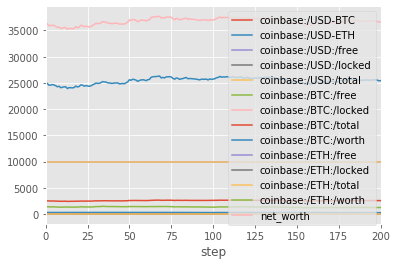

In [6]:
%matplotlib inline

portfolio.performance.plot()

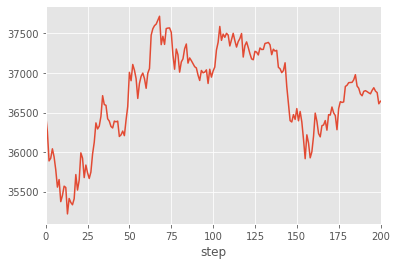

In [7]:
portfolio.performance.net_worth.plot()

## Setup and Train A2C Agent

In [8]:
from tensortrade.agents import A2CAgent

agent = A2CAgent(env)

agent.train(n_steps=200, save_path="examples/agents/")

I0127 21:59:30.511389 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:30.516419 4681977280 trading_environment.py:206] Observation: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.000

I0127 21:59:30.553213 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:30.559173 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.000

I0127 21:59:30.560194 4681977280 trading_environment.py:207] P/L:         0.9841362336923362
I0127 21:59:30.560817 4681977280 trading_environment.py:208] Reward (2): -2.526629233556655
I0127 21:59:30.566939 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
2               2454.43             268.79                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
2                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
2                         0                    10               24544.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:30.592266 4681977280 trading_environment.py:207] P/L:         0.9850672187677816
I0127 21:59:30.593029 4681977280 trading_environment.py:208] Reward (3): -0.8924041720193531
I0127 21:59:30.598938 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
3               2459.35             265.74                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
3                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
3                         0                    10               24593.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:30.622679 4681977280 trading_environment.py:207] P/L:         0.9883290943119417
I0127 21:59:30.623295 4681977280 trading_environment.py:208] Reward (4): -0.47511554349495266
I0127 21:59:30.628518 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
4               2467.83             272.57                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
4                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
4                         0                    10               24678.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:30.650234 4681977280 trading_environment.py:207] P/L:         0.9855580768782523
I0127 21:59:30.651108 4681977280 trading_environment.py:208] Reward (5): -0.5430577522032953
I0127 21:59:30.657190 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
5               2460.01              268.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
5                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
5                         0                    10               24600.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:30.678907 4681977280 trading_environment.py:207] P/L:         0.9810978494107645
I0127 21:59:30.679456 4681977280 trading_environment.py:208] Reward (6): -0.6562818990729306
I0127 21:59:30.685256 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
6               2445.99             263.51                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
6                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
6                         0                    10               24459.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:30.706713 4681977280 trading_environment.py:207] P/L:         0.9750498742004703
I0127 21:59:30.707309 4681977280 trading_environment.py:208] Reward (7): -0.789112239656612
I0127 21:59:30.712515 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
7               2425.94              259.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
7                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
7                         0                    10               24259.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

====      EPISODE ID: f5e7103e-7318-4a5a-aa03-a8317be16493      ====


I0127 21:59:30.727151 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:30.731995 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.000

I0127 21:59:30.732918 4681977280 trading_environment.py:207] P/L:         0.9776673270856325
I0127 21:59:30.733695 4681977280 trading_environment.py:208] Reward (8): -0.5916264682784595
I0127 21:59:30.739730 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
8               2435.99             258.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
8                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
8                         0                    10               24359.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:30.763235 4681977280 trading_environment.py:207] P/L:         0.970016521900087
I0127 21:59:30.763734 4681977280 trading_environment.py:208] Reward (9): -0.7085936065883242
I0127 21:59:30.769481 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
9               2408.25             258.17                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
9                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
9                         0                    10               24082.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:30.790319 4681977280 trading_environment.py:207] P/L:         0.972169167803547
I0127 21:59:30.790788 4681977280 trading_environment.py:208] Reward (10): -0.584699394868937
I0127 21:59:30.795799 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
10              2416.62             257.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
10                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
10                        0                    10               24166.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:30.815062 4681977280 trading_environment.py:207] P/L:         0.9753844255383326
I0127 21:59:30.815569 4681977280 trading_environment.py:208] Reward (11): -0.46004060272731867
I0127 21:59:30.821672 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
11              2424.99             263.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
11                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
11                        0                    10               24249.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:30.840706 4681977280 trading_environment.py:207] P/L:         0.9749127629964283
I0127 21:59:30.841377 4681977280 trading_environment.py:208] Reward (12): -0.44806243905691673
I0127 21:59:30.848049 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
12              2423.63             263.12                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
12                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
12                        0                    10               24236.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:30.873641 4681977280 trading_environment.py:207] P/L:         0.9657619612386625
I0127 21:59:30.874404 4681977280 trading_environment.py:208] Reward (13): -0.5399623993832383
I0127 21:59:30.879565 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
13              2391.87              259.9                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
13                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
13                        0                    10               23918.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:30.899491 4681977280 trading_environment.py:207] P/L:         0.971109298196302
I0127 21:59:30.900167 4681977280 trading_environment.py:208] Reward (14): -0.40079570079032173
I0127 21:59:30.906546 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
14               2409.9             262.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
14                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
14                        0                    10               24099.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:30.927094 4681977280 trading_environment.py:207] P/L:         0.9697381861558817
I0127 21:59:30.927854 4681977280 trading_environment.py:208] Reward (15): -0.4063564857821607
I0127 21:59:30.932881 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
15              2407.81             257.02                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
15                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
15                        0                    10               24078.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:30.954132 4681977280 trading_environment.py:207] P/L:         0.9689360856122358
I0127 21:59:30.955178 4681977280 trading_environment.py:208] Reward (16): -0.4039723755349901
I0127 21:59:30.960810 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
16              2404.99             256.81                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
16                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
16                        0                    10               24049.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:30.981375 4681977280 trading_environment.py:207] P/L:         0.9709996092330684
I0127 21:59:30.982388 4681977280 trading_environment.py:208] Reward (17): -0.35885854810168655
I0127 21:59:30.989599 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
17               2412.0             257.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
17                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
17                        0                    10               24120.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.017436 4681977280 trading_environment.py:207] P/L:         0.9794045260408454
I0127 21:59:31.019405 4681977280 trading_environment.py:208] Reward (18): -0.22041342099672062
I0127 21:59:31.027960 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
18              2439.97              263.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
18                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
18                        0                    10               24399.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.056389 4681977280 trading_environment.py:207] P/L:         0.9740352512905592
I0127 21:59:31.057106 4681977280 trading_environment.py:208] Reward (19): -0.26601689597172784
I0127 21:59:31.062576 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
19              2421.55             260.88                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
19                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
19                        0                    10               24215.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.087267 4681977280 trading_environment.py:207] P/L:         0.9774520624952868
I0127 21:59:31.088048 4681977280 trading_environment.py:208] Reward (20): -0.22048560576361143
I0127 21:59:31.094045 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
20              2431.95              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
20                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
20                        0                    10               24319.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.114151 4681977280 trading_environment.py:207] P/L:         0.9869237044705107
I0127 21:59:31.114645 4681977280 trading_environment.py:208] Reward (21): -0.11333179134151758
I0127 21:59:31.120789 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
21              2461.99              274.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
21                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
21                        0                    10               24619.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.140442 4681977280 trading_environment.py:207] P/L:         0.9850946410085901
I0127 21:59:31.141199 4681977280 trading_environment.py:208] Reward (22): -0.12621229279480642
I0127 21:59:31.146306 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
22              2457.54             269.56                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
22                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
22                        0                    10               24575.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.167063 4681977280 trading_environment.py:207] P/L:         0.9783583675540045
I0127 21:59:31.167795 4681977280 trading_environment.py:208] Reward (23): -0.17442070790584502
I0127 21:59:31.174664 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
23              2436.07             263.37                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
23                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
23                        0                    10               24360.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.202996 4681977280 trading_environment.py:207] P/L:         0.982700679386016
I0127 21:59:31.203540 4681977280 trading_environment.py:208] Reward (24): -0.1338499586360867
I0127 21:59:31.209818 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
24               2449.6             267.98                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
24                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
24                        0                    10               24496.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:31.233536 4681977280 trading_environment.py:207] P/L:         0.980020155346994
I0127 21:59:31.234191 4681977280 trading_environment.py:208] Reward (25): -0.15118101327840847
I0127 21:59:31.239214 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
25              2440.87             265.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
25                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
25                        0                    10               24408.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:31.260121 4681977280 trading_environment.py:207] P/L:         0.9780484962328697
I0127 21:59:31.260825 4681977280 trading_environment.py:208] Reward (26): -0.16284443796439824
I0127 21:59:31.265773 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
26              2435.62             262.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
26                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
26                        0                    10               24356.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.285150 4681977280 trading_environment.py:207] P/L:         0.9802779244105931
I0127 21:59:31.285754 4681977280 trading_environment.py:208] Reward (27): -0.142714290347313
I0127 21:59:31.290663 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
27              2442.99             263.53                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
27                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
27                        0                    10               24429.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:31.310515 4681977280 trading_environment.py:207] P/L:         0.9865301953149103
I0127 21:59:31.311152 4681977280 trading_environment.py:208] Reward (28): -0.0926364944060809
I0127 21:59:31.316047 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
28              2463.86             267.39                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
28                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
28                        0                    10               24638.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:31.335052 4681977280 trading_environment.py:207] P/L:         0.9905928002906756
I0127 21:59:31.335628 4681977280 trading_environment.py:208] Reward (29): -0.06275866124815623
I0127 21:59:31.340777 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
29              2476.41             271.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
29                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
29                        0                    10               24764.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.359329 4681977280 trading_environment.py:207] P/L:         0.9973112492887356
I0127 21:59:31.360315 4681977280 trading_environment.py:208] Reward (30): -0.017106848223537894
I0127 21:59:31.365146 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
30              2496.37              281.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
30                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
30                        0                    10               24963.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.384952 4681977280 trading_environment.py:207] P/L:         0.9952161900909734
I0127 21:59:31.385720 4681977280 trading_environment.py:208] Reward (31): -0.02988514892594805
I0127 21:59:31.390521 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
31              2490.08              278.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
31                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
31                        0                    10               24900.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.408811 4681977280 trading_environment.py:207] P/L:         0.9962116174323187
I0127 21:59:31.409382 4681977280 trading_environment.py:208] Reward (32): -0.023287341395320887
I0127 21:59:31.414593 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
32              2492.61              280.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
32                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
32                        0                    10               24926.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.436303 4681977280 trading_environment.py:207] P/L:         0.9996064908443993
I0127 21:59:31.436912 4681977280 trading_environment.py:208] Reward (33): -0.0023655443282388357
I0127 21:59:31.442143 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
33              2504.09              282.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
33                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
33                        0                    10               25040.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:31.460815 4681977280 trading_environment.py:207] P/L:         1.0067445001268278
I0127 21:59:31.461532 4681977280 trading_environment.py:208] Reward (34): 0.03879549645434459
I0127 21:59:31.466974 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
34               2525.0             292.54                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
34                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
34                        0                    10               25250.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:31.489478 4681977280 trading_environment.py:207] P/L:         1.0036567558118012
I0127 21:59:31.490573 4681977280 trading_environment.py:208] Reward (35): 0.02061562897063415
I0127 21:59:31.496227 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
35              2517.01              286.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
35                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
35                        0                    10               25170.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:31.519783 4681977280 trading_environment.py:207] P/L:         1.0034236667649297
I0127 21:59:31.520509 4681977280 trading_environment.py:208] Reward (36): 0.01903814702513936
I0127 21:59:31.525440 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
36              2516.66              285.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
36                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
36                        0                    10               25166.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:31.545383 4681977280 trading_environment.py:207] P/L:         0.9987591436034196
I0127 21:59:31.545907 4681977280 trading_environment.py:208] Reward (37): -0.006724506792371679
I0127 21:59:31.551441 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
37              2500.97             282.36                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
37                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
37                        0                    10               25009.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.570122 4681977280 trading_environment.py:207] P/L:         0.9979131674744802
I0127 21:59:31.570639 4681977280 trading_environment.py:208] Reward (38): -0.011159338344944585
I0127 21:59:31.575645 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
38               2500.0             278.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
38                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
38                        0                    10               25000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.593368 4681977280 trading_environment.py:207] P/L:         0.9960745062282764
I0127 21:59:31.593893 4681977280 trading_environment.py:208] Reward (39): -0.020692124203055315
I0127 21:59:31.598815 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
39               2491.4             281.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
39                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
39                        0                    10               24914.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.616590 4681977280 trading_environment.py:207] P/L:         0.9955452569806743
I0127 21:59:31.617186 4681977280 trading_environment.py:208] Reward (40): -0.023191845629168418
I0127 21:59:31.622415 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
40              2490.83              279.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
40                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
40                        0                    10               24908.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.641206 4681977280 trading_environment.py:207] P/L:         0.997932363043046
I0127 21:59:31.641885 4681977280 trading_environment.py:208] Reward (41): -0.010599740635431058
I0127 21:59:31.646362 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
41              2498.92             280.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
41                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
41                        0                    10               24989.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.664084 4681977280 trading_environment.py:207] P/L:         0.9976787073155684
I0127 21:59:31.664702 4681977280 trading_environment.py:208] Reward (42): -0.011760822221817895
I0127 21:59:31.670068 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
42              2497.61              281.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
42                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
42                        0                    10               24976.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.688624 4681977280 trading_environment.py:207] P/L:         0.9979296208189652
I0127 21:59:31.689325 4681977280 trading_environment.py:208] Reward (43): -0.010369295892691689
I0127 21:59:31.694375 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
43              2499.98             278.29                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
43                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
43                        0                    10               24999.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.714767 4681977280 trading_environment.py:207] P/L:         0.9926083349900936
I0127 21:59:31.715227 4681977280 trading_environment.py:208] Reward (44): -0.036070043564680576
I0127 21:59:31.720517 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
44              2481.72              276.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
44                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
44                        0                    10               24817.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.741933 4681977280 trading_environment.py:207] P/L:         0.9931608931423831
I0127 21:59:31.742387 4681977280 trading_environment.py:208] Reward (45): -0.033000300785042326
I0127 21:59:31.747116 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
45              2483.72             276.03                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
45                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
45                        0                    10               24837.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.768275 4681977280 trading_environment.py:207] P/L:         0.9944771607011866
I0127 21:59:31.769001 4681977280 trading_environment.py:208] Reward (46): -0.02633451768169706
I0127 21:59:31.773826 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
46              2489.09             274.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
46                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
46                        0                    10               24890.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.790584 4681977280 trading_environment.py:207] P/L:         0.9928921551824608
I0127 21:59:31.791049 4681977280 trading_environment.py:208] Reward (47): -0.033500127099890975
I0127 21:59:31.795871 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
47              2482.09             277.33                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
47                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
47                        0                    10               24820.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.814721 4681977280 trading_environment.py:207] P/L:         0.9982902232855958
I0127 21:59:31.815332 4681977280 trading_environment.py:208] Reward (48): -0.007850547023267188
I0127 21:59:31.820458 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
48               2502.3             276.28                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
48                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
48                        0                    10               25023.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:31.837850 4681977280 trading_environment.py:207] P/L:         1.0029876531360762
I0127 21:59:31.838469 4681977280 trading_environment.py:208] Reward (49): 0.013428817531711504
I0127 21:59:31.843707 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
49              2519.38             276.38                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
49                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
49                        0                    10               25193.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.861455 4681977280 trading_environment.py:207] P/L:         1.014843658949591
I0127 21:59:31.861999 4681977280 trading_environment.py:208] Reward (50): 0.061933076050304445
I0127 21:59:31.866893 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
50               2560.0             281.61                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
50                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
50                        0                    10               25600.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:31.885121 4681977280 trading_environment.py:207] P/L:         1.0119286747516574
I0127 21:59:31.885618 4681977280 trading_environment.py:208] Reward (51): 0.0490703046659764
I0127 21:59:31.890972 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
51               2550.0             280.35                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
51                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
51                        0                    10               25500.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:31.908562 4681977280 trading_environment.py:207] P/L:         1.0175639452377852
I0127 21:59:31.909097 4681977280 trading_environment.py:208] Reward (52): 0.07068279726169201
I0127 21:59:31.914318 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
52              2569.98             281.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
52                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
52                        0                    10               25699.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:31.932919 4681977280 trading_environment.py:207] P/L:         1.0155922861236606
I0127 21:59:31.933799 4681977280 trading_environment.py:208] Reward (53): 0.062025747456887756
I0127 21:59:31.939023 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
53               2563.0             281.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
53                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
53                        0                    10               25630.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.958501 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:31.959020 4681977280 trading_environment.py:208] Reward (54): 0.049749719528713196
I0127 21:59:31.964277 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
54              2552.37             281.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
54                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
54                        0                    10               25523.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:31.987393 4681977280 trading_environment.py:207] P/L:         1.0057929483707762
I0127 21:59:31.988111 4681977280 trading_environment.py:208] Reward (55): 0.022071626995399506
I0127 21:59:31.994786 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
55               2528.8              278.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
55                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
55                        0                    10               25288.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.015772 4681977280 trading_environment.py:207] P/L:         1.0109826074437673
I0127 21:59:32.016736 4681977280 trading_environment.py:208] Reward (56): 0.041054581717159866
I0127 21:59:32.022213 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
56              2547.43             278.59                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
56                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
56                        0                    10               25474.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.042567 4681977280 trading_environment.py:207] P/L:         1.0134629491248877
I0127 21:59:32.043262 4681977280 trading_environment.py:208] Reward (57): 0.04978942726444877
I0127 21:59:32.048517 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
57              2556.02              279.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
57                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
57                        0                    10               25560.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.072453 4681977280 trading_environment.py:207] P/L:         1.0145749209896686
I0127 21:59:32.073298 4681977280 trading_environment.py:208] Reward (58): 0.05342734204750062
I0127 21:59:32.078534 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
58              2559.98             279.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
58                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
58                        0                    10               25599.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.097593 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:32.098158 4681977280 trading_environment.py:208] Reward (59): 0.04599476870779731
I0127 21:59:32.103147 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
59               2554.4              277.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
59                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
59                        0                    10               25544.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.122811 4681977280 trading_environment.py:207] P/L:         1.0093016240822117
I0127 21:59:32.123317 4681977280 trading_environment.py:208] Reward (60): 0.03330714261771501
I0127 21:59:32.127975 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
60              2542.41             276.37                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
60                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
60                        0                    10               25424.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.146723 4681977280 trading_environment.py:207] P/L:         1.0145612098692645
I0127 21:59:32.147358 4681977280 trading_environment.py:208] Reward (61): 0.05120779232972535
I0127 21:59:32.152148 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
61              2560.93             277.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
61                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
61                        0                    10               25609.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.169842 4681977280 trading_environment.py:207] P/L:         1.0161626687324754
I0127 21:59:32.170383 4681977280 trading_environment.py:208] Reward (62): 0.056347546164706434
I0127 21:59:32.175400 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
62              2566.27             278.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
62                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
62                        0                    10               25662.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.193019 4681977280 trading_environment.py:207] P/L:         1.027733483241583
I0127 21:59:32.193686 4681977280 trading_environment.py:208] Reward (63): 0.09161363371143218
I0127 21:59:32.199111 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
63               2607.1             281.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
63                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
63                        0                    10               26071.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:32.222470 4681977280 trading_environment.py:207] P/L:         1.02994097362666
I0127 21:59:32.223111 4681977280 trading_environment.py:208] Reward (64): 0.09803716650923569
I0127 21:59:32.228224 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
64              2616.28             279.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
64                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
64                        0                    10               26162.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:32.246385 4681977280 trading_environment.py:207] P/L:         1.0310282654747132
I0127 21:59:32.246927 4681977280 trading_environment.py:208] Reward (65): 0.10081182512213782
I0127 21:59:32.252024 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
65               2620.0             279.65                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
65                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
65                        0                    10               26200.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.270997 4681977280 trading_environment.py:207] P/L:         1.0315547724982346
I0127 21:59:32.271903 4681977280 trading_environment.py:208] Reward (66): 0.10175477179040315
I0127 21:59:32.277221 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
66               2621.0             281.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
66                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
66                        0                    10               26210.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.295655 4681977280 trading_environment.py:207] P/L:         1.0328998334098871
I0127 21:59:32.296304 4681977280 trading_environment.py:208] Reward (67): 0.10528241566855115
I0127 21:59:32.301551 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
67               2625.9              281.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
67                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
67                        0                    10               26259.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.324491 4681977280 trading_environment.py:207] P/L:         1.0342791721225502
I0127 21:59:32.325418 4681977280 trading_environment.py:208] Reward (68): 0.10886950130075103
I0127 21:59:32.330164 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
68              2630.93              281.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
68                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
68                        0                    10               26309.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.348837 4681977280 trading_environment.py:207] P/L:         1.0244345876723315
I0127 21:59:32.349493 4681977280 trading_environment.py:208] Reward (69): 0.07436392748137288
I0127 21:59:32.355467 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
69              2594.49             282.58                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
69                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
69                        0                    10               25944.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.378874 4681977280 trading_environment.py:207] P/L:         1.0273317474137398
I0127 21:59:32.379518 4681977280 trading_environment.py:208] Reward (70): 0.08242330561109365
I0127 21:59:32.384917 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
70               2605.1             282.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
70                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
70                        0                    10               26051.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.405272 4681977280 trading_environment.py:207] P/L:         1.0245182255067975
I0127 21:59:32.405907 4681977280 trading_environment.py:208] Reward (71): 0.07318483786827729
I0127 21:59:32.411173 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
71              2594.83             282.51                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
71                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
71                        0                    10               25948.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.433470 4681977280 trading_environment.py:207] P/L:         1.030013642564802
I0127 21:59:32.434016 4681977280 trading_environment.py:208] Reward (72): 0.08823541095930078
I0127 21:59:32.438932 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
72              2614.93             282.39                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
72                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
72                        0                    10               26149.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:32.457887 4681977280 trading_environment.py:207] P/L:         1.030176804897612
I0127 21:59:32.458636 4681977280 trading_environment.py:208] Reward (73): 0.08811208408306434
I0127 21:59:32.464607 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
73              2616.22              281.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
73                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
73                        0                    10               26162.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:32.482933 4681977280 trading_environment.py:207] P/L:         1.0302220515949463
I0127 21:59:32.483521 4681977280 trading_environment.py:208] Reward (74): 0.08765045310192071
I0127 21:59:32.489133 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
74              2617.88             278.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
74                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
74                        0                    10               26178.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.506881 4681977280 trading_environment.py:207] P/L:         1.0287371372551708
I0127 21:59:32.507709 4681977280 trading_environment.py:208] Reward (75): 0.08270172374164687
I0127 21:59:32.512642 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
75              2612.72              277.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
75                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
75                        0                    10               26127.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.530816 4681977280 trading_environment.py:207] P/L:         1.020951963089664
I0127 21:59:32.531373 4681977280 trading_environment.py:208] Reward (76): 0.0587000603520242
I0127 21:59:32.536839 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
76               2587.0             272.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
76                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
76                        0                    10               25870.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:32.555826 4681977280 trading_environment.py:207] P/L:         1.0159186107892806
I0127 21:59:32.556430 4681977280 trading_environment.py:208] Reward (77): 0.043943700914500144
I0127 21:59:32.561258 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
77              2570.25             268.95                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
77                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
77                        0                    10               25702.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.578946 4681977280 trading_environment.py:207] P/L:         1.022916766643586
I0127 21:59:32.579527 4681977280 trading_environment.py:208] Reward (78): 0.06202685193273347
I0127 21:59:32.584275 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
78               2594.0             272.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
78                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
78                        0                    10               25940.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:32.602823 4681977280 trading_environment.py:207] P/L:         1.0209368808572192
I0127 21:59:32.603312 4681977280 trading_environment.py:208] Reward (79): 0.056229887848432386
I0127 21:59:32.608633 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
79              2586.71             272.63                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
79                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
79                        0                    10               25867.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.626765 4681977280 trading_environment.py:207] P/L:         1.0149039878793698
I0127 21:59:32.627413 4681977280 trading_environment.py:208] Reward (80): 0.039337536229254885
I0127 21:59:32.632762 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
80              2566.51             269.03                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
80                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
80                        0                    10               25665.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.650572 4681977280 trading_environment.py:207] P/L:         1.01842774582325
I0127 21:59:32.651082 4681977280 trading_environment.py:208] Reward (81): 0.048191369492442834
I0127 21:59:32.655946 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
81              2579.09             269.57                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
81                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
81                        0                    10               25790.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:32.674138 4681977280 trading_environment.py:207] P/L:         1.0195109243351823
I0127 21:59:32.674806 4681977280 trading_environment.py:208] Reward (82): 0.050705551608363576
I0127 21:59:32.679820 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
82              2582.36             270.93                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
82                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
82                        0                    10               25823.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.702301 4681977280 trading_environment.py:207] P/L:         1.0230223422706988
I0127 21:59:32.703316 4681977280 trading_environment.py:208] Reward (83): 0.059298307087601705
I0127 21:59:32.708401 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
83              2595.98              269.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
83                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
83                        0                    10               25959.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.731095 4681977280 trading_environment.py:207] P/L:         1.0246594500469606
I0127 21:59:32.731518 4681977280 trading_environment.py:208] Reward (84): 0.06310824680331231
I0127 21:59:32.737577 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
84               2602.0              269.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
84                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
84                        0                    10               26020.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.757787 4681977280 trading_environment.py:207] P/L:         1.0180314944435684
I0127 21:59:32.758308 4681977280 trading_environment.py:208] Reward (85): 0.04528407477769179
I0127 21:59:32.763317 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
85              2578.97             266.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
85                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
85                        0                    10               25789.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.782515 4681977280 trading_environment.py:207] P/L:         1.0198249089924383
I0127 21:59:32.783210 4681977280 trading_environment.py:208] Reward (86): 0.04946799908136153
I0127 21:59:32.788271 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
86              2584.27              269.4                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
86                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
86                        0                    10               25842.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.808970 4681977280 trading_environment.py:207] P/L:         1.0188925528049524
I0127 21:59:32.809600 4681977280 trading_environment.py:208] Reward (87): 0.04685603647309874
I0127 21:59:32.814700 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
87              2580.85             269.44                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
87                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
87                        0                    10               25808.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.836280 4681977280 trading_environment.py:207] P/L:         1.0178093742930203
I0127 21:59:32.836829 4681977280 trading_environment.py:208] Reward (88): 0.04390097068970128
I0127 21:59:32.841852 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
88              2576.12              271.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
88                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
88                        0                    10               25761.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.864600 4681977280 trading_environment.py:207] P/L:         1.0167865247108667
I0127 21:59:32.865101 4681977280 trading_environment.py:208] Reward (89): 0.04113261952486661
I0127 21:59:32.870431 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
89              2572.85             270.08                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
89                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
89                        0                    10               25728.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.892481 4681977280 trading_environment.py:207] P/L:         1.0163614799783367
I0127 21:59:32.893007 4681977280 trading_environment.py:208] Reward (90): 0.03986627206608407
I0127 21:59:32.898435 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
90              2571.76             269.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
90                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
90                        0                    10               25717.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.918241 4681977280 trading_environment.py:207] P/L:         1.0138646849527306
I0127 21:59:32.918855 4681977280 trading_environment.py:208] Reward (91): 0.033534313633888126
I0127 21:59:32.924017 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
91              2563.24             267.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
91                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
91                        0                    10               25632.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:32.942270 4681977280 trading_environment.py:207] P/L:         1.0120136836981632
I0127 21:59:32.942791 4681977280 trading_environment.py:208] Reward (92): 0.02886988829576727
I0127 21:59:32.947941 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
92              2558.37             264.23                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
92                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
92                        0                    10               25583.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.967041 4681977280 trading_environment.py:207] P/L:         1.0154853393845078
I0127 21:59:32.967885 4681977280 trading_environment.py:208] Reward (93): 0.03690486127307281
I0127 21:59:32.973124 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
93               2570.7             264.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
93                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
93                        0                    10               25707.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:32.996751 4681977280 trading_environment.py:207] P/L:         1.0146777543927001
I0127 21:59:32.997381 4681977280 trading_environment.py:208] Reward (94): 0.034786945883372423
I0127 21:59:33.002789 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
94               2568.4              263.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
94                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
94                        0                    10               25684.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.023645 4681977280 trading_environment.py:207] P/L:         1.014908101215491
I0127 21:59:33.024419 4681977280 trading_environment.py:208] Reward (95): 0.03514836174454622
I0127 21:59:33.029418 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
95              2570.01             262.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
95                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
95                        0                    10               25700.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step           

I0127 21:59:33.051396 4681977280 trading_environment.py:207] P/L:         1.0156910061905708
I0127 21:59:33.052105 4681977280 trading_environment.py:208] Reward (96): 0.036799241215666884
I0127 21:59:33.057351 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
96              2572.06             263.67                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
96                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
96                        0                    10               25720.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.078907 4681977280 trading_environment.py:207] P/L:         1.0109812363317268
I0127 21:59:33.079590 4681977280 trading_environment.py:208] Reward (97): 0.02546281116950204
I0127 21:59:33.085030 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
97              2555.72              262.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
97                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
97                        0                    10               25557.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:33.104663 4681977280 trading_environment.py:207] P/L:         1.0159117552290786
I0127 21:59:33.105298 4681977280 trading_environment.py:208] Reward (98): 0.03648854017601204
I0127 21:59:33.110563 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
98              2575.72             257.96                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
98                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
98                        0                    10               25757.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:33.128815 4681977280 trading_environment.py:207] P/L:         1.0131750155963997
I0127 21:59:33.129363 4681977280 trading_environment.py:208] Reward (99): 0.029996388239595086
I0127 21:59:33.134156 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
99              2567.01             255.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
99                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
99                        0                    10               25670.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.154685 4681977280 trading_environment.py:207] P/L:         1.0152824148025255
I0127 21:59:33.155536 4681977280 trading_environment.py:208] Reward (100): 0.034587214345644296
I0127 21:59:33.160481 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
100             2573.91             256.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
100                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
100                       0                    10               25739.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:33.183125 4681977280 trading_environment.py:207] P/L:         1.0166644957392692
I0127 21:59:33.183824 4681977280 trading_environment.py:208] Reward (101): 0.037515331387991326
I0127 21:59:33.188902 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
101             2578.96             256.97                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
101                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
101                       0                    10               25789.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:33.208759 4681977280 trading_environment.py:207] P/L:         1.0225753597455216
I0127 21:59:33.209484 4681977280 trading_environment.py:208] Reward (102): 0.0501526485950638
I0127 21:59:33.214411 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
102              2598.0              262.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
102                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
102                       0                    10               25980.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:33.234917 4681977280 trading_environment.py:207] P/L:         1.0252421726641392
I0127 21:59:33.235576 4681977280 trading_environment.py:208] Reward (103): 0.05572312385361467
I0127 21:59:33.241030 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
103             2603.45             270.55                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
103                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
103                       0                    10               26034.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.262520 4681977280 trading_environment.py:207] P/L:         1.0307444452823462
I0127 21:59:33.262981 4681977280 trading_environment.py:208] Reward (104): 0.06708196551809528
I0127 21:59:33.267578 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
104             2623.79              270.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
104                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
104                       0                    10               26237.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.285765 4681977280 trading_environment.py:207] P/L:         1.0259208731241474
I0127 21:59:33.286748 4681977280 trading_environment.py:208] Reward (105): 0.055928242945113046
I0127 21:59:33.292016 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
105              2608.6              265.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
105                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
105                       0                    10               26086.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:33.313480 4681977280 trading_environment.py:207] P/L:         1.0280995701563753
I0127 21:59:33.314075 4681977280 trading_environment.py:208] Reward (106): 0.06029021431870547
I0127 21:59:33.318969 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
106             2615.15             267.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
106                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
106                       0                    10               26151.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.340474 4681977280 trading_environment.py:207] P/L:         1.0269780005073113
I0127 21:59:33.340908 4681977280 trading_environment.py:208] Reward (107): 0.05758821392821888
I0127 21:59:33.346022 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
107             2611.64             266.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
107                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
107                       0                    10               26116.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.364525 4681977280 trading_environment.py:207] P/L:         1.0283600814440552
I0127 21:59:33.364954 4681977280 trading_environment.py:208] Reward (108): 0.06024141379659769
I0127 21:59:33.370259 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
108             2616.96             266.27                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
108                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
108                       0                    10               26169.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.389124 4681977280 trading_environment.py:207] P/L:         1.027745823249947
I0127 21:59:33.389715 4681977280 trading_environment.py:208] Reward (109): 0.05865718176025897
I0127 21:59:33.394651 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
109             2615.85             264.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
109                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
109                       0                    10               26158.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:33.415178 4681977280 trading_environment.py:207] P/L:         1.0239766362508314
I0127 21:59:33.415679 4681977280 trading_environment.py:208] Reward (110): 0.05026212783587289
I0127 21:59:33.420560 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
110             2603.01              262.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
110                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
110                       0                    10               26030.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.441679 4681977280 trading_environment.py:207] P/L:         1.026167673291423
I0127 21:59:33.442162 4681977280 trading_environment.py:208] Reward (111): 0.05455847710948676
I0127 21:59:33.446917 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
111              2610.0              264.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
111                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
111                       0                    10               26100.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:33.468668 4681977280 trading_environment.py:207] P/L:         1.0283587103320146
I0127 21:59:33.469242 4681977280 trading_environment.py:208] Reward (112): 0.05881030900863999
I0127 21:59:33.474195 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
112             2616.99              266.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
112                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
112                       0                    10               26169.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.491550 4681977280 trading_environment.py:207] P/L:         1.0258139263849946
I0127 21:59:33.492012 4681977280 trading_environment.py:208] Reward (113): 0.053197447029862725
I0127 21:59:33.497555 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
113             2607.97             265.68                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
113                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
113                       0                    10               26079.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:33.517853 4681977280 trading_environment.py:207] P/L:         1.023594095991554
I0127 21:59:33.518587 4681977280 trading_environment.py:208] Reward (114): 0.048341495538676595
I0127 21:59:33.523648 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
114              2600.0             265.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
114                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
114                       0                    10               26000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.543963 4681977280 trading_environment.py:207] P/L:         1.0254944572795766
I0127 21:59:33.544512 4681977280 trading_environment.py:208] Reward (115): 0.05197385281744579
I0127 21:59:33.549540 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
115              2605.8             267.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
115                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
115                       0                    10               26058.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.566886 4681977280 trading_environment.py:207] P/L:         1.0265543268868216
I0127 21:59:33.567847 4681977280 trading_environment.py:208] Reward (116): 0.053893684763329876
I0127 21:59:33.572587 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
116             2608.09             270.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
116                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
116                       0                    10               26080.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:33.590826 4681977280 trading_environment.py:207] P/L:         1.0282901547299939
I0127 21:59:33.591369 4681977280 trading_environment.py:208] Reward (117): 0.05714189068419058
I0127 21:59:33.596165 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
117             2612.34              275.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
117                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
117                       0                    10               26123.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.616929 4681977280 trading_environment.py:207] P/L:         1.0201388936496947
I0127 21:59:33.617418 4681977280 trading_environment.py:208] Reward (118): 0.03984195338779242
I0127 21:59:33.622057 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
118             2585.05             270.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
118                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
118                       0                    10               25850.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.643491 4681977280 trading_environment.py:207] P/L:         1.0240876963261054
I0127 21:59:33.644236 4681977280 trading_environment.py:208] Reward (119): 0.047299490696070576
I0127 21:59:33.649246 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
119             2598.16             272.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
119                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
119                       0                    10               25981.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:33.669441 4681977280 trading_environment.py:207] P/L:         1.025387510540424
I0127 21:59:33.669878 4681977280 trading_environment.py:208] Reward (120): 0.04963174436229475
I0127 21:59:33.674714 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
120             2602.98             272.55                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
120                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
120                       0                    10               26029.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:33.692918 4681977280 trading_environment.py:207] P/L:         1.0234432736671077
I0127 21:59:33.693535 4681977280 trading_environment.py:208] Reward (121): 0.04559406543177649
I0127 21:59:33.698331 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
121             2598.54             267.25                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
121                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
121                       0                    10               25985.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.717411 4681977280 trading_environment.py:207] P/L:         1.0212892566516072
I0127 21:59:33.718085 4681977280 trading_environment.py:208] Reward (122): 0.04118423513061182
I0127 21:59:33.722995 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
122              2591.6             265.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
122                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
122                       0                    10               25916.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.740504 4681977280 trading_environment.py:207] P/L:         1.0194848732064141
I0127 21:59:33.741018 4681977280 trading_environment.py:208] Reward (123): 0.03750784602979752
I0127 21:59:33.746443 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
123             2585.23              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
123                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
123                       0                    10               25852.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.764662 4681977280 trading_environment.py:207] P/L:         1.019201053014047
I0127 21:59:33.765258 4681977280 trading_environment.py:208] Reward (124): 0.036811735899965656
I0127 21:59:33.770009 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
124             2583.95             265.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
124                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
124                       0                    10               25839.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.792556 4681977280 trading_environment.py:207] P/L:         1.0221228927721828
I0127 21:59:33.793094 4681977280 trading_environment.py:208] Reward (125): 0.042171268445565825
I0127 21:59:33.797842 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
125             2594.47             265.76                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
125                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
125                       0                    10               25944.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:33.818245 4681977280 trading_environment.py:207] P/L:         1.0218349592436946
I0127 21:59:33.818805 4681977280 trading_environment.py:208] Reward (126): 0.0414561959109054
I0127 21:59:33.823714 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
126             2594.05              264.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
126                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
126                       0                    10               25940.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:33.841609 4681977280 trading_environment.py:207] P/L:         1.020864211919077
I0127 21:59:33.842123 4681977280 trading_environment.py:208] Reward (127): 0.039446373381618965
I0127 21:59:33.847146 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
127             2590.96              263.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
127                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
127                       0                    10               25909.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:33.865910 4681977280 trading_environment.py:207] P/L:         1.0232801113342975
I0127 21:59:33.866396 4681977280 trading_environment.py:208] Reward (128): 0.043792655175830385
I0127 21:59:33.871344 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
128              2600.0             263.14                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
128                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
128                       0                    10               26000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

InvalidArgumentError: Can not squeeze dim[1], expected a dimension of 1, got 128 [Op:Squeeze]

In [ ]:
portfolio.performance.plot()

In [ ]:
portfolio.performance.net_worth.plot()

## Setup and Train Parallel DQN Agent

In [9]:
from tensortrade.agents import ParallelDQNAgent

def create_env():
    feed = DataFeed()(coinbase_ns)

    portfolio = Portfolio(USD, [
        Wallet(coinbase, 10000 * USD),
        Wallet(coinbase, 10 * BTC),
        Wallet(coinbase, 5 * ETH),
    ])
    
    env = TradingEnvironment(
        feed=feed,
        portfolio=portfolio,
        action_scheme='managed-risk',
        reward_scheme='risk-adjusted',
        window_size=20,
        enable_logger=True
    )
    
    return env

agent = ParallelDQNAgent(create_env)

agent.train(n_envs=4, n_steps=200, save_path="examples/agents/")

====      EPISODE ID (0/2147483647): 8b9347d0-7847-49a1-97d3-6cdd6ef3a112      ====
====      EPISODE ID (0/2147483647): de4a33eb-3b6c-42ae-ad41-5700858d9cd3      ====


I0127 21:59:41.356909 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.366626 4681977280 trading_environment.py:206] Observation: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.000

====      EPISODE ID (0/2147483647): 306edd45-5d10-47a4-806e-1ce2b9c0c03f      ====


I0127 21:59:41.370361 4681977280 trading_environment.py:207] P/L:         0.9942879472396088
I0127 21:59:41.373073 4681977280 trading_environment.py:208] Reward (1): 0.0
I0127 21:59:41.379832 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.384490 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
1               2488.43             274.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
1                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
1                         0                    10               24884.3   

      coinbase:/ETH:/free 

I0127 21:59:41.392925 4681977280 trading_environment.py:207] P/L:         0.9942879472396088


====      EPISODE ID (0/2147483647): 6695421a-3d0c-4623-855d-f09cadeec0b4      ====


I0127 21:59:41.395471 4681977280 trading_environment.py:208] Reward (1): 0.0
I0127 21:59:41.400501 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.407311 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
1               2488.43             274.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
1                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
1                         0                    10               24884.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                         

I0127 21:59:41.413533 4681977280 trading_environment.py:207] P/L:         0.9942879472396088
I0127 21:59:41.415426 4681977280 trading_environment.py:208] Reward (1): 0.0
I0127 21:59:41.415130 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.0000000

I0127 21:59:41.417247 4681977280 trading_environment.py:207] P/L:         0.9841362336923362
I0127 21:59:41.419290 4681977280 trading_environment.py:208] Reward (2): -2.526629233556655
I0127 21:59:41.419962 4681977280 trading_environment.py:206] Observation: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.

I0127 21:59:41.429085 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
2               2454.43             268.79                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
2                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
2                         0                    10               24544.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
2                       5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.432157 4681977280 trading_environment.py:207] P/L:         0.9841362336923362
I0127 21:59:41.434040 4681977280 trading_environment.py:208] Reward (2): -2.526629233556655
I0127 21:59:41.435386 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
1               2488.43             274.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
1                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
1                         0                    10               24884.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:41.454483 4681977280 trading_environment.py:207] P/L:         0.9841362336923362
I0127 21:59:41.454213 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000

I0127 21:59:41.456590 4681977280 trading_environment.py:207] P/L:         0.9850672187677816
I0127 21:59:41.456458 4681977280 trading_environment.py:208] Reward (2): -2.526629233556655
I0127 21:59:41.458345 4681977280 trading_environment.py:208] Reward (3): -0.8924041720193531
I0127 21:59:41.458705 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.463346 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.464719 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
2               2454.43             268.79                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
2                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:

I0127 21:59:41.468472 4681977280 trading_environment.py:207] P/L:         0.9850672187677816
I0127 21:59:41.470971 4681977280 trading_environment.py:208] Reward (3): -0.8924041720193531
I0127 21:59:41.471557 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.000000

I0127 21:59:41.474316 4681977280 trading_environment.py:207] P/L:         0.9841362336923362
I0127 21:59:41.477234 4681977280 trading_environment.py:208] Reward (2): -2.526629233556655
I0127 21:59:41.482437 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
3               2459.35             265.74                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
3                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
3                         0                    10               24593.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step            

I0127 21:59:41.495043 4681977280 trading_environment.py:207] P/L:         0.9850672187677816
I0127 21:59:41.497379 4681977280 trading_environment.py:208] Reward (3): -0.8924041720193531
I0127 21:59:41.498662 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.000000

I0127 21:59:41.501121 4681977280 trading_environment.py:207] P/L:         0.9883290943119417
I0127 21:59:41.503268 4681977280 trading_environment.py:208] Reward (4): -0.47511554349495266
I0127 21:59:41.505060 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.507105 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.507634 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
3               2459.35             265.74                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
3                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
3     

I0127 21:59:41.515235 4681977280 trading_environment.py:207] P/L:         0.9883290943119417
I0127 21:59:41.515424 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000

I0127 21:59:41.517193 4681977280 trading_environment.py:208] Reward (4): -0.47511554349495266
I0127 21:59:41.517434 4681977280 trading_environment.py:207] P/L:         0.9850672187677816
I0127 21:59:41.519109 4681977280 trading_environment.py:208] Reward (3): -0.8924041720193531
I0127 21:59:41.525339 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
4               2467.83             272.57                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
4                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
4                         0                    10               24678.3

I0127 21:59:41.536186 4681977280 trading_environment.py:207] P/L:         0.9883290943119417
I0127 21:59:41.538469 4681977280 trading_environment.py:208] Reward (4): -0.47511554349495266
I0127 21:59:41.542130 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000

I0127 21:59:41.543773 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.544026 4681977280 trading_environment.py:207] P/L:         0.9855580768782523
I0127 21:59:41.545797 4681977280 trading_environment.py:208] Reward (5): -0.5430577522032953
I0127 21:59:41.546144 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
4               2467.83             272.57                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
4                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
4                         0                    10               24678.3   

      coin

I0127 21:59:41.552897 4681977280 trading_environment.py:207] P/L:         0.9855580768782523
I0127 21:59:41.553163 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
5               2460.01              268.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
5                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
5                         0                    10               24600.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
5                       5         

I0127 21:59:41.554686 4681977280 trading_environment.py:208] Reward (5): -0.5430577522032953
I0127 21:59:41.556502 4681977280 trading_environment.py:207] P/L:         0.9883290943119417
I0127 21:59:41.558613 4681977280 trading_environment.py:208] Reward (4): -0.47511554349495266
I0127 21:59:41.563412 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
5               2460.01              268.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
5                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
5                         0                    10               24600.1

I0127 21:59:41.571094 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.572332 4681977280 trading_environment.py:207] P/L:         0.9855580768782523
I0127 21:59:41.574139 4681977280 trading_environment.py:208] Reward (5): -0.5430577522032953
I0127 21:59:41.579124 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

I0127 21:59:41.580425 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.581384 4681977280 trading_environment.py:207] P/L:         0.9810978494107645
I0127 21:59:41.581321 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
5               2460.01              268.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
5                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
5                         0                    10               24600.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:41.589986 4681977280 trading_environment.py:207] P/L:         0.9810978494107645
I0127 21:59:41.590073 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000

I0127 21:59:41.591066 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
6               2445.99             263.51                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
6                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
6                         0                    10               24459.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
6                       5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.602011 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.603394 4681977280 trading_environment.py:207] P/L:         0.9810978494107645
I0127 21:59:41.605050 4681977280 trading_environment.py:208] Reward (6): -0.6562818990729306
I0127 21:59:41.609207 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

I0127 21:59:41.611075 4681977280 trading_environment.py:207] P/L:         0.9750498742004703
I0127 21:59:41.611201 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
6               2445.99             263.51                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
6                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
6                         0                    10               24459.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
6                       5         

I0127 21:59:41.621776 4681977280 trading_environment.py:207] P/L:         0.9750498742004703
I0127 21:59:41.623301 4681977280 trading_environment.py:208] Reward (7): -0.789112239656612
I0127 21:59:41.623404 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0000000

I0127 21:59:41.624916 4681977280 trading_environment.py:207] P/L:         0.9810978494107645
I0127 21:59:41.626438 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.626907 4681977280 trading_environment.py:208] Reward (6): -0.6562818990729306
I0127 21:59:41.631464 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
7               2425.94              259.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
7                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
7                         0                    10               24259.4   

      coin

I0127 21:59:41.635131 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
6               2445.99             263.51                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
6                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
6                         0                    10               24459.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
6                       5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.644078 4681977280 trading_environment.py:207] P/L:         0.9776673270856325
I0127 21:59:41.645698 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
7               2425.94              259.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
7                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
7                         0                    10               24259.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
7                       5         

I0127 21:59:41.656150 4681977280 trading_environment.py:207] P/L:         0.9776673270856325
I0127 21:59:41.657844 4681977280 trading_environment.py:208] Reward (8): -0.5916264682784595
I0127 21:59:41.659156 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.000000

I0127 21:59:41.661351 4681977280 trading_environment.py:207] P/L:         0.9750498742004703
I0127 21:59:41.661775 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.663077 4681977280 trading_environment.py:208] Reward (7): -0.789112239656612
I0127 21:59:41.665242 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
8               2435.99             258.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
8                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
8                         0                    10               24359.9   

      coinb

I0127 21:59:41.670561 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
7               2425.94              259.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
7                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
7                         0                    10               24259.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
7                       5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.679448 4681977280 trading_environment.py:207] P/L:         0.970016521900087
I0127 21:59:41.679344 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
8               2435.99             258.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
8                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
8                         0                    10               24359.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
8                       5          

I0127 21:59:41.687635 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
9               2408.25             258.17                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
9                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
9                         0                    10               24082.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
9                       5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.695282 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.695692 4681977280 trading_environment.py:207] P/L:         0.9776673270856325
I0127 21:59:41.697087 4681977280 trading_environment.py:208] Reward (8): -0.5916264682784595
I0127 21:59:41.698883 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
9               2408.25             258.17                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
9                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
9                         0                    10               24082.5   

      coin

I0127 21:59:41.705935 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
8               2435.99             258.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
8                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
8                         0                    10               24359.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
8                       5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.714804 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
9               2408.25             258.17                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
9                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
9                         0                    10               24082.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
9                       5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.721277 4681977280 trading_environment.py:207] P/L:         0.972169167803547
I0127 21:59:41.722937 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.722967 4681977280 trading_environment.py:208] Reward (10): -0.584699394868937
I0127 21:59:41.724625 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
10              2416.62             257.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
10                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
10                        0                    10               24166.2   

      coinb

I0127 21:59:41.731317 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.731359 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
10              2416.62             257.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
10                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
10                        0                    10               24166.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
10                      5                      0

I0127 21:59:41.740983 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.742210 4681977280 trading_environment.py:207] P/L:         0.972169167803547
I0127 21:59:41.743322 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
9               2408.25             258.17                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
9                         0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
9                         0                    10               24082.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                          

I0127 21:59:41.749338 4681977280 trading_environment.py:207] P/L:         0.9753844255383326
I0127 21:59:41.751174 4681977280 trading_environment.py:208] Reward (11): -0.46004060272731867
I0127 21:59:41.751712 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
10              2416.62             257.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
10                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
10                        0                    10               24166.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:41.757743 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
11              2424.99             263.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
11                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
11                        0                    10               24249.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
11                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.768346 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.769813 4681977280 trading_environment.py:207] P/L:         0.972169167803547
I0127 21:59:41.771567 4681977280 trading_environment.py:208] Reward (10): -0.584699394868937
I0127 21:59:41.774267 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.775263 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

I0127 21:59:41.777333 4681977280 trading_environment.py:207] P/L:         0.9753844255383326
I0127 21:59:41.779350 4681977280 trading_environment.py:208] Reward (11): -0.46004060272731867
I0127 21:59:41.779464 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
10              2416.62             257.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
10                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
10                        0                    10               24166.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:41.784457 4681977280 trading_environment.py:207] P/L:         0.9749127629964283
I0127 21:59:41.784369 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.786300 4681977280 trading_environment.py:208] Reward (12): -0.44806243905691673
I0127 21:59:41.786853 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
11              2424.99             263.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
11                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
11                        0                    10               24249.9   

      co

I0127 21:59:41.792774 4681977280 trading_environment.py:207] P/L:         0.9749127629964283
I0127 21:59:41.793594 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
12              2423.63             263.12                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
12                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
12                        0                    10               24236.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
12                      5         

I0127 21:59:41.802053 4681977280 trading_environment.py:207] P/L:         0.9753844255383326
I0127 21:59:41.802402 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
12              2423.63             263.12                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
12                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
12                        0                    10               24236.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
12                      5         

I0127 21:59:41.815258 4681977280 trading_environment.py:207] P/L:         0.9749127629964283
I0127 21:59:41.817902 4681977280 trading_environment.py:208] Reward (12): -0.44806243905691673
I0127 21:59:41.819905 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.819715 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00

I0127 21:59:41.821391 4681977280 trading_environment.py:207] P/L:         0.9657619612386625
I0127 21:59:41.823122 4681977280 trading_environment.py:208] Reward (13): -0.5399623993832383
I0127 21:59:41.825758 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
12              2423.63             263.12                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
12                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
12                        0                    10               24236.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:41.827838 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.828872 4681977280 trading_environment.py:207] P/L:         0.9657619612386625
I0127 21:59:41.830544 4681977280 trading_environment.py:208] Reward (13): -0.5399623993832383
I0127 21:59:41.830260 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
13              2391.87              259.9                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
13                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
13                        0                    10               23918.7   

      coi

I0127 21:59:41.837475 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
13              2391.87              259.9                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
13                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
13                        0                    10               23918.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
13                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:41.852931 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

I0127 21:59:41.854863 4681977280 trading_environment.py:207] P/L:         0.971109298196302
I0127 21:59:41.854951 4681977280 trading_environment.py:207] P/L:         0.9657619612386625
I0127 21:59:41.857009 4681977280 trading_environment.py:208] Reward (13): -0.5399623993832383
I0127 21:59:41.857166 4681977280 trading_environment.py:208] Reward (14): -0.40079570079032173
I0127 21:59:41.861641 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0000

I0127 21:59:41.863602 4681977280 trading_environment.py:207] P/L:         0.971109298196302
I0127 21:59:41.863560 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
13              2391.87              259.9                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
13                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
13                        0                    10               23918.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
13                      5          

I0127 21:59:41.873773 4681977280 trading_environment.py:207] P/L:         0.9657619612386625
I0127 21:59:41.874273 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
14               2409.9             262.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
14                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
14                        0                    10               24099.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
14                      5         

I0127 21:59:41.887576 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

I0127 21:59:41.889645 4681977280 trading_environment.py:207] P/L:         0.9697381861558817
I0127 21:59:41.891170 4681977280 trading_environment.py:208] Reward (14): -0.40079570079032173
I0127 21:59:41.891260 4681977280 trading_environment.py:208] Reward (15): -0.4063564857821607
I0127 21:59:41.891491 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.898848 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
14               2409.9             262.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
14                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                             

I0127 21:59:41.901253 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.902128 4681977280 trading_environment.py:207] P/L:         0.9697381861558817
I0127 21:59:41.904136 4681977280 trading_environment.py:208] Reward (15): -0.4063564857821607
I0127 21:59:41.908663 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.000

I0127 21:59:41.910963 4681977280 trading_environment.py:207] P/L:         0.971109298196302
I0127 21:59:41.911281 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
15              2407.81             257.02                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
15                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
15                        0                    10               24078.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
15                      5          

I0127 21:59:41.925087 4681977280 trading_environment.py:207] P/L:         0.9697381861558817
I0127 21:59:41.925208 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000

I0127 21:59:41.926672 4681977280 trading_environment.py:207] P/L:         0.9689360856122358
I0127 21:59:41.926695 4681977280 trading_environment.py:208] Reward (15): -0.4063564857821607
I0127 21:59:41.927984 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.928375 4681977280 trading_environment.py:208] Reward (16): -0.4039723755349901
I0127 21:59:41.933050 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
15              2407.81             257.02                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
15                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                              

I0127 21:59:41.936820 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.938101 4681977280 trading_environment.py:207] P/L:         0.9689360856122358
I0127 21:59:41.940219 4681977280 trading_environment.py:208] Reward (16): -0.4039723755349901
I0127 21:59:41.944910 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.000

I0127 21:59:41.946697 4681977280 trading_environment.py:207] P/L:         0.9697381861558817
I0127 21:59:41.947494 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
16              2404.99             256.81                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
16                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
16                        0                    10               24049.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
16                      5         

I0127 21:59:41.958837 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50917000e+04
  2.50917000e+03 2.51338000e+03 2.49512000e+03 2.50556

I0127 21:59:41.960186 4681977280 trading_environment.py:207] P/L:         0.9689360856122358
I0127 21:59:41.961445 4681977280 trading_environment.py:208] Reward (16): -0.4039723755349901
I0127 21:59:41.961867 4681977280 trading_environment.py:208] Reward (17): -0.35885854810168655
I0127 21:59:41.962999 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.968238 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:41.968930 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
17               2412.0             257.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
17                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/

I0127 21:59:41.971617 4681977280 trading_environment.py:207] P/L:         0.9709996092330684
I0127 21:59:41.973199 4681977280 trading_environment.py:208] Reward (17): -0.35885854810168655
I0127 21:59:41.975790 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0000

I0127 21:59:41.977704 4681977280 trading_environment.py:207] P/L:         0.9689360856122358
I0127 21:59:41.979358 4681977280 trading_environment.py:208] Reward (16): -0.4039723755349901
I0127 21:59:41.980243 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
17               2412.0             257.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
17                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
17                        0                    10               24120.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:41.993021 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50917000e+04
  2.50917000e+03 2.51338000e+03 2.49512000e+03 2.50556000e+03
  2.87000320e+05 1.14600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37505000e+03 2.75010000e+02 2.79990000e+02
  2.72100000e+02 2.79980000e+02 6.79358870e+05 2.45528000e+03
  2.50917000e+03 2.75010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64667500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48843000e+04
  2.48843000e+03 2.51287000e+03 2.48499000e+03 2.50917

I0127 21:59:41.994834 4681977280 trading_environment.py:207] P/L:         0.9794045260408454
I0127 21:59:41.996043 4681977280 trading_environment.py:208] Reward (17): -0.35885854810168655
I0127 21:59:41.996078 4681977280 trading_environment.py:208] Reward (18): -0.22041342099672062
I0127 21:59:41.996588 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.002356 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
18              2439.97              263.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
18                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                            

I0127 21:59:42.003610 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
17               2412.0             257.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
17                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
17                        0                    10               24120.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
17                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.014127 4681977280 trading_environment.py:207] P/L:         0.9709996092330684
I0127 21:59:42.014764 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
18              2439.97              263.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
18                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
18                        0                    10               24399.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
18                      5         

I0127 21:59:42.025443 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50917000e+04
  2.50917000e+03 2.51338000e+03 2.49512000e+03 2.50556000e+03
  2.87000320e+05 1.14600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37505000e+03 2.75010000e+02 2.79990000e+02
  2.72100000e+02 2.79980000e+02 6.79358870e+05 2.45528000e+03
  2.50917000e+03 2.75010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64667500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48843000e+04
  2.48843000e+03 2.51287000e+03 2.48499000e+03 2.50917000e+03
  3.93142500e+05 1.57360000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37415000e+03 2.74830000e+02 2.75010000e+02
  2.71000000e+02 2.75010000e+02 8.24362870e+05 3.02314000e+03
  2.48843000e+03 2.74830000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.62584500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45443000e+04
  2.45443000e+03 2.48843000e+03 2.45440000e+03 2.48843

I0127 21:59:42.027174 4681977280 trading_environment.py:207] P/L:         0.9794045260408454
I0127 21:59:42.028915 4681977280 trading_environment.py:208] Reward (18): -0.22041342099672062
I0127 21:59:42.029046 4681977280 trading_environment.py:208] Reward (19): -0.26601689597172784
I0127 21:59:42.030526 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.036062 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
19              2421.55             260.88                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
19                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                            

I0127 21:59:42.038697 4681977280 trading_environment.py:207] P/L:         0.9740352512905592
I0127 21:59:42.040251 4681977280 trading_environment.py:208] Reward (19): -0.26601689597172784
I0127 21:59:42.040201 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.046558 4681977280 trading_environment.py:206] Observation: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50917000e+04
  2.50917000e+03 2.51338000e+03 2.49512000e+03 2.50556000e+03
  2.87000320e+05 1.14600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37505000e+03 2.75010000e+02 2.79990000e+02
  2.72

I0127 21:59:42.047275 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
19              2421.55             260.88                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
19                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
19                        0                    10               24215.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
19                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.058097 4681977280 trading_environment.py:207] P/L:         0.9774520624952868
I0127 21:59:42.057948 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
18              2439.97              263.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
18                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
18                        0                    10               24399.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
18                      5         

I0127 21:59:42.059659 4681977280 trading_environment.py:208] Reward (20): -0.22048560576361143
I0127 21:59:42.060154 4681977280 trading_environment.py:207] P/L:         0.9740352512905592
I0127 21:59:42.061758 4681977280 trading_environment.py:208] Reward (19): -0.26601689597172784
I0127 21:59:42.064080 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.066473 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
20              2431.95              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
20                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                            

I0127 21:59:42.073940 4681977280 trading_environment.py:207] P/L:         0.9774520624952868
I0127 21:59:42.073832 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.075788 4681977280 trading_environment.py:208] Reward (20): -0.22048560576361143
I0127 21:59:42.081187 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50917000e+04
  2.50917000e+03 2.51338000e+03 2.49512000e+03 2.50556000e+03
  2.87000320e+05 1.14600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37505000e+03 2.75010000e+02 2.79990000e+02
  2.72100000e+02 2.79980000e+02 6.79358870e+05 2.45528000e+03
  2.50917000e+03 2.75010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64667500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48843000e+04
  2.48843000e+03 2.51287000e+03 2.48499000e+03 2.50917000e+03
  3.93142500e+05 1.57360000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37415000e+03 2.74830000e+02 2.75010000e+02
  2.71

I0127 21:59:42.082010 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
20              2431.95              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
20                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
20                        0                    10               24319.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
20                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.093960 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
19              2421.55             260.88                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
19                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
19                        0                    10               24215.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
19                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.100137 4681977280 trading_environment.py:208] Reward (21): -0.11333179134151758
I0127 21:59:42.100980 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.102609 4681977280 trading_environment.py:207] P/L:         0.9774520624952868
I0127 21:59:42.106314 4681977280 trading_environment.py:208] Reward (20): -0.22048560576361143
I0127 21:59:42.109426 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
21              2461.99              274.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
21                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                            

I0127 21:59:42.111397 4681977280 trading_environment.py:207] P/L:         0.9869237044705107
I0127 21:59:42.112985 4681977280 trading_environment.py:208] Reward (21): -0.11333179134151758
I0127 21:59:42.112993 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
20              2431.95              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
20                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
20                        0                    10               24319.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:42.124357 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.125690 4681977280 trading_environment.py:207] P/L:         0.9774520624952868
I0127 21:59:42.127521 4681977280 trading_environment.py:208] Reward (20): -0.22048560576361143
I0127 21:59:42.127812 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.132356 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45935000e+04
  2.45935000e+03 2.47393000e+03 2.45083000e+03 2.45443000e+03
  7.12864800e+05 2.89420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32870000e+03 2.65740000e+02 2.69900000e+02
  2.65000000e+02 2.68790000e+02 1.70253685e+06 6.36705000e+03
  2.45935000e+03 2.65740000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59222000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46783000e+04
  2.46783000e+03 2.47500000e+03 2.45000000e+03 2.45935000e+03
  6.82105410e+05 2.76820000e+02 5.00000000e+00 0.00

I0127 21:59:42.135506 4681977280 trading_environment.py:207] P/L:         0.9850946410085901
I0127 21:59:42.136452 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45443000e+04
  2.45443000e+03 2.48843000e+03 2.45440000e+03 2.48843000e+03
  6.93254010e+05 2.80280000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34395000e+03 2.68790000e+02 2.74930000e+02
  2.65000000e+02 2.74830000e+02 3.01078799e+06 1.12044300e+04
  2.45443000e+03 2.68790000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.58882500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45935000e+04
  2.45935000e+03 2.47393000e+03 2.45083000e+03 2.45443000e+03
  7.12864800e+05 2.89420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32870000e+03 2.65740000e+02 2.69900000e+02
  2.65000000e+02 2.68790000e+02 1.70253685e+06 6.36705000e+03
  2.45935000e+03 2.65740000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59222000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:42.137310 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
20              2431.95              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
20                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
20                        0                    10               24319.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
20                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.149224 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
22              2457.54             269.56                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
22                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
22                        0                    10               24575.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
22                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.169274 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.169533 4681977280 trading_environment.py:207] P/L:         0.9869237044705107
I0127 21:59:42.170960 4681977280 trading_environment.py:208] Reward (21): -0.11333179134151758
I0127 21:59:42.174980 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46783000e+04
  2.46783000e+03 2.47500000e+03 2.45000000e+03 2.45935000e+03
  6.82105410e+05 2.76820000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36285000e+03 2.72570000e+02 2.72740000e+02
  2.65000000e+02 2.65740000e+02 1.50028255e+06 5.58166000e+03
  2.46783000e+03 2.72570000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.60411500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46001000e+04
  2.46001000e+03 2.46999000e+03 2.45000000e+03 2.46783000e+03
  8.11494290e+05 3.30010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34000000e+03 2.68000000e+02 2.72570000e+02
  2.67

I0127 21:59:42.175884 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.176445 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45935000e+04
  2.45935000e+03 2.47393000e+03 2.45083000e+03 2.45443000e+03
  7.12864800e+05 2.89420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32870000e+03 2.65740000e+02 2.69900000e+02
  2.65000000e+02 2.68790000e+02 1.70253685e+06 6.36705000e+03
  2.45935000e+03 2.65740000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59222000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46783000e+04
  2.46783000e+03 2.47500000e+03 2.45000000e+03 2.45935000e+03
  6.82105410e+05 2.76820000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36285000e+03 2.72570000e+02 2.72740000e+02
  2.65000000e+02 2.65740000e+02 1.50028255e+06 5.58166000e+03
  2.46783000e+03 2.72570000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.60411500e+04]
 [1.00000000e+01 0.00000000e+00 1.000

I0127 21:59:42.176805 4681977280 trading_environment.py:207] P/L:         0.9783583675540045
I0127 21:59:42.177647 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
21              2461.99              274.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
21                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
21                        0                    10               24619.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
21                      5         

I0127 21:59:42.185656 4681977280 trading_environment.py:207] P/L:         0.9783583675540045
I0127 21:59:42.188349 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
22              2457.54             269.56                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
22                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
22                        0                    10               24575.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
22                      5         

I0127 21:59:42.205262 4681977280 trading_environment.py:207] P/L:         0.9850946410085901
I0127 21:59:42.205528 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.206461 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.207546 4681977280 trading_environment.py:208] Reward (22): -0.12621229279480642
I0127 21:59:42.212903 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46783000e+04
  2.46783000e+03 2.47500000e+03 2.45000000e+03 2.45935000e+03
  6.82105410e+05 2.76820000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36285000e+03 2.72570000e+02 2.72740000e+02
  2.65000000e+02 2.65740000e+02 1.50028255e+06 5.58166000e+03
  2.46783000e+03 2.72570000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.60411500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46001000e+04
  2.46001000e+03 2.46999000e+03 2.45000000e+03 2.46783000e+03
  8.11494290e+05 3.30010000e+02 5.00000000e+00 0.00

I0127 21:59:42.215215 4681977280 trading_environment.py:207] P/L:         0.9783583675540045
I0127 21:59:42.215355 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46001000e+04
  2.46001000e+03 2.46999000e+03 2.45000000e+03 2.46783000e+03
  8.11494290e+05 3.30010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34000000e+03 2.68000000e+02 2.72570000e+02
  2.67600000e+02 2.72570000e+02 1.28730075e+06 4.77658000e+03
  2.46001000e+03 2.68000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59401000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44599000e+04
  2.44599000e+03 2.46068000e+03 2.42803000e+03 2.46001000e+03
  9.04722490e+05 3.70260000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31755000e+03 2.63510000e+02 2.68440000e+02
  2.62390000e+02 2.68000000e+02 1.89498333e+06 7.14236000e+03
  2.44599000e+03 2.63510000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57774500e+04]
 [1.00000000e+01 0.0000

I0127 21:59:42.216224 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
22              2457.54             269.56                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
22                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
22                        0                    10               24575.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
22                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.226675 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
24               2449.6             267.98                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
24                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
24                        0                    10               24496.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
24                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.241478 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.242836 4681977280 trading_environment.py:207] P/L:         0.9783583675540045
I0127 21:59:42.243520 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.244482 4681977280 trading_environment.py:208] Reward (23): -0.17442070790584502
I0127 21:59:42.249175 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46001000e+04
  2.46001000e+03 2.46999000e+03 2.45000000e+03 2.46783000e+03
  8.11494290e+05 3.30010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34000000e+03 2.68000000e+02 2.72570000e+02
  2.67600000e+02 2.72570000e+02 1.28730075e+06 4.77658000e+03
  2.46001000e+03 2.68000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59401000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44599000e+04
  2.44599000e+03 2.46068000e+03 2.42803000e+03 2.46001000e+03
  9.04722490e+05 3.70260000e+02 5.00000000e+00 0.00

I0127 21:59:42.250771 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44599000e+04
  2.44599000e+03 2.46068000e+03 2.42803000e+03 2.46001000e+03
  9.04722490e+05 3.70260000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31755000e+03 2.63510000e+02 2.68440000e+02
  2.62390000e+02 2.68000000e+02 1.89498333e+06 7.14236000e+03
  2.44599000e+03 2.63510000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57774500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42594000e+04
  2.42594000e+03 2.45586000e+03 2.41400000e+03 2.44599000e+03
  1.30339779e+06 5.36060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29750000e+03 2.59500000e+02 2.66730000e+02
  2.55270000e+02 2.63510000e+02 5.39685235e+06 2.08213900e+04
  2.42594000e+03 2.59500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55569000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43599000e+04
  2.43599000e+03 2.43786000e+03 2.40644000e+03 2.42594

I0127 21:59:42.251899 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.252101 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
23              2436.07             263.37                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
23                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
23                        0                    10               24360.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
23                      5                      0

I0127 21:59:42.260111 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
24               2449.6             267.98                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
24                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
24                        0                    10               24496.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
24                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.278964 4681977280 trading_environment.py:207] P/L:         0.982700679386016
I0127 21:59:42.280655 4681977280 trading_environment.py:208] Reward (24): -0.1338499586360867
I0127 21:59:42.283607 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42594000e+04
  2.42594000e+03 2.45586000e+03 2.41400000e+03 2.44599000e+03
  1.30339779e+06 5.36060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29750000e+03 2.59500000e+02 2.66730000e+02
  2.55270000e+02 2.63510000e+02 5.39685235e+06 2.08213900e+04
  2.42594000e+03 2.59500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55569000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43599000e+04
  2.43599000e+03 2.43786000e+03 2.40644000e+03 2.42594000e+03
  1.11895438e+06 4.61200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29245000e+03 2.58490000e+02 2.60880000e+02
  2.53230000e+02 2.59500000e+02 3.96266900e+06 1.54024800e+04
  2.43599000e+03 2.584900

I0127 21:59:42.284013 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44599000e+04
  2.44599000e+03 2.46068000e+03 2.42803000e+03 2.46001000e+03
  9.04722490e+05 3.70260000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31755000e+03 2.63510000e+02 2.68440000e+02
  2.62390000e+02 2.68000000e+02 1.89498333e+06 7.14236000e+03
  2.44599000e+03 2.63510000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57774500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42594000e+04
  2.42594000e+03 2.45586000e+03 2.41400000e+03 2.44599000e+03
  1.30339779e+06 5.36060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29750000e+03 2.59500000e+02 2.66730000e+02
  2.55270000e+02 2.63510000e+02 5.39685235e+06 2.08213900e+04
  2.42594000e+03 2.59500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55569000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43599000e+04
  2.43599000e+03 2.43786000e+03 2.40644000e+03 2.42594

I0127 21:59:42.285727 4681977280 trading_environment.py:207] P/L:         0.980020155346994
I0127 21:59:42.285846 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.287408 4681977280 trading_environment.py:208] Reward (26): -0.16284443796439824
I0127 21:59:42.287600 4681977280 trading_environment.py:208] Reward (25): -0.15118101327840847
I0127 21:59:42.288594 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
24               2449.6             267.98                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
24                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                             

I0127 21:59:42.294225 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
25              2440.87             265.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
25                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
25                        0                    10               24408.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
25                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.316167 4681977280 trading_environment.py:207] P/L:         0.980020155346994
I0127 21:59:42.318650 4681977280 trading_environment.py:208] Reward (25): -0.15118101327840847
I0127 21:59:42.321008 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42594000e+04
  2.42594000e+03 2.45586000e+03 2.41400000e+03 2.44599000e+03
  1.30339779e+06 5.36060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29750000e+03 2.59500000e+02 2.66730000e+02
  2.55270000e+02 2.63510000e+02 5.39685235e+06 2.08213900e+04
  2.42594000e+03 2.59500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55569000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43599000e+04
  2.43599000e+03 2.43786000e+03 2.40644000e+03 2.42594000e+03
  1.11895438e+06 4.61200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29245000e+03 2.58490000e+02 2.60880000e+02
  2.53230000e+02 2.59500000e+02 3.96266900e+06 1.54024800e+04
  2.43599000e+03 2.58490

I0127 21:59:42.321300 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43599000e+04
  2.43599000e+03 2.43786000e+03 2.40644000e+03 2.42594000e+03
  1.11895438e+06 4.61200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29245000e+03 2.58490000e+02 2.60880000e+02
  2.53230000e+02 2.59500000e+02 3.96266900e+06 1.54024800e+04
  2.43599000e+03 2.58490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56523500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40825000e+04
  2.40825000e+03 2.43895000e+03 2.40461000e+03 2.43599000e+03
  1.62309844e+06 6.71040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29085000e+03 2.58170000e+02 2.62000000e+02
  2.57120000e+02 2.58490000e+02 2.36669850e+06 9.11843000e+03
  2.40825000e+03 2.58170000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53733500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41662000e+04
  2.41662000e+03 2.42000000e+03 2.40100000e+03 2.40825

I0127 21:59:42.323034 4681977280 trading_environment.py:207] P/L:         0.9802779244105931
I0127 21:59:42.324751 4681977280 trading_environment.py:208] Reward (27): -0.142714290347313
I0127 21:59:42.325227 4681977280 trading_environment.py:208] Reward (26): -0.16284443796439824
I0127 21:59:42.325712 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.327435 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
25              2440.87             265.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
25                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                              

I0127 21:59:42.334881 4681977280 trading_environment.py:207] P/L:         0.9802779244105931
I0127 21:59:42.336970 4681977280 trading_environment.py:208] Reward (27): -0.142714290347313
I0127 21:59:42.339200 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.344174 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
27              2442.99             263.53                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
27                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
27                        0                    10               24429.9   

      coin

I0127 21:59:42.350054 4681977280 trading_environment.py:207] P/L:         0.9780484962328697
I0127 21:59:42.351943 4681977280 trading_environment.py:208] Reward (26): -0.16284443796439824
I0127 21:59:42.355916 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40825000e+04
  2.40825000e+03 2.43895000e+03 2.40461000e+03 2.43599000e+03
  1.62309844e+06 6.71040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29085000e+03 2.58170000e+02 2.62000000e+02
  2.57120000e+02 2.58490000e+02 2.36669850e+06 9.11843000e+03
  2.40825000e+03 2.58170000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53733500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41662000e+04
  2.41662000e+03 2.42000000e+03 2.40100000e+03 2.40825000e+03
  1.52568634e+06 6.32730000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28565000e+03 2.57130000e+02 2.60560000e+02
  2.54150000e+02 2.58170000e+02 2.76556088e+06 1.07466000e+04
  2.41662000e+03 2.5713

I0127 21:59:42.355838 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43599000e+04
  2.43599000e+03 2.43786000e+03 2.40644000e+03 2.42594000e+03
  1.11895438e+06 4.61200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29245000e+03 2.58490000e+02 2.60880000e+02
  2.53230000e+02 2.59500000e+02 3.96266900e+06 1.54024800e+04
  2.43599000e+03 2.58490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56523500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40825000e+04
  2.40825000e+03 2.43895000e+03 2.40461000e+03 2.43599000e+03
  1.62309844e+06 6.71040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29085000e+03 2.58170000e+02 2.62000000e+02
  2.57120000e+02 2.58490000e+02 2.36669850e+06 9.11843000e+03
  2.40825000e+03 2.58170000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53733500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41662000e+04
  2.41662000e+03 2.42000000e+03 2.40100000e+03 2.40825

I0127 21:59:42.357786 4681977280 trading_environment.py:207] P/L:         0.9865301953149103
I0127 21:59:42.358885 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
26              2435.62             262.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
26                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
26                        0                    10               24356.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
26                      5         

I0127 21:59:42.370589 4681977280 trading_environment.py:207] P/L:         0.9865301953149103
I0127 21:59:42.372267 4681977280 trading_environment.py:208] Reward (28): -0.0926364944060809
I0127 21:59:42.373707 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.380620 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
28              2463.86             267.39                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
28                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
28                        0                    10               24638.6   

      coi

I0127 21:59:42.382767 4681977280 trading_environment.py:207] P/L:         0.9802779244105931
I0127 21:59:42.384708 4681977280 trading_environment.py:208] Reward (27): -0.142714290347313
I0127 21:59:42.388919 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41662000e+04
  2.41662000e+03 2.42000000e+03 2.40100000e+03 2.40825000e+03
  1.52568634e+06 6.32730000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28565000e+03 2.57130000e+02 2.60560000e+02
  2.54150000e+02 2.58170000e+02 2.76556088e+06 1.07466000e+04
  2.41662000e+03 2.57130000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54518500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42499000e+04
  2.42499000e+03 2.42500000e+03 2.40000000e+03 2.41662000e+03
  8.32381610e+05 3.44870000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31920000e+03 2.63840000e+02 2.64360000e+02
  2.56030000e+02 2.57130000e+02 1.29012776e+06 4.97512000e+03
  2.42499000e+03 2.638400

I0127 21:59:42.389242 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40825000e+04
  2.40825000e+03 2.43895000e+03 2.40461000e+03 2.43599000e+03
  1.62309844e+06 6.71040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29085000e+03 2.58170000e+02 2.62000000e+02
  2.57120000e+02 2.58490000e+02 2.36669850e+06 9.11843000e+03
  2.40825000e+03 2.58170000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53733500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41662000e+04
  2.41662000e+03 2.42000000e+03 2.40100000e+03 2.40825000e+03
  1.52568634e+06 6.32730000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28565000e+03 2.57130000e+02 2.60560000e+02
  2.54150000e+02 2.58170000e+02 2.76556088e+06 1.07466000e+04
  2.41662000e+03 2.57130000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54518500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42499000e+04
  2.42499000e+03 2.42500000e+03 2.40000000e+03 2.41662

I0127 21:59:42.391142 4681977280 trading_environment.py:207] P/L:         0.9865301953149103
I0127 21:59:42.392411 4681977280 trading_environment.py:208] Reward (29): -0.06275866124815623
I0127 21:59:42.392426 4681977280 trading_environment.py:208] Reward (28): -0.0926364944060809
I0127 21:59:42.393763 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
27              2442.99             263.53                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
27                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
27                        0                    10               24429

I0127 21:59:42.407843 4681977280 trading_environment.py:207] P/L:         0.9905928002906756
I0127 21:59:42.410604 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.410659 4681977280 trading_environment.py:208] Reward (29): -0.06275866124815623
I0127 21:59:42.418001 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.418066 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.420351 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
29              2476.41             271.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
29                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
s

I0127 21:59:42.423902 4681977280 trading_environment.py:207] P/L:         0.9865301953149103
I0127 21:59:42.426146 4681977280 trading_environment.py:208] Reward (28): -0.0926364944060809
I0127 21:59:42.427579 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42499000e+04
  2.42499000e+03 2.42500000e+03 2.40000000e+03 2.41662000e+03
  8.32381610e+05 3.44870000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31920000e+03 2.63840000e+02 2.64360000e+02
  2.56030000e+02 2.57130000e+02 1.29012776e+06 4.97512000e+03
  2.42499000e+03 2.63840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55691000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42363000e+04
  2.42363000e+03 2.43194000e+03 2.41480000e+03 2.42499000e+03
  8.60453280e+05 3.55010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31560000e+03 2.63120000e+02 2.64970000e+02
  2.60310000e+02 2.63840000e+02 1.90250311e+06 7.22108000e+03
  2.42363000e+03 2.63120

I0127 21:59:42.428335 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41662000e+04
  2.41662000e+03 2.42000000e+03 2.40100000e+03 2.40825000e+03
  1.52568634e+06 6.32730000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28565000e+03 2.57130000e+02 2.60560000e+02
  2.54150000e+02 2.58170000e+02 2.76556088e+06 1.07466000e+04
  2.41662000e+03 2.57130000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54518500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42499000e+04
  2.42499000e+03 2.42500000e+03 2.40000000e+03 2.41662000e+03
  8.32381610e+05 3.44870000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31920000e+03 2.63840000e+02 2.64360000e+02
  2.56030000e+02 2.57130000e+02 1.29012776e+06 4.97512000e+03
  2.42499000e+03 2.63840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55691000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42363000e+04
  2.42363000e+03 2.43194000e+03 2.41480000e+03 2.42499

I0127 21:59:42.430477 4681977280 trading_environment.py:207] P/L:         0.9905928002906756
I0127 21:59:42.432235 4681977280 trading_environment.py:208] Reward (30): -0.017106848223537894
I0127 21:59:42.432471 4681977280 trading_environment.py:208] Reward (29): -0.06275866124815623
I0127 21:59:42.436679 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
28              2463.86             267.39                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
28                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
28                        0                    10               246

I0127 21:59:42.452744 4681977280 trading_environment.py:207] P/L:         0.9973112492887356
I0127 21:59:42.454498 4681977280 trading_environment.py:208] Reward (30): -0.017106848223537894
I0127 21:59:42.455455 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.459993 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.460051 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.463225 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
30              2496.37              281.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
30                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \


I0127 21:59:42.468277 4681977280 trading_environment.py:207] P/L:         0.9905928002906756
I0127 21:59:42.470402 4681977280 trading_environment.py:208] Reward (29): -0.06275866124815623
I0127 21:59:42.470350 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42363000e+04
  2.42363000e+03 2.43194000e+03 2.41480000e+03 2.42499000e+03
  8.60453280e+05 3.55010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31560000e+03 2.63120000e+02 2.64970000e+02
  2.60310000e+02 2.63840000e+02 1.90250311e+06 7.22108000e+03
  2.42363000e+03 2.63120000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55519000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.39187000e+04
  2.39187000e+03 2.42600000e+03 2.38999000e+03 2.42363000e+03
  1.36247558e+06 5.65710000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29950000e+03 2.59900000e+02 2.63490000e+02
  2.59010000e+02 2.63120000e+02 1.32328521e+06 5.08217000e+03
  2.39187000e+03 2.5990

I0127 21:59:42.470334 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42499000e+04
  2.42499000e+03 2.42500000e+03 2.40000000e+03 2.41662000e+03
  8.32381610e+05 3.44870000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31920000e+03 2.63840000e+02 2.64360000e+02
  2.56030000e+02 2.57130000e+02 1.29012776e+06 4.97512000e+03
  2.42499000e+03 2.63840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55691000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42363000e+04
  2.42363000e+03 2.43194000e+03 2.41480000e+03 2.42499000e+03
  8.60453280e+05 3.55010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31560000e+03 2.63120000e+02 2.64970000e+02
  2.60310000e+02 2.63840000e+02 1.90250311e+06 7.22108000e+03
  2.42363000e+03 2.63120000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55519000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.39187000e+04
  2.39187000e+03 2.42600000e+03 2.38999000e+03 2.42363

I0127 21:59:42.472831 4681977280 trading_environment.py:207] P/L:         0.9952161900909734
I0127 21:59:42.474587 4681977280 trading_environment.py:208] Reward (30): -0.017106848223537894
I0127 21:59:42.474692 4681977280 trading_environment.py:208] Reward (31): -0.02988514892594805
I0127 21:59:42.479244 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
29              2476.41             271.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
29                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
29                        0                    10               247

I0127 21:59:42.495708 4681977280 trading_environment.py:207] P/L:         0.9952161900909734
I0127 21:59:42.496695 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.497610 4681977280 trading_environment.py:208] Reward (31): -0.02988514892594805
I0127 21:59:42.499756 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.499920 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.505168 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42499000e+04
  2.42499000e+03 2.42500000e+03 2.40000000e+03 2.41662000e+03
  8.32381610e+05 3.44870000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31920000e+03 2.63840000e+02 2.64360000e+02
  2.56030000e+02 2.57130000e+02 1.29012776e+06 4.97512000e+03
  2.42499000e+03 2.63840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55691000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42363000e+04
  2.42363000e+03 2.43194000e+03 2.

I0127 21:59:42.505623 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
31              2490.08              278.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
31                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
31                        0                    10               24900.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
31                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.507661 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42363000e+04
  2.42363000e+03 2.43194000e+03 2.41480000e+03 2.42499000e+03
  8.60453280e+05 3.55010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31560000e+03 2.63120000e+02 2.64970000e+02
  2.60310000e+02 2.63840000e+02 1.90250311e+06 7.22108000e+03
  2.42363000e+03 2.63120000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55519000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.39187000e+04
  2.39187000e+03 2.42600000e+03 2.38999000e+03 2.42363000e+03
  1.36247558e+06 5.65710000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29950000e+03 2.59900000e+02 2.63490000e+02
  2.59010000e+02 2.63120000e+02 1.32328521e+06 5.08217000e+03
  2.39187000e+03 2.59900000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.52182000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40990000e+04
  2.40990000e+03 2.41990000e+03 2.38500000e+03 2.39187

I0127 21:59:42.508557 4681977280 trading_environment.py:207] P/L:         0.9962116174323187
I0127 21:59:42.509530 4681977280 trading_environment.py:207] P/L:         0.9952161900909734
I0127 21:59:42.510092 4681977280 trading_environment.py:208] Reward (32): -0.023287341395320887
I0127 21:59:42.512115 4681977280 trading_environment.py:208] Reward (31): -0.02988514892594805
I0127 21:59:42.518047 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
30              2496.37              281.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
30                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                             

I0127 21:59:42.541347 4681977280 trading_environment.py:207] P/L:         0.9962116174323187
I0127 21:59:42.542100 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.542841 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.543183 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.543371 4681977280 trading_environment.py:208] Reward (32): -0.023287341395320887
I0127 21:59:42.549786 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42363000e+04
  2.42363000e+03 2.43194000e+03 2.41480000e+03 2.42499000e+03
  8.60453280e+05 3.55010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31560000e+03 2.63120000e+02 2.64970000e+02
  2.60310000e+02 2.63840000e+02 1.90250311e+06 7.22108000e+03
  2.42363000e+03 2.63120000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55519000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.39187000e+04
  2.39187000e+03 2.42600000e+03 2

I0127 21:59:42.550622 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
32              2492.61              280.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
32                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
32                        0                    10               24926.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
32                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.552397 4681977280 trading_environment.py:207] P/L:         0.9952161900909734
I0127 21:59:42.553624 4681977280 trading_environment.py:207] P/L:         0.9962116174323187
I0127 21:59:42.553367 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40990000e+04
  2.40990000e+03 2.41990000e+03 2.38500000e+03 2.39187000e+03
  8.91186200e+05 3.70780000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31420000e+03 2.62840000e+02 2.63360000e+02
  2.58410000e+02 2.59900000e+02 9.56362190e+05 3.65872000e+03
  2.40990000e+03 2.62840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54132000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40781000e+04
  2.40781000e+03 2.41100000e+03 2.38552000e+03 2.40990000e+03
  9.29614060e+05 3.87750000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28510000e+03 2.57020000e+02 2.62840000e+02
  2.55700000e+02 2.62840000e+02 1.33513827e+06 5.16610000e+03
  2.40781000e+03 2.570200

I0127 21:59:42.554400 4681977280 trading_environment.py:208] Reward (31): -0.02988514892594805
I0127 21:59:42.555382 4681977280 trading_environment.py:208] Reward (32): -0.023287341395320887
I0127 21:59:42.555305 4681977280 trading_environment.py:207] P/L:         0.9996064908443993
I0127 21:59:42.557016 4681977280 trading_environment.py:208] Reward (33): -0.0023655443282388357
I0127 21:59:42.562457 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
32              2492.61              280.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
32                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                         

I0127 21:59:42.576292 4681977280 trading_environment.py:207] P/L:         0.9996064908443993
I0127 21:59:42.578128 4681977280 trading_environment.py:208] Reward (33): -0.0023655443282388357
I0127 21:59:42.578415 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.578433 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.581255 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.585566 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
33              2504.09              282.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
33                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \

I0127 21:59:42.587292 4681977280 trading_environment.py:207] P/L:         0.9996064908443993
I0127 21:59:42.587852 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.39187000e+04
  2.39187000e+03 2.42600000e+03 2.38999000e+03 2.42363000e+03
  1.36247558e+06 5.65710000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29950000e+03 2.59900000e+02 2.63490000e+02
  2.59010000e+02 2.63120000e+02 1.32328521e+06 5.08217000e+03
  2.39187000e+03 2.59900000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.52182000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40990000e+04
  2.40990000e+03 2.41990000e+03 2.38500000e+03 2.39187000e+03
  8.91186200e+05 3.70780000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31420000e+03 2.62840000e+02 2.63360000e+02
  2.58410000e+02 2.59900000e+02 9.56362190e+05 3.65872000e+03
  2.40990000e+03 2.62840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54132000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:42.589298 4681977280 trading_environment.py:208] Reward (33): -0.0023655443282388357
I0127 21:59:42.589905 4681977280 trading_environment.py:207] P/L:         0.9962116174323187
I0127 21:59:42.590427 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40781000e+04
  2.40781000e+03 2.41100000e+03 2.38552000e+03 2.40990000e+03
  9.29614060e+05 3.87750000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28510000e+03 2.57020000e+02 2.62840000e+02
  2.55700000e+02 2.62840000e+02 1.33513827e+06 5.16610000e+03
  2.40781000e+03 2.57020000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53632000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40499000e+04
  2.40499000e+03 2.41000000e+03 2.39763000e+03 2.40781000e+03
  4.82431830e+05 2.00610000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28405000e+03 2.56810000e+02 2.57920000e+02
  2.56360000e+02 2.57020000e+02 5.96059440e+05 2.31921000e+03
  2.40499000e+03 2.56

I0127 21:59:42.591670 4681977280 trading_environment.py:208] Reward (32): -0.023287341395320887
I0127 21:59:42.592290 4681977280 trading_environment.py:207] P/L:         1.0067445001268278
I0127 21:59:42.594069 4681977280 trading_environment.py:208] Reward (34): 0.03879549645434459
I0127 21:59:42.597126 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
33              2504.09              282.3                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
33                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
33                        0                    10               2504

I0127 21:59:42.611735 4681977280 trading_environment.py:207] P/L:         1.0067445001268278
I0127 21:59:42.612781 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.613977 4681977280 trading_environment.py:208] Reward (34): 0.03879549645434459
I0127 21:59:42.615982 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.617501 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.621369 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40781000e+04
  2.40781000e+03 2.41100000e+03 2.38552000e+03 2.40990000e+03
  9.29614060e+05 3.87750000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28510000e+03 2.57020000e+02 2.62840000e+02
  2.55700000e+02 2.62840000e+02 1.33513827e+06 5.16610000e+03
  2.40781000e+03 2.57020000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53632000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40499000e+04
  2.40499000e+03 2.41000000e+03 2.3

I0127 21:59:42.622663 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
34               2525.0             292.54                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
34                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
34                        0                    10               25250.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
34                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.625740 4681977280 trading_environment.py:208] Reward (34): 0.03879549645434459
I0127 21:59:42.625520 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40499000e+04
  2.40499000e+03 2.41000000e+03 2.39763000e+03 2.40781000e+03
  4.82431830e+05 2.00610000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28405000e+03 2.56810000e+02 2.57920000e+02
  2.56360000e+02 2.57020000e+02 5.96059440e+05 2.31921000e+03
  2.40499000e+03 2.56810000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53339500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41200000e+04
  2.41200000e+03 2.41200000e+03 2.39836000e+03 2.40499000e+03
  4.86296900e+05 2.02170000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28920000e+03 2.57840000e+02 2.58000000e+02
  2.56550000e+02 2.56810000e+02 7.71738330e+05 3.00018000e+03
  2.41200000e+03 2.57840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54092000e+04]
 [1.00000000e+01 0.000

I0127 21:59:42.626912 4681977280 trading_environment.py:207] P/L:         0.9996064908443993
I0127 21:59:42.627743 4681977280 trading_environment.py:207] P/L:         1.0036567558118012
I0127 21:59:42.628945 4681977280 trading_environment.py:208] Reward (33): -0.0023655443282388357
I0127 21:59:42.629784 4681977280 trading_environment.py:208] Reward (35): 0.02061562897063415
I0127 21:59:42.632971 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
34               2525.0             292.54                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
34                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                             

I0127 21:59:42.648104 4681977280 trading_environment.py:207] P/L:         1.0036567558118012
I0127 21:59:42.648739 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.649756 4681977280 trading_environment.py:208] Reward (35): 0.02061562897063415
I0127 21:59:42.651450 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.651762 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.656605 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40499000e+04
  2.40499000e+03 2.41000000e+03 2.39763000e+03 2.40781000e+03
  4.82431830e+05 2.00610000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28405000e+03 2.56810000e+02 2.57920000e+02
  2.56360000e+02 2.57020000e+02 5.96059440e+05 2.31921000e+03
  2.40499000e+03 2.56810000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53339500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41200000e+04
  2.41200000e+03 2.41200000e+03 2.3

I0127 21:59:42.657269 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
35              2517.01              286.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
35                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
35                        0                    10               25170.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
35                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.660314 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40781000e+04
  2.40781000e+03 2.41100000e+03 2.38552000e+03 2.40990000e+03
  9.29614060e+05 3.87750000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28510000e+03 2.57020000e+02 2.62840000e+02
  2.55700000e+02 2.62840000e+02 1.33513827e+06 5.16610000e+03
  2.40781000e+03 2.57020000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53632000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40499000e+04
  2.40499000e+03 2.41000000e+03 2.39763000e+03 2.40781000e+03
  4.82431830e+05 2.00610000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28405000e+03 2.56810000e+02 2.57920000e+02
  2.56360000e+02 2.57020000e+02 5.96059440e+05 2.31921000e+03
  2.40499000e+03 2.56810000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53339500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41200000e+04
  2.41200000e+03 2.41200000e+03 2.39836000e+03 2.40499

I0127 21:59:42.661754 4681977280 trading_environment.py:207] P/L:         1.0034236667649297
I0127 21:59:42.662340 4681977280 trading_environment.py:207] P/L:         1.0067445001268278
I0127 21:59:42.663646 4681977280 trading_environment.py:208] Reward (36): 0.01903814702513936
I0127 21:59:42.664921 4681977280 trading_environment.py:208] Reward (34): 0.03879549645434459
I0127 21:59:42.669898 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
35              2517.01              286.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
35                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                

I0127 21:59:42.688154 4681977280 trading_environment.py:207] P/L:         1.0034236667649297
I0127 21:59:42.688693 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.690273 4681977280 trading_environment.py:208] Reward (36): 0.01903814702513936
I0127 21:59:42.693773 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.695472 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.697052 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41200000e+04
  2.41200000e+03 2.41200000e+03 2.39836000e+03 2.40499000e+03
  4.86296900e+05 2.02170000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28920000e+03 2.57840000e+02 2.58000000e+02
  2.56550000e+02 2.56810000e+02 7.71738330e+05 3.00018000e+03
  2.41200000e+03 2.57840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54092000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43997000e+04
  2.43997000e+03 2.43999000e+03 2.4

I0127 21:59:42.697758 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
36              2516.66              285.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
36                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
36                        0                    10               25166.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
36                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.703298 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.40499000e+04
  2.40499000e+03 2.41000000e+03 2.39763000e+03 2.40781000e+03
  4.82431830e+05 2.00610000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28405000e+03 2.56810000e+02 2.57920000e+02
  2.56360000e+02 2.57020000e+02 5.96059440e+05 2.31921000e+03
  2.40499000e+03 2.56810000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.53339500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41200000e+04
  2.41200000e+03 2.41200000e+03 2.39836000e+03 2.40499000e+03
  4.86296900e+05 2.02170000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28920000e+03 2.57840000e+02 2.58000000e+02
  2.56550000e+02 2.56810000e+02 7.71738330e+05 3.00018000e+03
  2.41200000e+03 2.57840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54092000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43997000e+04
  2.43997000e+03 2.43999000e+03 2.41199000e+03 2.41200

I0127 21:59:42.705273 4681977280 trading_environment.py:207] P/L:         1.0036567558118012
I0127 21:59:42.705590 4681977280 trading_environment.py:208] Reward (37): -0.006724506792371679
I0127 21:59:42.706799 4681977280 trading_environment.py:208] Reward (35): 0.02061562897063415
I0127 21:59:42.707977 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
36              2516.66              285.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
36                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
36                        0                    10               2516

I0127 21:59:42.721488 4681977280 trading_environment.py:207] P/L:         0.9987591436034196
I0127 21:59:42.722534 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.723110 4681977280 trading_environment.py:208] Reward (37): -0.006724506792371679
I0127 21:59:42.725540 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.726307 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.728974 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43997000e+04
  2.43997000e+03 2.43999000e+03 2.41199000e+03 2.41200000e+03
  8.61781420e+05 3.54390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31600000e+03 2.63200000e+02 2.63380000e+02
  2.57520000e+02 2.57840000e+02 1.74614500e+06 6.71067000e+03
  2.43997000e+03 2.63200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57157000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42155000e+04
  2.42155000e+03 2.43999000e+03 2

I0127 21:59:42.729468 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
37              2500.97             282.36                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
37                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
37                        0                    10               25009.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
37                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.732189 4681977280 trading_environment.py:208] Reward (37): -0.006724506792371679
I0127 21:59:42.732442 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.41200000e+04
  2.41200000e+03 2.41200000e+03 2.39836000e+03 2.40499000e+03
  4.86296900e+05 2.02170000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28920000e+03 2.57840000e+02 2.58000000e+02
  2.56550000e+02 2.56810000e+02 7.71738330e+05 3.00018000e+03
  2.41200000e+03 2.57840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.54092000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43997000e+04
  2.43997000e+03 2.43999000e+03 2.41199000e+03 2.41200000e+03
  8.61781420e+05 3.54390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31600000e+03 2.63200000e+02 2.63380000e+02
  2.57520000e+02 2.57840000e+02 1.74614500e+06 6.71067000e+03
  2.43997000e+03 2.63200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57157000e+04]
 [1.00000000e+01 0.0

I0127 21:59:42.733611 4681977280 trading_environment.py:207] P/L:         0.9979131674744802
I0127 21:59:42.734405 4681977280 trading_environment.py:207] P/L:         1.0034236667649297
I0127 21:59:42.735387 4681977280 trading_environment.py:208] Reward (38): -0.011159338344944585
I0127 21:59:42.736154 4681977280 trading_environment.py:208] Reward (36): 0.01903814702513936
I0127 21:59:42.739493 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
37              2500.97             282.36                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
37                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                              

I0127 21:59:42.755000 4681977280 trading_environment.py:207] P/L:         0.9979131674744802
I0127 21:59:42.756072 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.756659 4681977280 trading_environment.py:208] Reward (38): -0.011159338344944585
I0127 21:59:42.757466 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.759490 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.763139 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42155000e+04
  2.42155000e+03 2.43999000e+03 2.41519000e+03 2.43997000e+03
  3.37239240e+05 1.38820000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30440000e+03 2.60880000e+02 2.63210000e+02
  2.59680000e+02 2.63200000e+02 5.90248890e+05 2.25426000e+03
  2.42155000e+03 2.60880000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55199000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43195000e+04
  2.43195000e+03 2.43997000e+03 2

I0127 21:59:42.763184 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
38               2500.0             278.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
38                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
38                        0                    10               25000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
38                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.766331 4681977280 trading_environment.py:208] Reward (38): -0.011159338344944585
I0127 21:59:42.766304 4681977280 trading_environment.py:207] P/L:         0.9960745062282764
I0127 21:59:42.767047 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43997000e+04
  2.43997000e+03 2.43999000e+03 2.41199000e+03 2.41200000e+03
  8.61781420e+05 3.54390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31600000e+03 2.63200000e+02 2.63380000e+02
  2.57520000e+02 2.57840000e+02 1.74614500e+06 6.71067000e+03
  2.43997000e+03 2.63200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57157000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42155000e+04
  2.42155000e+03 2.43999000e+03 2.41519000e+03 2.43997000e+03
  3.37239240e+05 1.38820000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30440000e+03 2.60880000e+02 2.63210000e+02
  2.59680000e+02 2.63200000e+02 5.90248890e+05 2.25426000e+03
  2.42155000e+03 2.608

I0127 21:59:42.767761 4681977280 trading_environment.py:208] Reward (39): -0.020692124203055315
I0127 21:59:42.769002 4681977280 trading_environment.py:207] P/L:         0.9987591436034196
I0127 21:59:42.770622 4681977280 trading_environment.py:208] Reward (37): -0.006724506792371679
I0127 21:59:42.773608 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
38               2500.0             278.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
38                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
38                        0                    10               25

I0127 21:59:42.786727 4681977280 trading_environment.py:207] P/L:         0.9960745062282764
I0127 21:59:42.788133 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.788178 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.788470 4681977280 trading_environment.py:208] Reward (39): -0.020692124203055315
I0127 21:59:42.788657 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.794133 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.42155000e+04
  2.42155000e+03 2.43999000e+03 2.41519000e+03 2.43997000e+03
  3.37239240e+05 1.38820000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30440000e+03 2.60880000e+02 2.63210000e+02
  2.59680000e+02 2.63200000e+02 5.90248890e+05 2.25426000e+03
  2.42155000e+03 2.60880000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.55199000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43195000e+04
  2.43195000e+03 2.43997000e+03 2

I0127 21:59:42.794014 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43195000e+04
  2.43195000e+03 2.43997000e+03 2.41833000e+03 2.42155000e+03
  5.34770540e+05 2.19870000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32500000e+03 2.65000000e+02 2.65000000e+02
  2.60690000e+02 2.60880000e+02 9.83053300e+05 3.72232000e+03
  2.43195000e+03 2.65000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56445000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46199000e+04
  2.46199000e+03 2.46199000e+03 2.42898000e+03 2.43195000e+03
  7.54201390e+05 3.07950000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37000000e+03 2.74000000e+02 2.74290000e+02
  2.64990000e+02 2.65000000e+02 2.86365538e+06 1.06097400e+04
  2.46199000e+03 2.74000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59899000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45754000e+04
  2.45754000e+03 2.46199000e+03 2.45000000e+03 2.46199

I0127 21:59:42.794548 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
39               2491.4             281.92                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
39                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
39                        0                    10               24914.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
39                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.818374 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.818772 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.819671 4681977280 trading_environment.py:207] P/L:         0.9955452569806743
I0127 21:59:42.820156 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.821415 4681977280 trading_environment.py:208] Reward (40): -0.023191845629168418
I0127 21:59:42.825222 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43195000e+04
  2.43195000e+03 2.43997000e+03 2.41833000e+03 2.42155000e+03
  5.34770540e+05 2.19870000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32500000e+03 2.65000000e+02 2.65000000e+02
  2.60690000e+02 2.60880000e+02 9.83053300e+05 3.72232000e+03
  2.43195000e+03 2.65000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56445000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46199000e+04
  2.46199000e+03 2.46199000e+03 2

I0127 21:59:42.825234 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46199000e+04
  2.46199000e+03 2.46199000e+03 2.42898000e+03 2.43195000e+03
  7.54201390e+05 3.07950000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37000000e+03 2.74000000e+02 2.74290000e+02
  2.64990000e+02 2.65000000e+02 2.86365538e+06 1.06097400e+04
  2.46199000e+03 2.74000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59899000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45754000e+04
  2.45754000e+03 2.46199000e+03 2.45000000e+03 2.46199000e+03
  5.26054350e+05 2.14100000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34780000e+03 2.69560000e+02 2.74010000e+02
  2.68010000e+02 2.74000000e+02 1.15263424e+06 4.26285000e+03
  2.45754000e+03 2.69560000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59232000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43607000e+04
  2.43607000e+03 2.45754000e+03 2.42787000e+03 2.45754

I0127 21:59:42.826842 4681977280 trading_environment.py:207] P/L:         0.9955452569806743
I0127 21:59:42.826910 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45754000e+04
  2.45754000e+03 2.46199000e+03 2.45000000e+03 2.46199000e+03
  5.26054350e+05 2.14100000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34780000e+03 2.69560000e+02 2.74010000e+02
  2.68010000e+02 2.74000000e+02 1.15263424e+06 4.26285000e+03
  2.45754000e+03 2.69560000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59232000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43607000e+04
  2.43607000e+03 2.45754000e+03 2.42787000e+03 2.45754000e+03
  2.39436210e+05 9.81700000e+01 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31685000e+03 2.63370000e+02 2.69710000e+02
  2.62000000e+02 2.69560000e+02 1.39456460e+06 5.27645000e+03
  2.43607000e+03 2.63370000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56775500e+04]
 [1.00000000e+01 0.0000

I0127 21:59:42.827816 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
40              2490.83              279.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
40                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
40                        0                    10               24908.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
40                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.848840 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.849334 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.849678 4681977280 trading_environment.py:207] P/L:         0.997932363043046
I0127 21:59:42.851580 4681977280 trading_environment.py:208] Reward (41): -0.010599740635431058
I0127 21:59:42.851996 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46199000e+04
  2.46199000e+03 2.46199000e+03 2.42898000e+03 2.43195000e+03
  7.54201390e+05 3.07950000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37000000e+03 2.74000000e+02 2.74290000e+02
  2.64990000e+02 2.65000000e+02 2.86365538e+06 1.06097400e+04
  2.46199000e+03 2.74000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59899000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45754000e+04
  2.45754000e+03 2.46199000e+03 2.45000000e+03 2.46199000e+03
  5.26054350e+05 2.14100000e+02 5.00000000e+00 0.00

I0127 21:59:42.853713 4681977280 trading_environment.py:207] P/L:         0.9955452569806743
I0127 21:59:42.855305 4681977280 trading_environment.py:208] Reward (40): -0.023191845629168418
I0127 21:59:42.855370 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45754000e+04
  2.45754000e+03 2.46199000e+03 2.45000000e+03 2.46199000e+03
  5.26054350e+05 2.14100000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34780000e+03 2.69560000e+02 2.74010000e+02
  2.68010000e+02 2.74000000e+02 1.15263424e+06 4.26285000e+03
  2.45754000e+03 2.69560000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59232000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43607000e+04
  2.43607000e+03 2.45754000e+03 2.42787000e+03 2.45754000e+03
  2.39436210e+05 9.81700000e+01 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31685000e+03 2.63370000e+02 2.69710000e+02
  2.62000000e+02 2.69560000e+02 1.39456460e+06 5.27645000e+03
  2.43607000e+03 2.633

I0127 21:59:42.855802 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43607000e+04
  2.43607000e+03 2.45754000e+03 2.42787000e+03 2.45754000e+03
  2.39436210e+05 9.81700000e+01 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31685000e+03 2.63370000e+02 2.69710000e+02
  2.62000000e+02 2.69560000e+02 1.39456460e+06 5.27645000e+03
  2.43607000e+03 2.63370000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56775500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44960000e+04
  2.44960000e+03 2.45000000e+03 2.42776000e+03 2.43607000e+03
  2.74674350e+05 1.12670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33990000e+03 2.67980000e+02 2.67990000e+02
  2.62530000e+02 2.63370000e+02 6.97030650e+05 2.62749000e+03
  2.44960000e+03 2.67980000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.58359000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960

I0127 21:59:42.857594 4681977280 trading_environment.py:207] P/L:         0.9976787073155684
I0127 21:59:42.858470 4681977280 trading_environment.py:208] Reward (41): -0.010599740635431058
I0127 21:59:42.858867 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
41              2498.92             280.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
41                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
41                        0                    10               24989.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:42.881304 4681977280 trading_environment.py:207] P/L:         0.9976787073155684
I0127 21:59:42.881146 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.45754000e+04
  2.45754000e+03 2.46199000e+03 2.45000000e+03 2.46199000e+03
  5.26054350e+05 2.14100000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34780000e+03 2.69560000e+02 2.74010000e+02
  2.68010000e+02 2.74000000e+02 1.15263424e+06 4.26285000e+03
  2.45754000e+03 2.69560000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59232000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43607000e+04
  2.43607000e+03 2.45754000e+03 2.42787000e+03 2.45754000e+03
  2.39436210e+05 9.81700000e+01 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31685000e+03 2.63370000e+02 2.69710000e+02
  2.62000000e+02 2.69560000e+02 1.39456460e+06 5.27645000e+03
  2.43607000e+03 2.63370000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56775500e+04]
 [1.00000000e+01 0.0000

I0127 21:59:42.882861 4681977280 trading_environment.py:207] P/L:         0.997932363043046
I0127 21:59:42.883258 4681977280 trading_environment.py:208] Reward (42): -0.011760822221817895
I0127 21:59:42.884687 4681977280 trading_environment.py:208] Reward (41): -0.010599740635431058
I0127 21:59:42.885236 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44960000e+04
  2.44960000e+03 2.45000000e+03 2.42776000e+03 2.43607000e+03
  2.74674350e+05 1.12670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33990000e+03 2.67980000e+02 2.67990000e+02
  2.62530000e+02 2.63370000e+02 6.97030650e+05 2.62749000e+03
  2.44960000e+03 2.67980000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.58359000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960000e+03
  2.46605420e+05 1.01000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32945000e+03 2.65890000e+02 2.68

I0127 21:59:42.886348 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43607000e+04
  2.43607000e+03 2.45754000e+03 2.42787000e+03 2.45754000e+03
  2.39436210e+05 9.81700000e+01 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31685000e+03 2.63370000e+02 2.69710000e+02
  2.62000000e+02 2.69560000e+02 1.39456460e+06 5.27645000e+03
  2.43607000e+03 2.63370000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56775500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44960000e+04
  2.44960000e+03 2.45000000e+03 2.42776000e+03 2.43607000e+03
  2.74674350e+05 1.12670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33990000e+03 2.67980000e+02 2.67990000e+02
  2.62530000e+02 2.63370000e+02 6.97030650e+05 2.62749000e+03
  2.44960000e+03 2.67980000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.58359000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960

I0127 21:59:42.888267 4681977280 trading_environment.py:207] P/L:         0.9976787073155684
I0127 21:59:42.888502 4681977280 trading_environment.py:208] Reward (43): -0.010369295892691689
I0127 21:59:42.889818 4681977280 trading_environment.py:208] Reward (42): -0.011760822221817895
I0127 21:59:42.890336 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
42              2497.61              281.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
42                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
42                        0                    10               24

I0127 21:59:42.910444 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43607000e+04
  2.43607000e+03 2.45754000e+03 2.42787000e+03 2.45754000e+03
  2.39436210e+05 9.81700000e+01 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31685000e+03 2.63370000e+02 2.69710000e+02
  2.62000000e+02 2.69560000e+02 1.39456460e+06 5.27645000e+03
  2.43607000e+03 2.63370000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56775500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44960000e+04
  2.44960000e+03 2.45000000e+03 2.42776000e+03 2.43607000e+03
  2.74674350e+05 1.12670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33990000e+03 2.67980000e+02 2.67990000e+02
  2.62530000e+02 2.63370000e+02 6.97030650e+05 2.62749000e+03
  2.44960000e+03 2.67980000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.58359000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960

I0127 21:59:42.911599 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960000e+03
  2.46605420e+05 1.01000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32945000e+03 2.65890000e+02 2.68550000e+02
  2.64020000e+02 2.67980000e+02 5.73434180e+05 2.15652000e+03
  2.44087000e+03 2.65890000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57381500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43562000e+04
  2.43562000e+03 2.45035000e+03 2.42990000e+03 2.44087000e+03
  6.57791960e+05 2.69830000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31005000e+03 2.62010000e+02 2.66490000e+02
  2.62010000e+02 2.65890000e+02 8.76227380e+05 3.31339000e+03
  2.43562000e+03 2.62010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56662500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44299000e+04
  2.44299000e+03 2.44429000e+03 2.42543000e+03 2.43562

I0127 21:59:42.913434 4681977280 trading_environment.py:207] P/L:         0.9926083349900936
I0127 21:59:42.913662 4681977280 trading_environment.py:208] Reward (43): -0.010369295892691689
I0127 21:59:42.914123 4681977280 trading_environment.py:208] Reward (42): -0.011760822221817895
I0127 21:59:42.914796 4681977280 trading_environment.py:208] Reward (44): -0.036070043564680576
I0127 21:59:42.918153 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44960000e+04
  2.44960000e+03 2.45000000e+03 2.42776000e+03 2.43607000e+03
  2.74674350e+05 1.12670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33990000e+03 2.67980000e+02 2.67990000e+02
  2.62530000e+02 2.63370000e+02 6.97030650e+05 2.62749000e+03
  2.44960000e+03 2.67980000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.58359000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960000e+03
  2.46605420e+05

I0127 21:59:42.919973 4681977280 trading_environment.py:207] P/L:         0.9979296208189652
I0127 21:59:42.920387 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
43              2499.98             278.29                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
43                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
43                        0                    10               24999.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
43                      5         

I0127 21:59:42.939678 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44960000e+04
  2.44960000e+03 2.45000000e+03 2.42776000e+03 2.43607000e+03
  2.74674350e+05 1.12670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33990000e+03 2.67980000e+02 2.67990000e+02
  2.62530000e+02 2.63370000e+02 6.97030650e+05 2.62749000e+03
  2.44960000e+03 2.67980000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.58359000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960000e+03
  2.46605420e+05 1.01000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32945000e+03 2.65890000e+02 2.68550000e+02
  2.64020000e+02 2.67980000e+02 5.73434180e+05 2.15652000e+03
  2.44087000e+03 2.65890000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57381500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43562000e+04
  2.43562000e+03 2.45035000e+03 2.42990000e+03 2.44087

I0127 21:59:42.941364 4681977280 trading_environment.py:207] P/L:         0.9926083349900936
I0127 21:59:42.941365 4681977280 trading_environment.py:207] P/L:         0.9979296208189652
I0127 21:59:42.941855 4681977280 trading_environment.py:207] P/L:         0.9931608931423831
I0127 21:59:42.942563 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.942768 4681977280 trading_environment.py:208] Reward (44): -0.036070043564680576
I0127 21:59:42.943094 4681977280 trading_environment.py:208] Reward (43): -0.010369295892691689
I0127 21:59:42.943742 4681977280 trading_environment.py:208] Reward (45): -0.033000300785042326
I0127 21:59:42.949752 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44087000e+04
  2.44087000e+03 2.45003000e+03 2.43165000e+03 2.44960000e+03
  2.46605420e+05 1.01000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32945000e+03 2.65890000e+02 2.68550000e+02
  2.64020000e+02 2.67980000e+02 

I0127 21:59:42.949874 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
44              2481.72              276.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
44                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
44                        0                    10               24817.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
44                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:42.969988 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44299000e+04
  2.44299000e+03 2.44429000e+03 2.42543000e+03 2.43562000e+03
  5.38656770e+05 2.21080000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31765000e+03 2.63530000e+02 2.64310000e+02
  2.60430000e+02 2.62010000e+02 1.30411630e+06 4.97877000e+03
  2.44299000e+03 2.63530000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57475500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299000e+03
  9.64758400e+05 3.93420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33695000e+03 2.67390000e+02 2.67500000e+02
  2.63530000e+02 2.63530000e+02 2.00400668e+06 7.54433000e+03
  2.46386000e+03 2.67390000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59755500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.47641000e+04
  2.47641000e+03 2.47925000e+03 2.46217000e+03 2.46386

I0127 21:59:42.971356 4681977280 trading_environment.py:207] P/L:         0.9944771607011866
I0127 21:59:42.971494 4681977280 trading_environment.py:207] P/L:         0.9931608931423831
I0127 21:59:42.972324 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:42.972873 4681977280 trading_environment.py:208] Reward (46): -0.02633451768169706
I0127 21:59:42.972852 4681977280 trading_environment.py:208] Reward (45): -0.033000300785042326
I0127 21:59:42.973082 4681977280 trading_environment.py:207] P/L:         0.9926083349900936
I0127 21:59:42.974580 4681977280 trading_environment.py:208] Reward (44): -0.036070043564680576
I0127 21:59:42.979077 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43562000e+04
  2.43562000e+03 2.45035000e+03 2.42990000e+03 2.44087000e+03
  6.57791960e+05 2.69830000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31005000e+03 2.62010000e+02 2.66490000e+02
  2.62010000e+02 2.65890000e+02 8

I0127 21:59:42.979600 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
46              2489.09             274.89                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
46                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
46                        0                    10               24890.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
46                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:43.003940 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.004986 4681977280 trading_environment.py:207] P/L:         0.9928921551824608
I0127 21:59:43.006043 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44299000e+04
  2.44299000e+03 2.44429000e+03 2.42543000e+03 2.43562000e+03
  5.38656770e+05 2.21080000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31765000e+03 2.63530000e+02 2.64310000e+02
  2.60430000e+02 2.62010000e+02 1.30411630e+06 4.97877000e+03
  2.44299000e+03 2.63530000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57475500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299000e+03
  9.64758400e+05 3.93420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33695000e+03 2.67390000e+02 2.67500000e+02
  2.63530000e+02 2.63530000e+02 2.00400668e+06 7.54433000e+03
  2.46386000e+03 2.67390000e+02 1.00000

I0127 21:59:43.006113 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.43562000e+04
  2.43562000e+03 2.45035000e+03 2.42990000e+03 2.44087000e+03
  6.57791960e+05 2.69830000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31005000e+03 2.62010000e+02 2.66490000e+02
  2.62010000e+02 2.65890000e+02 8.76227380e+05 3.31339000e+03
  2.43562000e+03 2.62010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.56662500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44299000e+04
  2.44299000e+03 2.44429000e+03 2.42543000e+03 2.43562000e+03
  5.38656770e+05 2.21080000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31765000e+03 2.63530000e+02 2.64310000e+02
  2.60430000e+02 2.62010000e+02 1.30411630e+06 4.97877000e+03
  2.44299000e+03 2.63530000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57475500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299

I0127 21:59:43.008153 4681977280 trading_environment.py:207] P/L:         0.9944771607011866
I0127 21:59:43.008261 4681977280 trading_environment.py:207] P/L:         0.9931608931423831
I0127 21:59:43.009861 4681977280 trading_environment.py:208] Reward (46): -0.02633451768169706
I0127 21:59:43.009814 4681977280 trading_environment.py:208] Reward (45): -0.033000300785042326
I0127 21:59:43.012909 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44299000e+04
  2.44299000e+03 2.44429000e+03 2.42543000e+03 2.43562000e+03
  5.38656770e+05 2.21080000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31765000e+03 2.63530000e+02 2.64310000e+02
  2.60430000e+02 2.62010000e+02 1.30411630e+06 4.97877000e+03
  2.44299000e+03 2.63530000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57475500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299000e+03
  9.64758400e+05 3.9

I0127 21:59:43.013859 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
47              2482.09             277.33                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
47                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
47                        0                    10               24820.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
47                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:43.041023 4681977280 trading_environment.py:207] P/L:         0.9982902232855958
I0127 21:59:43.042245 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299000e+03
  9.64758400e+05 3.93420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33695000e+03 2.67390000e+02 2.67500000e+02
  2.63530000e+02 2.63530000e+02 2.00400668e+06 7.54433000e+03
  2.46386000e+03 2.67390000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59755500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.47641000e+04
  2.47641000e+03 2.47925000e+03 2.46217000e+03 2.46386000e+03
  1.07557375e+06 4.35060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35960000e+03 2.71920000e+02 2.73000000e+02
  2.66470000e+02 2.67390000e+02 2.68245825e+06 9.92177000e+03
  2.47641000e+03 2.71920000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.61237000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:43.042597 4681977280 trading_environment.py:208] Reward (48): -0.007850547023267188
I0127 21:59:43.042631 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.44299000e+04
  2.44299000e+03 2.44429000e+03 2.42543000e+03 2.43562000e+03
  5.38656770e+05 2.21080000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31765000e+03 2.63530000e+02 2.64310000e+02
  2.60430000e+02 2.62010000e+02 1.30411630e+06 4.97877000e+03
  2.44299000e+03 2.63530000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.57475500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299000e+03
  9.64758400e+05 3.93420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33695000e+03 2.67390000e+02 2.67500000e+02
  2.63530000e+02 2.63530000e+02 2.00400668e+06 7.54433000e+03
  2.46386000e+03 2.67390000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59755500e+04]
 [1.00000000e+01 0.0

I0127 21:59:43.043957 4681977280 trading_environment.py:207] P/L:         0.9928921551824608
I0127 21:59:43.044343 4681977280 trading_environment.py:207] P/L:         0.9944771607011866
I0127 21:59:43.045819 4681977280 trading_environment.py:208] Reward (47): -0.033500127099890975
I0127 21:59:43.045279 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299000e+03
  9.64758400e+05 3.93420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33695000e+03 2.67390000e+02 2.67500000e+02
  2.63530000e+02 2.63530000e+02 2.00400668e+06 7.54433000e+03
  2.46386000e+03 2.67390000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59755500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.47641000e+04
  2.47641000e+03 2.47925000e+03 2.46217000e+03 2.46386000e+03
  1.07557375e+06 4.35060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35960000e+03 2.71920000e+02 2.7300

I0127 21:59:43.046138 4681977280 trading_environment.py:208] Reward (46): -0.02633451768169706
I0127 21:59:43.047482 4681977280 trading_environment.py:207] P/L:         0.9928921551824608
I0127 21:59:43.049503 4681977280 trading_environment.py:208] Reward (47): -0.033500127099890975
I0127 21:59:43.051609 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
48               2502.3             276.28                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
48                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
48                        0                    10               250

I0127 21:59:43.071924 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.072537 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49637000e+04
  2.49637000e+03 2.50754000e+03 2.47423000e+03 2.47641000e+03
  3.03078024e+06 1.21626000e+03 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40500000e+03 2.81000000e+02 2.82980000e+02
  2.71570000e+02 2.71920000e+02 7.08181611e+06 2.54575200e+04
  2.49637000e+03 2.81000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63687000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49008000e+04
  2.49008000e+03 2.52672000e+03 2.49000000e+03 2.49637000e+03
  2.00396515e+06 7.96350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39150000e+03 2.78300000e+02 2.88500000e+02
  2.78200000e+02 2.81000000e+02 5.61897837e+06 1.97829400e+04
  2.49008000e+03 2.78300000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.62923000e+04]
 [1.00000000e+01 0.00000000e+00 1.000

I0127 21:59:43.072952 4681977280 trading_environment.py:207] P/L:         0.9982902232855958
I0127 21:59:43.074386 4681977280 trading_environment.py:208] Reward (48): -0.007850547023267188
I0127 21:59:43.074533 4681977280 trading_environment.py:207] P/L:         1.0029876531360762
I0127 21:59:43.076025 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.46386000e+04
  2.46386000e+03 2.46386000e+03 2.44299000e+03 2.44299000e+03
  9.64758400e+05 3.93420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33695000e+03 2.67390000e+02 2.67500000e+02
  2.63530000e+02 2.63530000e+02 2.00400668e+06 7.54433000e+03
  2.46386000e+03 2.67390000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.59755500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.47641000e+04
  2.47641000e+03 2.47925000e+03 2.46217000e+03 2.46386000e+03
  1.07557375e+06 4.35060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35960000e+03 2.71920000e+02 2.7300

I0127 21:59:43.076242 4681977280 trading_environment.py:208] Reward (49): 0.013428817531711504
I0127 21:59:43.077759 4681977280 trading_environment.py:207] P/L:         0.9928921551824608
I0127 21:59:43.079621 4681977280 trading_environment.py:208] Reward (47): -0.033500127099890975
I0127 21:59:43.079781 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.47641000e+04
  2.47641000e+03 2.47925000e+03 2.46217000e+03 2.46386000e+03
  1.07557375e+06 4.35060000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35960000e+03 2.71920000e+02 2.73000000e+02
  2.66470000e+02 2.67390000e+02 2.68245825e+06 9.92177000e+03
  2.47641000e+03 2.71920000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.61237000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49637000e+04
  2.49637000e+03 2.50754000e+03 2.47423000e+03 2.47641000e+03
  3.03078024e+06 1.21626000e+03 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40500000e+03 2.81000000e+02 2.82

I0127 21:59:43.081393 4681977280 trading_environment.py:207] P/L:         0.9982902232855958
I0127 21:59:43.082199 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
48               2502.3             276.28                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
48                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
48                        0                    10               25023.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
48                      5         

I0127 21:59:43.105337 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49008000e+04
  2.49008000e+03 2.52672000e+03 2.49000000e+03 2.49637000e+03
  2.00396515e+06 7.96350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39150000e+03 2.78300000e+02 2.88500000e+02
  2.78200000e+02 2.81000000e+02 5.61897837e+06 1.97829400e+04
  2.49008000e+03 2.78300000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.62923000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49261000e+04
  2.49261000e+03 2.50611000e+03 2.47843000e+03 2.49008000e+03
  1.61970103e+06 6.49850000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40250000e+03 2.80500000e+02 2.82660000e+02
  2.75490000e+02 2.78300000e+02 3.93902386e+06 1.41039600e+04
  2.49261000e+03 2.80500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63286000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50409000e+04
  2.50409000e+03 2.50441000e+03 2.48801000e+03 2.49261

I0127 21:59:43.106554 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.106838 4681977280 trading_environment.py:207] P/L:         1.0029876531360762
I0127 21:59:43.107337 4681977280 trading_environment.py:207] P/L:         1.014843658949591
I0127 21:59:43.107921 4681977280 trading_environment.py:207] P/L:         0.9982902232855958
I0127 21:59:43.108753 4681977280 trading_environment.py:208] Reward (50): 0.061933076050304445
I0127 21:59:43.108767 4681977280 trading_environment.py:208] Reward (49): 0.013428817531711504
I0127 21:59:43.109721 4681977280 trading_environment.py:208] Reward (48): -0.007850547023267188
I0127 21:59:43.113040 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49637000e+04
  2.49637000e+03 2.50754000e+03 2.47423000e+03 2.47641000e+03
  3.03078024e+06 1.21626000e+03 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40500000e+03 2.81000000e+02 2.82980000e+02
  2.71570000e+02 2.71920000e+02 7.0

I0127 21:59:43.115077 4681977280 trading_environment.py:207] P/L:         1.0029876531360762
I0127 21:59:43.114988 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
50               2560.0             281.61                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
50                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
50                        0                    10               25600.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
50                      5         

I0127 21:59:43.136345 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49008000e+04
  2.49008000e+03 2.52672000e+03 2.49000000e+03 2.49637000e+03
  2.00396515e+06 7.96350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39150000e+03 2.78300000e+02 2.88500000e+02
  2.78200000e+02 2.81000000e+02 5.61897837e+06 1.97829400e+04
  2.49008000e+03 2.78300000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.62923000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49261000e+04
  2.49261000e+03 2.50611000e+03 2.47843000e+03 2.49008000e+03
  1.61970103e+06 6.49850000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40250000e+03 2.80500000e+02 2.82660000e+02
  2.75490000e+02 2.78300000e+02 3.93902386e+06 1.41039600e+04
  2.49261000e+03 2.80500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63286000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50409000e+04
  2.50409000e+03 2.50441000e+03 2.48801000e+03 2.49261

I0127 21:59:43.137706 4681977280 trading_environment.py:207] P/L:         1.0119286747516574
I0127 21:59:43.137593 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.138185 4681977280 trading_environment.py:207] P/L:         1.014843658949591
I0127 21:59:43.138619 4681977280 trading_environment.py:207] P/L:         1.0029876531360762
I0127 21:59:43.139640 4681977280 trading_environment.py:208] Reward (51): 0.0490703046659764
I0127 21:59:43.140008 4681977280 trading_environment.py:208] Reward (50): 0.061933076050304445
I0127 21:59:43.140581 4681977280 trading_environment.py:208] Reward (49): 0.013428817531711504
I0127 21:59:43.145025 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49008000e+04
  2.49008000e+03 2.52672000e+03 2.49000000e+03 2.49637000e+03
  2.00396515e+06 7.96350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39150000e+03 2.78300000e+02 2.88500000e+02
  2.78200000e+02 2.81000000e+02 5.6189

I0127 21:59:43.146719 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
50               2560.0             281.61                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
50                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
50                        0                    10               25600.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
50                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:43.168277 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50409000e+04
  2.50409000e+03 2.50441000e+03 2.48801000e+03 2.49261000e+03
  7.41224650e+05 2.97050000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41150000e+03 2.82300000e+02 2.83900000e+02
  2.80490000e+02 2.80500000e+02 1.43607716e+06 5.08288000e+03
  2.50409000e+03 2.82300000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64524000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52500000e+04
  2.52500000e+03 2.52500000e+03 2.49556000e+03 2.50409000e+03
  1.51776357e+06 6.04590000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.46270000e+03 2.92540000e+02 2.93710000e+02
  2.82300000e+02 2.82300000e+02 6.53872157e+06 2.26092700e+04
  2.52500000e+03 2.92540000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.67127000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51701000e+04
  2.51701000e+03 2.52500000e+03 2.50600000e+03 2.52500

I0127 21:59:43.169831 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49008000e+04
  2.49008000e+03 2.52672000e+03 2.49000000e+03 2.49637000e+03
  2.00396515e+06 7.96350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39150000e+03 2.78300000e+02 2.88500000e+02
  2.78200000e+02 2.81000000e+02 5.61897837e+06 1.97829400e+04
  2.49008000e+03 2.78300000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.62923000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49261000e+04
  2.49261000e+03 2.50611000e+03 2.47843000e+03 2.49008000e+03
  1.61970103e+06 6.49850000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40250000e+03 2.80500000e+02 2.82660000e+02
  2.75490000e+02 2.78300000e+02 3.93902386e+06 1.41039600e+04
  2.49261000e+03 2.80500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63286000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50409000e+04
  2.50409000e+03 2.50441000e+03 2.48801000e+03 2.49261

I0127 21:59:43.170248 4681977280 trading_environment.py:207] P/L:         1.0175639452377852
I0127 21:59:43.171498 4681977280 trading_environment.py:207] P/L:         1.014843658949591
I0127 21:59:43.171617 4681977280 trading_environment.py:208] Reward (51): 0.0490703046659764
I0127 21:59:43.171787 4681977280 trading_environment.py:208] Reward (52): 0.07068279726169201
I0127 21:59:43.173144 4681977280 trading_environment.py:208] Reward (50): 0.061933076050304445
I0127 21:59:43.176321 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49261000e+04
  2.49261000e+03 2.50611000e+03 2.47843000e+03 2.49008000e+03
  1.61970103e+06 6.49850000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40250000e+03 2.80500000e+02 2.82660000e+02
  2.75490000e+02 2.78300000e+02 3.93902386e+06 1.41039600e+04
  2.49261000e+03 2.80500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63286000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50409

I0127 21:59:43.178272 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
52              2569.98             281.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
52                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
52                        0                    10               25699.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
52                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:43.200834 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50409000e+04
  2.50409000e+03 2.50441000e+03 2.48801000e+03 2.49261000e+03
  7.41224650e+05 2.97050000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41150000e+03 2.82300000e+02 2.83900000e+02
  2.80490000e+02 2.80500000e+02 1.43607716e+06 5.08288000e+03
  2.50409000e+03 2.82300000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64524000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52500000e+04
  2.52500000e+03 2.52500000e+03 2.49556000e+03 2.50409000e+03
  1.51776357e+06 6.04590000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.46270000e+03 2.92540000e+02 2.93710000e+02
  2.82300000e+02 2.82300000e+02 6.53872157e+06 2.26092700e+04
  2.52500000e+03 2.92540000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.67127000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51701000e+04
  2.51701000e+03 2.52500000e+03 2.50600000e+03 2.52500

I0127 21:59:43.202597 4681977280 trading_environment.py:207] P/L:         1.0155922861236606
I0127 21:59:43.202937 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.203048 4681977280 trading_environment.py:207] P/L:         1.0175639452377852
I0127 21:59:43.203767 4681977280 trading_environment.py:207] P/L:         1.0119286747516574
I0127 21:59:43.204208 4681977280 trading_environment.py:208] Reward (53): 0.062025747456887756
I0127 21:59:43.204592 4681977280 trading_environment.py:208] Reward (52): 0.07068279726169201
I0127 21:59:43.205517 4681977280 trading_environment.py:208] Reward (51): 0.0490703046659764
I0127 21:59:43.210556 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50409000e+04
  2.50409000e+03 2.50441000e+03 2.48801000e+03 2.49261000e+03
  7.41224650e+05 2.97050000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41150000e+03 2.82300000e+02 2.83900000e+02
  2.80490000e+02 2.80500000e+02 1.4360

I0127 21:59:43.211178 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
53               2563.0             281.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
53                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
53                        0                    10               25630.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
53                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:43.234812 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52500000e+04
  2.52500000e+03 2.52500000e+03 2.49556000e+03 2.50409000e+03
  1.51776357e+06 6.04590000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.46270000e+03 2.92540000e+02 2.93710000e+02
  2.82300000e+02 2.82300000e+02 6.53872157e+06 2.26092700e+04
  2.52500000e+03 2.92540000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.67127000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51701000e+04
  2.51701000e+03 2.52500000e+03 2.50600000e+03 2.52500000e+03
  1.14234543e+06 4.54220000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.43000000e+03 2.86000000e+02 2.93730000e+02
  2.84870000e+02 2.92540000e+02 4.04832132e+06 1.40384600e+04
  2.51701000e+03 2.86000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.66001000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51666000e+04
  2.51666000e+03 2.54500000e+03 2.50757000e+03 2.51701

I0127 21:59:43.235848 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.236897 4681977280 trading_environment.py:207] P/L:         1.0155922861236606
I0127 21:59:43.237070 4681977280 trading_environment.py:207] P/L:         1.0175639452377852
I0127 21:59:43.237425 4681977280 trading_environment.py:208] Reward (54): 0.049749719528713196
I0127 21:59:43.237912 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.238560 4681977280 trading_environment.py:208] Reward (53): 0.062025747456887756
I0127 21:59:43.238512 4681977280 trading_environment.py:208] Reward (52): 0.07068279726169201
I0127 21:59:43.244308 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
54              2552.37             281.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step    

I0127 21:59:43.246509 4681977280 trading_environment.py:207] P/L:         1.0155922861236606
I0127 21:59:43.247974 4681977280 trading_environment.py:208] Reward (53): 0.062025747456887756
I0127 21:59:43.254005 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
53               2563.0             281.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
53                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
53                        0                    10               25630.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:43.263711 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51666000e+04
  2.51666000e+03 2.54500000e+03 2.50757000e+03 2.51701000e+03
  1.17140578e+06 4.63270000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.42500000e+03 2.85000000e+02 2.90000000e+02
  2.83300000e+02 2.86000000e+02 1.74919110e+06 6.09230000e+03
  2.51666000e+03 2.85000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.65916000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50097000e+04
  2.50097000e+03 2.51990000e+03 2.49920000e+03 2.51666000e+03
  1.34306507e+06 5.36400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41180000e+03 2.82360000e+02 2.85000000e+02
  2.80000000e+02 2.85000000e+02 3.48574542e+06 1.23825100e+04
  2.50097000e+03 2.82360000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64215000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50000000e+04
  2.50000000e+03 2.50100000e+03 2.49536000e+03 2.50097

I0127 21:59:43.264900 4681977280 trading_environment.py:207] P/L:         1.0155922861236606
I0127 21:59:43.265373 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.265529 4681977280 trading_environment.py:207] P/L:         1.0057929483707762
I0127 21:59:43.266652 4681977280 trading_environment.py:208] Reward (53): 0.062025747456887756
I0127 21:59:43.266931 4681977280 trading_environment.py:208] Reward (54): 0.049749719528713196
I0127 21:59:43.267050 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.267184 4681977280 trading_environment.py:208] Reward (55): 0.022071626995399506
I0127 21:59:43.272364 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
54              2552.37             281.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step   

I0127 21:59:43.274570 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.276122 4681977280 trading_environment.py:208] Reward (54): 0.049749719528713196
I0127 21:59:43.283812 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
54              2552.37             281.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
54                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
54                        0                    10               25523.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:43.300058 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51666000e+04
  2.51666000e+03 2.54500000e+03 2.50757000e+03 2.51701000e+03
  1.17140578e+06 4.63270000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.42500000e+03 2.85000000e+02 2.90000000e+02
  2.83300000e+02 2.86000000e+02 1.74919110e+06 6.09230000e+03
  2.51666000e+03 2.85000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.65916000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50097000e+04
  2.50097000e+03 2.51990000e+03 2.49920000e+03 2.51666000e+03
  1.34306507e+06 5.36400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41180000e+03 2.82360000e+02 2.85000000e+02
  2.80000000e+02 2.85000000e+02 3.48574542e+06 1.23825100e+04
  2.50097000e+03 2.82360000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64215000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50000000e+04
  2.50000000e+03 2.50100000e+03 2.49536000e+03 2.50097

I0127 21:59:43.300951 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.302494 4681977280 trading_environment.py:207] P/L:         1.0057929483707762
I0127 21:59:43.302417 4681977280 trading_environment.py:207] P/L:         1.0109826074437673
I0127 21:59:43.302949 4681977280 trading_environment.py:208] Reward (54): 0.049749719528713196
I0127 21:59:43.304317 4681977280 trading_environment.py:208] Reward (56): 0.041054581717159866
I0127 21:59:43.304352 4681977280 trading_environment.py:208] Reward (55): 0.022071626995399506
I0127 21:59:43.306563 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.312058 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
54              2552.37             281.06                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step   

I0127 21:59:43.324372 4681977280 trading_environment.py:207] P/L:         1.0057929483707762
I0127 21:59:43.326256 4681977280 trading_environment.py:208] Reward (55): 0.022071626995399506
I0127 21:59:43.330087 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.330792 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.330881 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.334949 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
55               2528.8              278.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
55                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
s

I0127 21:59:43.341242 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51666000e+04
  2.51666000e+03 2.54500000e+03 2.50757000e+03 2.51701000e+03
  1.17140578e+06 4.63270000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.42500000e+03 2.85000000e+02 2.90000000e+02
  2.83300000e+02 2.86000000e+02 1.74919110e+06 6.09230000e+03
  2.51666000e+03 2.85000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.65916000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50097000e+04
  2.50097000e+03 2.51990000e+03 2.49920000e+03 2.51666000e+03
  1.34306507e+06 5.36400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41180000e+03 2.82360000e+02 2.85000000e+02
  2.80000000e+02 2.85000000e+02 3.48574542e+06 1.23825100e+04
  2.50097000e+03 2.82360000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64215000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50000000e+04
  2.50000000e+03 2.50100000e+03 2.49536000e+03 2.50097

I0127 21:59:43.342707 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50097000e+04
  2.50097000e+03 2.51990000e+03 2.49920000e+03 2.51666000e+03
  1.34306507e+06 5.36400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41180000e+03 2.82360000e+02 2.85000000e+02
  2.80000000e+02 2.85000000e+02 3.48574542e+06 1.23825100e+04
  2.50097000e+03 2.82360000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64215000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50000000e+04
  2.50000000e+03 2.50100000e+03 2.49536000e+03 2.50097000e+03
  1.12151473e+06 4.48900000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39065000e+03 2.78130000e+02 2.82360000e+02
  2.75710000e+02 2.82360000e+02 3.33030361e+06 1.19711700e+04
  2.50000000e+03 2.78130000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63906500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49140000e+04
  2.49140000e+03 2.50100000e+03 2.49032000e+03 2.50000

I0127 21:59:43.343323 4681977280 trading_environment.py:207] P/L:         1.0057929483707762
I0127 21:59:43.344922 4681977280 trading_environment.py:207] P/L:         1.0109826074437673
I0127 21:59:43.344973 4681977280 trading_environment.py:208] Reward (55): 0.022071626995399506
I0127 21:59:43.346602 4681977280 trading_environment.py:208] Reward (56): 0.041054581717159866
I0127 21:59:43.350455 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
57              2556.02              279.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
57                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                              

I0127 21:59:43.364104 4681977280 trading_environment.py:207] P/L:         1.0109826074437673
I0127 21:59:43.364094 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.365581 4681977280 trading_environment.py:208] Reward (56): 0.041054581717159866
I0127 21:59:43.369837 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.370253 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.372272 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
56              2547.43             278.59                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
56                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
s

I0127 21:59:43.373981 4681977280 trading_environment.py:207] P/L:         1.0145749209896686
I0127 21:59:43.375923 4681977280 trading_environment.py:208] Reward (58): 0.05342734204750062
I0127 21:59:43.377898 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50097000e+04
  2.50097000e+03 2.51990000e+03 2.49920000e+03 2.51666000e+03
  1.34306507e+06 5.36400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.41180000e+03 2.82360000e+02 2.85000000e+02
  2.80000000e+02 2.85000000e+02 3.48574542e+06 1.23825100e+04
  2.50097000e+03 2.82360000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64215000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50000000e+04
  2.50000000e+03 2.50100000e+03 2.49536000e+03 2.50097000e+03
  1.12151473e+06 4.48900000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39065000e+03 2.78130000e+02 2.82360000e+02
  2.75710000e+02 2.82360000e+02 3.33030361e+06 1.19711700e+04
  2.50000000e+03 2.78130

I0127 21:59:43.379642 4681977280 trading_environment.py:207] P/L:         1.0109826074437673
I0127 21:59:43.381297 4681977280 trading_environment.py:208] Reward (56): 0.041054581717159866
I0127 21:59:43.381227 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.50000000e+04
  2.50000000e+03 2.50100000e+03 2.49536000e+03 2.50097000e+03
  1.12151473e+06 4.48900000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39065000e+03 2.78130000e+02 2.82360000e+02
  2.75710000e+02 2.82360000e+02 3.33030361e+06 1.19711700e+04
  2.50000000e+03 2.78130000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63906500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49140000e+04
  2.49140000e+03 2.50100000e+03 2.49032000e+03 2.50000000e+03
  9.27458540e+05 3.71840000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40960000e+03 2.81920000e+02 2.82830000e+02
  2.75000000e+02 2.78130000e+02 1.60765629e+06 5.80114000e+03
  2.49140000e+03 2.8192

I0127 21:59:43.383264 4681977280 trading_environment.py:207] P/L:         1.0134629491248877
I0127 21:59:43.385015 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
58              2559.98             279.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
58                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
58                        0                    10               25599.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
58                      5         

I0127 21:59:43.400724 4681977280 trading_environment.py:207] P/L:         1.0134629491248877
I0127 21:59:43.402965 4681977280 trading_environment.py:208] Reward (57): 0.04978942726444877
I0127 21:59:43.404669 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.405340 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.409651 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
57              2556.02              279.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
57                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
57    

I0127 21:59:43.413643 4681977280 trading_environment.py:207] P/L:         1.0134629491248877
I0127 21:59:43.415200 4681977280 trading_environment.py:208] Reward (57): 0.04978942726444877
I0127 21:59:43.414223 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49083000e+04
  2.49083000e+03 2.49767000e+03 2.48704000e+03 2.49140000e+03
  8.22813200e+05 3.30360000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39600000e+03 2.79200000e+02 2.82000000e+02
  2.77320000e+02 2.81920000e+02 1.30369447e+06 4.65827000e+03
  2.49083000e+03 2.79200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63043000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49892000e+04
  2.49892000e+03 2.49992000e+03 2.48704000e+03 2.49083000e+03
  1.20790774e+06 4.84400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40215000e+03 2.80430000e+02 2.81080000e+02
  2.76400000e+02 2.79200000e+02 1.89054793e+06 6.77423000e+03
  2.49892000e+03 2.80430

I0127 21:59:43.417755 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.419701 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49140000e+04
  2.49140000e+03 2.50100000e+03 2.49032000e+03 2.50000000e+03
  9.27458540e+05 3.71840000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40960000e+03 2.81920000e+02 2.82830000e+02
  2.75000000e+02 2.78130000e+02 1.60765629e+06 5.80114000e+03
  2.49140000e+03 2.81920000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63236000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49083000e+04
  2.49083000e+03 2.49767000e+03 2.48704000e+03 2.49140000e+03
  8.22813200e+05 3.30360000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39600000e+03 2.79200000e+02 2.82000000e+02
  2.77320000e+02 2.81920000e+02 1.30369447e+06 4.65827000e+03
  2.49083000e+03 2.79200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63043000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:43.420754 4681977280 trading_environment.py:208] Reward (59): 0.04599476870779731
I0127 21:59:43.421607 4681977280 trading_environment.py:207] P/L:         1.0145749209896686
I0127 21:59:43.423233 4681977280 trading_environment.py:208] Reward (58): 0.05342734204750062
I0127 21:59:43.423624 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
57              2556.02              279.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
57                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
57                        0                    10               25560.

I0127 21:59:43.438588 4681977280 trading_environment.py:207] P/L:         1.0145749209896686
I0127 21:59:43.439718 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.441069 4681977280 trading_environment.py:208] Reward (58): 0.05342734204750062
I0127 21:59:43.443961 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.445385 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.448675 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
58              2559.98             279.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
58                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
st

I0127 21:59:43.450728 4681977280 trading_environment.py:207] P/L:         1.0145749209896686
I0127 21:59:43.452327 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49892000e+04
  2.49892000e+03 2.49992000e+03 2.48704000e+03 2.49083000e+03
  1.20790774e+06 4.84400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40215000e+03 2.80430000e+02 2.81080000e+02
  2.76400000e+02 2.79200000e+02 1.89054793e+06 6.77423000e+03
  2.49892000e+03 2.80430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63913500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49761000e+04
  2.49761000e+03 2.49999000e+03 2.48172000e+03 2.49892000e+03
  1.64543959e+06 6.60140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40600000e+03 2.81200000e+02 2.84100000e+02
  2.77140000e+02 2.80430000e+02 1.78716816e+06 6.35398000e+03
  2.49761000e+03 2.81200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63821000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:43.452730 4681977280 trading_environment.py:208] Reward (58): 0.05342734204750062
I0127 21:59:43.453728 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49083000e+04
  2.49083000e+03 2.49767000e+03 2.48704000e+03 2.49140000e+03
  8.22813200e+05 3.30360000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39600000e+03 2.79200000e+02 2.82000000e+02
  2.77320000e+02 2.81920000e+02 1.30369447e+06 4.65827000e+03
  2.49083000e+03 2.79200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63043000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49892000e+04
  2.49892000e+03 2.49992000e+03 2.48704000e+03 2.49083000e+03
  1.20790774e+06 4.84400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40215000e+03 2.80430000e+02 2.81080000e+02
  2.76400000e+02 2.79200000e+02 1.89054793e+06 6.77423000e+03
  2.49892000e+03 2.80430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63913500e+04]
 [1.00000000e+01 0.000

I0127 21:59:43.454164 4681977280 trading_environment.py:207] P/L:         1.0093016240822117
I0127 21:59:43.455688 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.456070 4681977280 trading_environment.py:208] Reward (60): 0.03330714261771501
I0127 21:59:43.457852 4681977280 trading_environment.py:208] Reward (59): 0.04599476870779731
I0127 21:59:43.461872 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
58              2559.98             279.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
58                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                

I0127 21:59:43.474122 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.475364 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.476958 4681977280 trading_environment.py:208] Reward (59): 0.04599476870779731
I0127 21:59:43.477956 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.480261 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.483667 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49083000e+04
  2.49083000e+03 2.49767000e+03 2.48704000e+03 2.49140000e+03
  8.22813200e+05 3.30360000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39600000e+03 2.79200000e+02 2.82000000e+02
  2.77320000e+02 2.81920000e+02 1.30369447e+06 4.65827000e+03
  2.49083000e+03 2.79200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63043000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49892000e+04
  2.49892000e+03 2.49992000e+03 2.4

I0127 21:59:43.485505 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
59               2554.4              277.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
59                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
59                        0                    10               25544.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
59                      5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:43.487585 4681977280 trading_environment.py:207] P/L:         1.0126759308136863
I0127 21:59:43.489453 4681977280 trading_environment.py:207] P/L:         1.0145612098692645
I0127 21:59:43.490469 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49892000e+04
  2.49892000e+03 2.49992000e+03 2.48704000e+03 2.49083000e+03
  1.20790774e+06 4.84400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40215000e+03 2.80430000e+02 2.81080000e+02
  2.76400000e+02 2.79200000e+02 1.89054793e+06 6.77423000e+03
  2.49892000e+03 2.80430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63913500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49761000e+04
  2.49761000e+03 2.49999000e+03 2.48172000e+03 2.49892000e+03
  1.64543959e+06 6.60140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40600000e+03 2.81200000e+02 2.84100000e+02
  2.77140000e+02 2.80430000e+02 1.78716816e+06 6.35398000e+03
  2.49761000e+03 2.812000

I0127 21:59:43.491158 4681977280 trading_environment.py:208] Reward (59): 0.04599476870779731
I0127 21:59:43.491764 4681977280 trading_environment.py:208] Reward (61): 0.05120779232972535
I0127 21:59:43.492799 4681977280 trading_environment.py:207] P/L:         1.0093016240822117
I0127 21:59:43.494621 4681977280 trading_environment.py:208] Reward (60): 0.03330714261771501
I0127 21:59:43.499989 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
59               2554.4              277.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
59                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                               

I0127 21:59:43.515809 4681977280 trading_environment.py:207] P/L:         1.0093016240822117
I0127 21:59:43.516479 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.516610 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.517389 4681977280 trading_environment.py:208] Reward (60): 0.03330714261771501
I0127 21:59:43.519274 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.523746 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
60              2542.41             276.37                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
60                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
st

I0127 21:59:43.525187 4681977280 trading_environment.py:207] P/L:         1.0161626687324754
I0127 21:59:43.525359 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49892000e+04
  2.49892000e+03 2.49992000e+03 2.48704000e+03 2.49083000e+03
  1.20790774e+06 4.84400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40215000e+03 2.80430000e+02 2.81080000e+02
  2.76400000e+02 2.79200000e+02 1.89054793e+06 6.77423000e+03
  2.49892000e+03 2.80430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63913500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49761000e+04
  2.49761000e+03 2.49999000e+03 2.48172000e+03 2.49892000e+03
  1.64543959e+06 6.60140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40600000e+03 2.81200000e+02 2.84100000e+02
  2.77140000e+02 2.80430000e+02 1.78716816e+06 6.35398000e+03
  2.49761000e+03 2.81200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63821000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:43.525533 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49761000e+04
  2.49761000e+03 2.49999000e+03 2.48172000e+03 2.49892000e+03
  1.64543959e+06 6.60140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40600000e+03 2.81200000e+02 2.84100000e+02
  2.77140000e+02 2.80430000e+02 1.78716816e+06 6.35398000e+03
  2.49761000e+03 2.81200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63821000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49998000e+04
  2.49998000e+03 2.49999000e+03 2.49056000e+03 2.49761000e+03
  4.61998470e+05 1.85140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39145000e+03 2.78290000e+02 2.81540000e+02
  2.77000000e+02 2.81200000e+02 7.04499860e+05 2.52906000e+03
  2.49998000e+03 2.78290000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63912500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48172000e+04
  2.48172000e+03 2.50200000e+03 2.48172000e+03 2.49998

I0127 21:59:43.527043 4681977280 trading_environment.py:207] P/L:         1.0145612098692645
I0127 21:59:43.527262 4681977280 trading_environment.py:207] P/L:         1.0093016240822117
I0127 21:59:43.528654 4681977280 trading_environment.py:208] Reward (61): 0.05120779232972535
I0127 21:59:43.529226 4681977280 trading_environment.py:208] Reward (60): 0.03330714261771501
I0127 21:59:43.533431 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
62              2566.27             278.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
62                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                

I0127 21:59:43.547719 4681977280 trading_environment.py:207] P/L:         1.0145612098692645
I0127 21:59:43.548215 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.548892 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.549239 4681977280 trading_environment.py:208] Reward (61): 0.05120779232972535
I0127 21:59:43.553529 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:43.556592 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49998000e+04
  2.49998000e+03 2.49999000e+03 2.49056000e+03 2.49761000e+03
  4.61998470e+05 1.85140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.39145000e+03 2.78290000e+02 2.81540000e+02
  2.77000000e+02 2.81200000e+02 7.04499860e+05 2.52906000e+03
  2.49998000e+03 2.78290000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63912500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48172000e+04
  2.48172000e+03 2.50200000e+03 2.4

I0127 21:59:43.556646 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48172000e+04
  2.48172000e+03 2.50200000e+03 2.48172000e+03 2.49998000e+03
  7.42173240e+05 2.97380000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.38000000e+03 2.76000000e+02 2.79640000e+02
  2.76000000e+02 2.78290000e+02 6.15580250e+05 2.21347000e+03
  2.48172000e+03 2.76000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.61972000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48372000e+04
  2.48372000e+03 2.49219000e+03 2.48172000e+03 2.48172000e+03
  4.15151650e+05 1.66930000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.38015000e+03 2.76030000e+02 2.77240000e+02
  2.73070000e+02 2.76000000e+02 9.28903630e+05 3.38148000e+03
  2.48372000e+03 2.76030000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.62173500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.48909000e+04
  2.48909000e+03 2.49377000e+03 2.47975000e+03 2.48372

I0127 21:59:43.558156 4681977280 trading_environment.py:207] P/L:         1.0161626687324754
I0127 21:59:43.558737 4681977280 trading_environment.py:207] P/L:         1.027733483241583
I0127 21:59:43.560097 4681977280 trading_environment.py:208] Reward (62): 0.056347546164706434
I0127 21:59:43.560430 4681977280 trading_environment.py:208] Reward (63): 0.09161363371143218
I0127 21:59:43.562981 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49761000e+04
  2.49761000e+03 2.49999000e+03 2.48172000e+03 2.49892000e+03
  1.64543959e+06 6.60140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.40600000e+03 2.81200000e+02 2.84100000e+02
  2.77140000e+02 2.80430000e+02 1.78716816e+06 6.35398000e+03
  2.49761000e+03 2.81200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63821000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.49998000e+04
  2.49998000e+03 2.49999000e+03 2.49056000e+03 2.49761000e+03
  4.61998470e+05 1.8514

I0127 21:59:43.564589 4681977280 trading_environment.py:207] P/L:         1.0145612098692645
I0127 21:59:43.566233 4681977280 trading_environment.py:208] Reward (61): 0.05120779232972535
I0127 21:59:43.566845 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
62              2566.27             278.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
62                        0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
62                        0                    10               25662.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:44.861443 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
105              2608.6              265.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
105                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
105                       0                    10               26086.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
105                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:44.870377 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
107             2611.64             266.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
107                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
107                       0                    10               26116.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
107                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:44.873339 4681977280 trading_environment.py:208] Reward (107): 0.05758821392821888
I0127 21:59:44.873970 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.874783 4681977280 trading_environment.py:207] P/L:         1.0283600814440552
I0127 21:59:44.876623 4681977280 trading_environment.py:208] Reward (108): 0.06024141379659769
I0127 21:59:44.880997 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
107             2611.64             266.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
107                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                            

I0127 21:59:44.882733 4681977280 trading_environment.py:207] P/L:         1.0280995701563753
I0127 21:59:44.883652 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
108             2616.96             266.27                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
108                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
108                       0                    10               26169.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
108                     5         

I0127 21:59:44.893413 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.894766 4681977280 trading_environment.py:207] P/L:         1.0283600814440552
I0127 21:59:44.895267 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.896565 4681977280 trading_environment.py:208] Reward (108): 0.06024141379659769
I0127 21:59:44.900660 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57176000e+04
  2.57176000e+03 2.57285000e+03 2.56149000e+03 2.57285000e+03
  6.67664560e+05 2.60020000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34580000e+03 2.69160000e+02 2.70300000e+02
  2.69000000e+02 2.70080000e+02 5.01662530e+05 1.86170000e+03
  2.57176000e+03 2.69160000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70634000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56324000e+04
  2.56324000e+03 2.57677000e+03 2.55534000e+03 2.57176000e+03
  7.32525020e+05 2.85460000e+02 5.00000000e+00 0.00

I0127 21:59:44.902181 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57285000e+04
  2.57285000e+03 2.57900000e+03 2.55901000e+03 2.57612000e+03
  7.27147950e+05 2.82930000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35040000e+03 2.70080000e+02 2.71900000e+02
  2.69250000e+02 2.71000000e+02 5.84300560e+05 2.16138000e+03
  2.57285000e+03 2.70080000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70789000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57176000e+04
  2.57176000e+03 2.57285000e+03 2.56149000e+03 2.57285000e+03
  6.67664560e+05 2.60020000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34580000e+03 2.69160000e+02 2.70300000e+02
  2.69000000e+02 2.70080000e+02 5.01662530e+05 1.86170000e+03
  2.57176000e+03 2.69160000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70634000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56324000e+04
  2.56324000e+03 2.57677000e+03 2.55534000e+03 2.57176

I0127 21:59:44.903069 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
108             2616.96             266.27                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
108                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
108                       0                    10               26169.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
108                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:44.915056 4681977280 trading_environment.py:207] P/L:         1.0269780005073113
I0127 21:59:44.916776 4681977280 trading_environment.py:208] Reward (107): 0.05758821392821888
I0127 21:59:44.919445 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.925031 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
107             2611.64             266.83                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
107                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
107                       0                    10               26116.4   

      co

I0127 21:59:44.927613 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.927753 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.929332 4681977280 trading_environment.py:207] P/L:         1.027745823249947
I0127 21:59:44.930887 4681977280 trading_environment.py:208] Reward (109): 0.05865718176025897
I0127 21:59:44.934442 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56324000e+04
  2.56324000e+03 2.57677000e+03 2.55534000e+03 2.57176000e+03
  7.32525020e+05 2.85460000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33995000e+03 2.67990000e+02 2.69500000e+02
  2.67670000e+02 2.69160000e+02 4.30869100e+05 1.60490000e+03
  2.56324000e+03 2.67990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69723500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55837000e+04
  2.55837000e+03 2.56707000e+03 2.55304000e+03 2.56324000e+03
  7.79991020e+05 3.04650000e+02 5.00000000e+00 0.000

I0127 21:59:44.934921 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57176000e+04
  2.57176000e+03 2.57285000e+03 2.56149000e+03 2.57285000e+03
  6.67664560e+05 2.60020000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.34580000e+03 2.69160000e+02 2.70300000e+02
  2.69000000e+02 2.70080000e+02 5.01662530e+05 1.86170000e+03
  2.57176000e+03 2.69160000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70634000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56324000e+04
  2.56324000e+03 2.57677000e+03 2.55534000e+03 2.57176000e+03
  7.32525020e+05 2.85460000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33995000e+03 2.67990000e+02 2.69500000e+02
  2.67670000e+02 2.69160000e+02 4.30869100e+05 1.60490000e+03
  2.56324000e+03 2.67990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69723500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55837000e+04
  2.55837000e+03 2.56707000e+03 2.55304000e+03 2.56324

I0127 21:59:44.936970 4681977280 trading_environment.py:207] P/L:         1.027745823249947
I0127 21:59:44.937522 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
109             2615.85             264.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
109                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
109                       0                    10               26158.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
109                     5          

I0127 21:59:44.950477 4681977280 trading_environment.py:207] P/L:         1.0283600814440552
I0127 21:59:44.952214 4681977280 trading_environment.py:208] Reward (108): 0.06024141379659769
I0127 21:59:44.952918 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.957937 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
108             2616.96             266.27                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
108                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
108                       0                    10               26169.6   

      co

I0127 21:59:44.960921 4681977280 trading_environment.py:207] P/L:         1.0239766362508314
I0127 21:59:44.962378 4681977280 trading_environment.py:208] Reward (110): 0.05026212783587289
I0127 21:59:44.965288 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55837000e+04
  2.55837000e+03 2.56707000e+03 2.55304000e+03 2.56324000e+03
  7.79991020e+05 3.04650000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32115000e+03 2.64230000e+02 2.68620000e+02
  2.63160000e+02 2.67990000e+02 1.45545200e+06 5.48976000e+03
  2.55837000e+03 2.64230000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69048500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57070000e+04
  2.57070000e+03 2.57165000e+03 2.55237000e+03 2.55837000e+03
  7.24812650e+05 2.83000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32445000e+03 2.64890000e+02 2.65700000e+02
  2.62880000e+02 2.64230000e+02 5.71274310e+05 2.16202000e+03
  2.57070000e+03 2.6489

I0127 21:59:44.965468 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56324000e+04
  2.56324000e+03 2.57677000e+03 2.55534000e+03 2.57176000e+03
  7.32525020e+05 2.85460000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33995000e+03 2.67990000e+02 2.69500000e+02
  2.67670000e+02 2.69160000e+02 4.30869100e+05 1.60490000e+03
  2.56324000e+03 2.67990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69723500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55837000e+04
  2.55837000e+03 2.56707000e+03 2.55304000e+03 2.56324000e+03
  7.79991020e+05 3.04650000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32115000e+03 2.64230000e+02 2.68620000e+02
  2.63160000e+02 2.67990000e+02 1.45545200e+06 5.48976000e+03
  2.55837000e+03 2.64230000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69048500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57070000e+04
  2.57070000e+03 2.57165000e+03 2.55237000e+03 2.55837

I0127 21:59:44.967364 4681977280 trading_environment.py:207] P/L:         1.0239766362508314
I0127 21:59:44.968973 4681977280 trading_environment.py:208] Reward (110): 0.05026212783587289
I0127 21:59:44.969072 4681977280 trading_environment.py:208] Reward (111): 0.05455847710948676
I0127 21:59:44.969686 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
110             2603.01              262.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
110                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
110                       0                    10               2603

I0127 21:59:44.981420 4681977280 trading_environment.py:207] P/L:         1.027745823249947
I0127 21:59:44.983353 4681977280 trading_environment.py:208] Reward (109): 0.05865718176025897
I0127 21:59:44.984760 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:44.990331 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
109             2615.85             264.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
109                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
109                       0                    10               26158.5   

      coi

I0127 21:59:44.993561 4681977280 trading_environment.py:207] P/L:         1.026167673291423
I0127 21:59:44.994959 4681977280 trading_environment.py:208] Reward (111): 0.05455847710948676
I0127 21:59:44.996774 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57070000e+04
  2.57070000e+03 2.57165000e+03 2.55237000e+03 2.55837000e+03
  7.24812650e+05 2.83000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32445000e+03 2.64890000e+02 2.65700000e+02
  2.62880000e+02 2.64230000e+02 5.71274310e+05 2.16202000e+03
  2.57070000e+03 2.64890000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70314500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56840000e+04
  2.56840000e+03 2.57457000e+03 2.56080000e+03 2.57070000e+03
  4.93826640e+05 1.92250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31800000e+03 2.63600000e+02 2.65210000e+02
  2.63210000e+02 2.64890000e+02 3.72148760e+05 1.40784000e+03
  2.56840000e+03 2.63600

I0127 21:59:44.997416 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55837000e+04
  2.55837000e+03 2.56707000e+03 2.55304000e+03 2.56324000e+03
  7.79991020e+05 3.04650000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32115000e+03 2.64230000e+02 2.68620000e+02
  2.63160000e+02 2.67990000e+02 1.45545200e+06 5.48976000e+03
  2.55837000e+03 2.64230000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69048500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57070000e+04
  2.57070000e+03 2.57165000e+03 2.55237000e+03 2.55837000e+03
  7.24812650e+05 2.83000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32445000e+03 2.64890000e+02 2.65700000e+02
  2.62880000e+02 2.64230000e+02 5.71274310e+05 2.16202000e+03
  2.57070000e+03 2.64890000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70314500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56840000e+04
  2.56840000e+03 2.57457000e+03 2.56080000e+03 2.57070

I0127 21:59:44.999214 4681977280 trading_environment.py:207] P/L:         1.026167673291423
I0127 21:59:45.000517 4681977280 trading_environment.py:208] Reward (112): 0.05881030900863999
I0127 21:59:45.001026 4681977280 trading_environment.py:208] Reward (111): 0.05455847710948676
I0127 21:59:45.002398 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
111              2610.0              264.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
111                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
111                       0                    10               26100

I0127 21:59:45.011983 4681977280 trading_environment.py:207] P/L:         1.0239766362508314
I0127 21:59:45.013671 4681977280 trading_environment.py:208] Reward (110): 0.05026212783587289
I0127 21:59:45.017642 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.020191 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.020172 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
110             2603.01              262.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
110                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
110  

I0127 21:59:45.026798 4681977280 trading_environment.py:207] P/L:         1.0283587103320146
I0127 21:59:45.027207 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57070000e+04
  2.57070000e+03 2.57165000e+03 2.55237000e+03 2.55837000e+03
  7.24812650e+05 2.83000000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32445000e+03 2.64890000e+02 2.65700000e+02
  2.62880000e+02 2.64230000e+02 5.71274310e+05 2.16202000e+03
  2.57070000e+03 2.64890000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70314500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56840000e+04
  2.56840000e+03 2.57457000e+03 2.56080000e+03 2.57070000e+03
  4.93826640e+05 1.92250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31800000e+03 2.63600000e+02 2.65210000e+02
  2.63210000e+02 2.64890000e+02 3.72148760e+05 1.40784000e+03
  2.56840000e+03 2.63600000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70020000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:45.028358 4681977280 trading_environment.py:208] Reward (112): 0.05881030900863999
I0127 21:59:45.028809 4681977280 trading_environment.py:207] P/L:         1.0283587103320146
I0127 21:59:45.029227 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56840000e+04
  2.56840000e+03 2.57457000e+03 2.56080000e+03 2.57070000e+03
  4.93826640e+05 1.92250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31800000e+03 2.63600000e+02 2.65210000e+02
  2.63210000e+02 2.64890000e+02 3.72148760e+05 1.40784000e+03
  2.56840000e+03 2.63600000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70020000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57001000e+04
  2.57001000e+03 2.57503000e+03 2.56734000e+03 2.56840000e+03
  3.99202880e+05 1.55210000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31030000e+03 2.62060000e+02 2.64190000e+02
  2.62000000e+02 2.63600000e+02 5.43468640e+05 2.06693000e+03
  2.57001000e+03 2.6206

I0127 21:59:45.030505 4681977280 trading_environment.py:208] Reward (112): 0.05881030900863999
I0127 21:59:45.030629 4681977280 trading_environment.py:207] P/L:         1.0258139263849946
I0127 21:59:45.032343 4681977280 trading_environment.py:208] Reward (113): 0.053197447029862725
I0127 21:59:45.035722 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
112             2616.99              266.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
112                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
112                       0                    10               261

I0127 21:59:45.044754 4681977280 trading_environment.py:207] P/L:         1.026167673291423
I0127 21:59:45.046249 4681977280 trading_environment.py:208] Reward (111): 0.05455847710948676
I0127 21:59:45.049458 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.051934 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.052326 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.052732 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
111              2610.0              264.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
111                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
st

I0127 21:59:45.058307 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57001000e+04
  2.57001000e+03 2.57503000e+03 2.56734000e+03 2.56840000e+03
  3.99202880e+05 1.55210000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31030000e+03 2.62060000e+02 2.64190000e+02
  2.62000000e+02 2.63600000e+02 5.43468640e+05 2.06693000e+03
  2.57001000e+03 2.62060000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70104000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57206000e+04
  2.57206000e+03 2.57893000e+03 2.56943000e+03 2.57001000e+03
  5.51120930e+05 2.14090000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31835000e+03 2.63670000e+02 2.64490000e+02
  2.60400000e+02 2.62060000e+02 1.11037659e+06 4.24196000e+03
  2.57206000e+03 2.63670000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70389500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55572000e+04
  2.55572000e+03 2.57300000e+03 2.55572000e+03 2.57206

I0127 21:59:45.058332 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56840000e+04
  2.56840000e+03 2.57457000e+03 2.56080000e+03 2.57070000e+03
  4.93826640e+05 1.92250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31800000e+03 2.63600000e+02 2.65210000e+02
  2.63210000e+02 2.64890000e+02 3.72148760e+05 1.40784000e+03
  2.56840000e+03 2.63600000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70020000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57001000e+04
  2.57001000e+03 2.57503000e+03 2.56734000e+03 2.56840000e+03
  3.99202880e+05 1.55210000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31030000e+03 2.62060000e+02 2.64190000e+02
  2.62000000e+02 2.63600000e+02 5.43468640e+05 2.06693000e+03
  2.57001000e+03 2.62060000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70104000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57206000e+04
  2.57206000e+03 2.57893000e+03 2.56943000e+03 2.57001

I0127 21:59:45.059770 4681977280 trading_environment.py:207] P/L:         1.0258139263849946
I0127 21:59:45.060022 4681977280 trading_environment.py:207] P/L:         1.023594095991554
I0127 21:59:45.061394 4681977280 trading_environment.py:208] Reward (113): 0.053197447029862725
I0127 21:59:45.061564 4681977280 trading_environment.py:208] Reward (114): 0.048341495538676595
I0127 21:59:45.063249 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.066689 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
113             2607.97             265.68                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
113                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/t

I0127 21:59:45.071084 4681977280 trading_environment.py:207] P/L:         1.0283587103320146
I0127 21:59:45.072808 4681977280 trading_environment.py:208] Reward (112): 0.05881030900863999
I0127 21:59:45.076960 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.078863 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
112             2616.99              266.2                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
112                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
112                       0                    10               26169.9   

      co

I0127 21:59:45.086642 4681977280 trading_environment.py:207] P/L:         1.023594095991554
I0127 21:59:45.088217 4681977280 trading_environment.py:208] Reward (114): 0.048341495538676595
I0127 21:59:45.088299 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57001000e+04
  2.57001000e+03 2.57503000e+03 2.56734000e+03 2.56840000e+03
  3.99202880e+05 1.55210000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31030000e+03 2.62060000e+02 2.64190000e+02
  2.62000000e+02 2.63600000e+02 5.43468640e+05 2.06693000e+03
  2.57001000e+03 2.62060000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70104000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57206000e+04
  2.57206000e+03 2.57893000e+03 2.56943000e+03 2.57001000e+03
  5.51120930e+05 2.14090000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31835000e+03 2.63670000e+02 2.64490000e+02
  2.60400000e+02 2.62060000e+02 1.11037659e+06 4.24196000e+03
  2.57206000e+03 2.6367

I0127 21:59:45.089390 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57206000e+04
  2.57206000e+03 2.57893000e+03 2.56943000e+03 2.57001000e+03
  5.51120930e+05 2.14090000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31835000e+03 2.63670000e+02 2.64490000e+02
  2.60400000e+02 2.62060000e+02 1.11037659e+06 4.24196000e+03
  2.57206000e+03 2.63670000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70389500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55572000e+04
  2.55572000e+03 2.57300000e+03 2.55572000e+03 2.57206000e+03
  1.22026271e+06 4.75800000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63700000e+02
  2.59980000e+02 2.63670000e+02 2.76386116e+06 1.05702000e+04
  2.55572000e+03 2.62000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.68672000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57572000e+04
  2.57572000e+03 2.57572000e+03 2.55106000e+03 2.55572

I0127 21:59:45.090924 4681977280 trading_environment.py:207] P/L:         1.0254944572795766
I0127 21:59:45.091670 4681977280 trading_environment.py:208] Reward (114): 0.048341495538676595
I0127 21:59:45.092427 4681977280 trading_environment.py:208] Reward (115): 0.05197385281744579
I0127 21:59:45.093837 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.095355 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
114              2600.0             265.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
114                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                           

I0127 21:59:45.102744 4681977280 trading_environment.py:207] P/L:         1.0258139263849946
I0127 21:59:45.104337 4681977280 trading_environment.py:208] Reward (113): 0.053197447029862725
I0127 21:59:45.109369 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.110270 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
113             2607.97             265.68                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
113                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
113                       0                    10               26079.7   

      c

I0127 21:59:45.118879 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57206000e+04
  2.57206000e+03 2.57893000e+03 2.56943000e+03 2.57001000e+03
  5.51120930e+05 2.14090000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31835000e+03 2.63670000e+02 2.64490000e+02
  2.60400000e+02 2.62060000e+02 1.11037659e+06 4.24196000e+03
  2.57206000e+03 2.63670000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70389500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55572000e+04
  2.55572000e+03 2.57300000e+03 2.55572000e+03 2.57206000e+03
  1.22026271e+06 4.75800000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63700000e+02
  2.59980000e+02 2.63670000e+02 2.76386116e+06 1.05702000e+04
  2.55572000e+03 2.62000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.68672000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57572000e+04
  2.57572000e+03 2.57572000e+03 2.55106000e+03 2.55572

I0127 21:59:45.120207 4681977280 trading_environment.py:207] P/L:         1.0254944572795766
I0127 21:59:45.120863 4681977280 trading_environment.py:207] P/L:         1.0254944572795766
I0127 21:59:45.121722 4681977280 trading_environment.py:207] P/L:         1.0265543268868216
I0127 21:59:45.121730 4681977280 trading_environment.py:208] Reward (115): 0.05197385281744579
I0127 21:59:45.122743 4681977280 trading_environment.py:208] Reward (115): 0.05197385281744579
I0127 21:59:45.123219 4681977280 trading_environment.py:208] Reward (116): 0.053893684763329876
I0127 21:59:45.125813 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.127866 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
115              2605.8             267.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step  

I0127 21:59:45.134734 4681977280 trading_environment.py:207] P/L:         1.023594095991554
I0127 21:59:45.136343 4681977280 trading_environment.py:208] Reward (114): 0.048341495538676595
I0127 21:59:45.138514 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.141703 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.142420 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.142514 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
114              2600.0             265.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
114                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
s

I0127 21:59:45.148002 4681977280 trading_environment.py:207] P/L:         1.0265543268868216
I0127 21:59:45.148922 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55572000e+04
  2.55572000e+03 2.57300000e+03 2.55572000e+03 2.57206000e+03
  1.22026271e+06 4.75800000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63700000e+02
  2.59980000e+02 2.63670000e+02 2.76386116e+06 1.05702000e+04
  2.55572000e+03 2.62000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.68672000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57572000e+04
  2.57572000e+03 2.57572000e+03 2.55106000e+03 2.55572000e+03
  2.24124763e+06 8.73670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28980000e+03 2.57960000e+02 2.62000000e+02
  2.56020000e+02 2.62000000e+02 2.83994758e+06 1.09845100e+04
  2.57572000e+03 2.57960000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70470000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:45.149726 4681977280 trading_environment.py:208] Reward (116): 0.053893684763329876
I0127 21:59:45.150181 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57572000e+04
  2.57572000e+03 2.57572000e+03 2.55106000e+03 2.55572000e+03
  2.24124763e+06 8.73670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28980000e+03 2.57960000e+02 2.62000000e+02
  2.56020000e+02 2.62000000e+02 2.83994758e+06 1.09845100e+04
  2.57572000e+03 2.57960000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70470000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56701000e+04
  2.56701000e+03 2.57699000e+03 2.55668000e+03 2.57572000e+03
  1.63921800e+06 6.38390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27710000e+03 2.55420000e+02 2.58000000e+02
  2.52670000e+02 2.57960000e+02 2.72162732e+06 1.06500200e+04
  2.56701000e+03 2.55420000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69472000e+04]
 [1.00000000e+01 0.0

I0127 21:59:45.150835 4681977280 trading_environment.py:207] P/L:         1.0265543268868216
I0127 21:59:45.152082 4681977280 trading_environment.py:207] P/L:         1.0282901547299939
I0127 21:59:45.152708 4681977280 trading_environment.py:208] Reward (116): 0.053893684763329876
I0127 21:59:45.154074 4681977280 trading_environment.py:208] Reward (117): 0.05714189068419058
I0127 21:59:45.154872 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.156919 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
116             2608.09             270.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
116                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/t

I0127 21:59:45.163365 4681977280 trading_environment.py:207] P/L:         1.0254944572795766
I0127 21:59:45.164965 4681977280 trading_environment.py:208] Reward (115): 0.05197385281744579
I0127 21:59:45.171881 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
115              2605.8             267.69                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
115                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
115                       0                    10               26058.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:45.181125 4681977280 trading_environment.py:207] P/L:         1.0282901547299939
I0127 21:59:45.181086 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57572000e+04
  2.57572000e+03 2.57572000e+03 2.55106000e+03 2.55572000e+03
  2.24124763e+06 8.73670000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28980000e+03 2.57960000e+02 2.62000000e+02
  2.56020000e+02 2.62000000e+02 2.83994758e+06 1.09845100e+04
  2.57572000e+03 2.57960000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70470000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56701000e+04
  2.56701000e+03 2.57699000e+03 2.55668000e+03 2.57572000e+03
  1.63921800e+06 6.38390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27710000e+03 2.55420000e+02 2.58000000e+02
  2.52670000e+02 2.57960000e+02 2.72162732e+06 1.06500200e+04
  2.56701000e+03 2.55420000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69472000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:45.182229 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56701000e+04
  2.56701000e+03 2.57699000e+03 2.55668000e+03 2.57572000e+03
  1.63921800e+06 6.38390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27710000e+03 2.55420000e+02 2.58000000e+02
  2.52670000e+02 2.57960000e+02 2.72162732e+06 1.06500200e+04
  2.56701000e+03 2.55420000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69472000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57391000e+04
  2.57391000e+03 2.57575000e+03 2.55638000e+03 2.56701000e+03
  1.06807544e+06 4.16400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28495000e+03 2.56990000e+02 2.57630000e+02
  2.53860000e+02 2.55420000e+02 3.17773714e+06 1.24266600e+04
  2.57391000e+03 2.56990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70240500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57896000e+04
  2.57896000e+03 2.58547000e+03 2.57071000e+03 2.57391

I0127 21:59:45.182799 4681977280 trading_environment.py:208] Reward (117): 0.05714189068419058
I0127 21:59:45.183876 4681977280 trading_environment.py:207] P/L:         1.0201388936496947
I0127 21:59:45.184128 4681977280 trading_environment.py:208] Reward (117): 0.05714189068419058
I0127 21:59:45.185482 4681977280 trading_environment.py:208] Reward (118): 0.03984195338779242
I0127 21:59:45.187342 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.189424 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
117             2612.34              275.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
117                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/

I0127 21:59:45.195796 4681977280 trading_environment.py:207] P/L:         1.0265543268868216
I0127 21:59:45.197231 4681977280 trading_environment.py:208] Reward (116): 0.053893684763329876
I0127 21:59:45.198853 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.202080 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.204104 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
116             2608.09             270.84                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
116                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
116 

I0127 21:59:45.206963 4681977280 trading_environment.py:207] P/L:         1.0201388936496947
I0127 21:59:45.208929 4681977280 trading_environment.py:208] Reward (118): 0.03984195338779242
I0127 21:59:45.210082 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.56701000e+04
  2.56701000e+03 2.57699000e+03 2.55668000e+03 2.57572000e+03
  1.63921800e+06 6.38390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27710000e+03 2.55420000e+02 2.58000000e+02
  2.52670000e+02 2.57960000e+02 2.72162732e+06 1.06500200e+04
  2.56701000e+03 2.55420000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.69472000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57391000e+04
  2.57391000e+03 2.57575000e+03 2.55638000e+03 2.56701000e+03
  1.06807544e+06 4.16400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28495000e+03 2.56990000e+02 2.57630000e+02
  2.53860000e+02 2.55420000e+02 3.17773714e+06 1.24266600e+04
  2.57391000e+03 2.5699

I0127 21:59:45.211787 4681977280 trading_environment.py:207] P/L:         1.0201388936496947
I0127 21:59:45.212323 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57391000e+04
  2.57391000e+03 2.57575000e+03 2.55638000e+03 2.56701000e+03
  1.06807544e+06 4.16400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28495000e+03 2.56990000e+02 2.57630000e+02
  2.53860000e+02 2.55420000e+02 3.17773714e+06 1.24266600e+04
  2.57391000e+03 2.56990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70240500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57896000e+04
  2.57896000e+03 2.58547000e+03 2.57071000e+03 2.57391000e+03
  1.24983370e+06 4.84240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28485000e+03 2.56970000e+02 2.59750000e+02
  2.55390000e+02 2.56990000e+02 2.73124419e+06 1.06084300e+04
  2.57896000e+03 2.56970000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70744500e+04]
 [1.00000000e+01 0.0000

I0127 21:59:45.213381 4681977280 trading_environment.py:208] Reward (118): 0.03984195338779242
I0127 21:59:45.213891 4681977280 trading_environment.py:207] P/L:         1.0240876963261054
I0127 21:59:45.215333 4681977280 trading_environment.py:208] Reward (119): 0.047299490696070576
I0127 21:59:45.215616 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
118             2585.05             270.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
118                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
118                       0                    10               258

I0127 21:59:45.228058 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.229259 4681977280 trading_environment.py:207] P/L:         1.0282901547299939
I0127 21:59:45.230726 4681977280 trading_environment.py:208] Reward (117): 0.05714189068419058
I0127 21:59:45.233978 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.234172 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57391000e+04
  2.57391000e+03 2.57575000e+03 2.55638000e+03 2.56701000e+03
  1.06807544e+06 4.16400000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28495000e+03 2.56990000e+02 2.57630000e+02
  2.53860000e+02 2.55420000e+02 3.17773714e+06 1.24266600e+04
  2.57391000e+03 2.56990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70240500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57896000e+04
  2.57896000e+03 2.58547000e+03 2.57071000e+03 2.57391000e+03
  1.24983370e+06 4.84240000e+02 5.00000000e+00 0.00

I0127 21:59:45.234740 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.235526 4681977280 trading_environment.py:207] P/L:         1.0240876963261054
I0127 21:59:45.237105 4681977280 trading_environment.py:208] Reward (119): 0.047299490696070576
I0127 21:59:45.237289 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
117             2612.34              275.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
117                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
117                       0                    10               26123.4   

      c

I0127 21:59:45.241008 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57896000e+04
  2.57896000e+03 2.58547000e+03 2.57071000e+03 2.57391000e+03
  1.24983370e+06 4.84240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28485000e+03 2.56970000e+02 2.59750000e+02
  2.55390000e+02 2.56990000e+02 2.73124419e+06 1.06084300e+04
  2.57896000e+03 2.56970000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70744500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59800000e+04
  2.59800000e+03 2.59800000e+03 2.57302000e+03 2.57896000e+03
  1.14759769e+06 4.43960000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63260000e+02
  2.56970000e+02 2.56970000e+02 3.43880867e+06 1.32437400e+04
  2.59800000e+03 2.62000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72900000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60345000e+04
  2.60345000e+03 2.61200000e+03 2.59324000e+03 2.59800

I0127 21:59:45.242873 4681977280 trading_environment.py:207] P/L:         1.025387510540424
I0127 21:59:45.243194 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
119             2598.16             272.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
119                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
119                       0                    10               25981.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
119                     5          

I0127 21:59:45.256484 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.257715 4681977280 trading_environment.py:207] P/L:         1.0201388936496947
I0127 21:59:45.259599 4681977280 trading_environment.py:208] Reward (118): 0.03984195338779242
I0127 21:59:45.263685 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57896000e+04
  2.57896000e+03 2.58547000e+03 2.57071000e+03 2.57391000e+03
  1.24983370e+06 4.84240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28485000e+03 2.56970000e+02 2.59750000e+02
  2.55390000e+02 2.56990000e+02 2.73124419e+06 1.06084300e+04
  2.57896000e+03 2.56970000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70744500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59800000e+04
  2.59800000e+03 2.59800000e+03 2.57302000e+03 2.57896000e+03
  1.14759769e+06 4.43960000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63260000e+02
  2.56

I0127 21:59:45.263942 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.264678 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.265804 4681977280 trading_environment.py:207] P/L:         1.025387510540424
I0127 21:59:45.266672 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
118             2585.05             270.13                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
118                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
118                       0                    10               25850.5   

      coinbase:/ETH:/free

I0127 21:59:45.271651 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57896000e+04
  2.57896000e+03 2.58547000e+03 2.57071000e+03 2.57391000e+03
  1.24983370e+06 4.84240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.28485000e+03 2.56970000e+02 2.59750000e+02
  2.55390000e+02 2.56990000e+02 2.73124419e+06 1.06084300e+04
  2.57896000e+03 2.56970000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70744500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59800000e+04
  2.59800000e+03 2.59800000e+03 2.57302000e+03 2.57896000e+03
  1.14759769e+06 4.43960000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63260000e+02
  2.56970000e+02 2.56970000e+02 3.43880867e+06 1.32437400e+04
  2.59800000e+03 2.62000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72900000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60345000e+04
  2.60345000e+03 2.61200000e+03 2.59324000e+03 2.59800

I0127 21:59:45.273437 4681977280 trading_environment.py:207] P/L:         1.025387510540424
I0127 21:59:45.274060 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
120             2602.98             272.55                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
120                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
120                       0                    10               26029.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
120                     5          

I0127 21:59:45.286596 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.287870 4681977280 trading_environment.py:207] P/L:         1.0240876963261054
I0127 21:59:45.289303 4681977280 trading_environment.py:208] Reward (119): 0.047299490696070576
I0127 21:59:45.292282 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.292378 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.293159 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59800000e+04
  2.59800000e+03 2.59800000e+03 2.57302000e+03 2.57896000e+03
  1.14759769e+06 4.43960000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63260000e+02
  2.56970000e+02 2.56970000e+02 3.43880867e+06 1.32437400e+04
  2.59800000e+03 2.62000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72900000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60345000e+04
  2.60345000e+03 2.61200000e+03 2

I0127 21:59:45.295139 4681977280 trading_environment.py:207] P/L:         1.0234432736671077
I0127 21:59:45.295753 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
119             2598.16             272.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
119                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
119                       0                    10               25981.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
119                     5         

I0127 21:59:45.299211 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59800000e+04
  2.59800000e+03 2.59800000e+03 2.57302000e+03 2.57896000e+03
  1.14759769e+06 4.43960000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31000000e+03 2.62000000e+02 2.63260000e+02
  2.56970000e+02 2.56970000e+02 3.43880867e+06 1.32437400e+04
  2.59800000e+03 2.62000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72900000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60345000e+04
  2.60345000e+03 2.61200000e+03 2.59324000e+03 2.59800000e+03
  2.15389119e+06 8.27540000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35275000e+03 2.70550000e+02 2.74970000e+02
  2.60970000e+02 2.62000000e+02 6.08228750e+06 2.26336400e+04
  2.60345000e+03 2.70550000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73872500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.62379000e+04
  2.62379000e+03 2.62400000e+03 2.59439000e+03 2.60345

I0127 21:59:45.301012 4681977280 trading_environment.py:207] P/L:         1.0212892566516072
I0127 21:59:45.302283 4681977280 trading_environment.py:208] Reward (121): 0.04559406543177649
I0127 21:59:45.302565 4681977280 trading_environment.py:208] Reward (122): 0.04118423513061182
I0127 21:59:45.303900 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
121             2598.54             267.25                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
121                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
121                       0                    10               2598

I0127 21:59:45.317294 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.318387 4681977280 trading_environment.py:207] P/L:         1.025387510540424
I0127 21:59:45.320133 4681977280 trading_environment.py:208] Reward (120): 0.04963174436229475
I0127 21:59:45.321213 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.322834 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.323571 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60345000e+04
  2.60345000e+03 2.61200000e+03 2.59324000e+03 2.59800000e+03
  2.15389119e+06 8.27540000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35275000e+03 2.70550000e+02 2.74970000e+02
  2.60970000e+02 2.62000000e+02 6.08228750e+06 2.26336400e+04
  2.60345000e+03 2.70550000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73872500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.62379000e+04
  2.62379000e+03 2.62400000e+03 2.5

I0127 21:59:45.325470 4681977280 trading_environment.py:207] P/L:         1.0212892566516072
I0127 21:59:45.327069 4681977280 trading_environment.py:208] Reward (122): 0.04118423513061182
I0127 21:59:45.328001 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
120             2602.98             272.55                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
120                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
120                       0                    10               26029.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:45.329865 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.62379000e+04
  2.62379000e+03 2.62400000e+03 2.59439000e+03 2.60345000e+03
  1.19709849e+06 4.58480000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35000000e+03 2.70000000e+02 2.73430000e+02
  2.66820000e+02 2.70550000e+02 2.94524002e+06 1.09117800e+04
  2.62379000e+03 2.70000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75879000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60860000e+04
  2.60860000e+03 2.62399000e+03 2.60410000e+03 2.62379000e+03
  1.19343838e+06 4.56350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32600000e+03 2.65200000e+02 2.70170000e+02
  2.64160000e+02 2.70000000e+02 1.66616315e+06 6.25613000e+03
  2.60860000e+03 2.65200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74120000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61515000e+04
  2.61515000e+03 2.61515000e+03 2.59792000e+03 2.60860

I0127 21:59:45.331632 4681977280 trading_environment.py:207] P/L:         1.0194848732064141
I0127 21:59:45.333105 4681977280 trading_environment.py:208] Reward (122): 0.04118423513061182
I0127 21:59:45.333455 4681977280 trading_environment.py:208] Reward (123): 0.03750784602979752
I0127 21:59:45.334853 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
122              2591.6             265.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
122                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
122                       0                    10               2591

I0127 21:59:45.349827 4681977280 trading_environment.py:207] P/L:         1.0234432736671077
I0127 21:59:45.350749 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.351302 4681977280 trading_environment.py:208] Reward (121): 0.04559406543177649
I0127 21:59:45.351161 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.352509 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.62379000e+04
  2.62379000e+03 2.62400000e+03 2.59439000e+03 2.60345000e+03
  1.19709849e+06 4.58480000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35000000e+03 2.70000000e+02 2.73430000e+02
  2.66820000e+02 2.70550000e+02 2.94524002e+06 1.09117800e+04
  2.62379000e+03 2.70000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75879000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60860000e+04
  2.60860000e+03 2.62399000e+03 2.60410000e+03 2.62379000e+03
  1.19343838e+06 4.56350000e+02 5.00000000e+00 0.00

I0127 21:59:45.354006 4681977280 trading_environment.py:207] P/L:         1.0194848732064141
I0127 21:59:45.355394 4681977280 trading_environment.py:208] Reward (123): 0.03750784602979752
I0127 21:59:45.356283 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.62379000e+04
  2.62379000e+03 2.62400000e+03 2.59439000e+03 2.60345000e+03
  1.19709849e+06 4.58480000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35000000e+03 2.70000000e+02 2.73430000e+02
  2.66820000e+02 2.70550000e+02 2.94524002e+06 1.09117800e+04
  2.62379000e+03 2.70000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75879000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60860000e+04
  2.60860000e+03 2.62399000e+03 2.60410000e+03 2.62379000e+03
  1.19343838e+06 4.56350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32600000e+03 2.65200000e+02 2.70170000e+02
  2.64160000e+02 2.70000000e+02 1.66616315e+06 6.25613000e+03
  2.60860000e+03 2.6520

I0127 21:59:45.357166 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
121             2598.54             267.25                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
121                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
121                       0                    10               25985.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
121                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.359591 4681977280 trading_environment.py:208] Reward (123): 0.03750784602979752
I0127 21:59:45.360287 4681977280 trading_environment.py:207] P/L:         1.019201053014047
I0127 21:59:45.361835 4681977280 trading_environment.py:208] Reward (124): 0.036811735899965656
I0127 21:59:45.362219 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
123             2585.23              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
123                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
123                       0                    10               2585

I0127 21:59:45.374805 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.375996 4681977280 trading_environment.py:207] P/L:         1.0212892566516072
I0127 21:59:45.377661 4681977280 trading_environment.py:208] Reward (122): 0.04118423513061182
I0127 21:59:45.379060 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.380944 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60860000e+04
  2.60860000e+03 2.62399000e+03 2.60410000e+03 2.62379000e+03
  1.19343838e+06 4.56350000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32600000e+03 2.65200000e+02 2.70170000e+02
  2.64160000e+02 2.70000000e+02 1.66616315e+06 6.25613000e+03
  2.60860000e+03 2.65200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74120000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61515000e+04
  2.61515000e+03 2.61515000e+03 2.59792000e+03 2.60860000e+03
  1.12206206e+06 4.30780000e+02 5.00000000e+00 0.00

I0127 21:59:45.381849 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.382673 4681977280 trading_environment.py:207] P/L:         1.019201053014047
I0127 21:59:45.384371 4681977280 trading_environment.py:208] Reward (124): 0.036811735899965656
I0127 21:59:45.384657 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
122              2591.6             265.42                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
122                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
122                       0                    10               25916.0   

      co

I0127 21:59:45.387948 4681977280 trading_environment.py:207] P/L:         1.019201053014047
I0127 21:59:45.389631 4681977280 trading_environment.py:208] Reward (124): 0.036811735899965656
I0127 21:59:45.389386 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61515000e+04
  2.61515000e+03 2.61515000e+03 2.59792000e+03 2.60860000e+03
  1.12206206e+06 4.30780000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33995000e+03 2.67990000e+02 2.68270000e+02
  2.63400000e+02 2.65200000e+02 1.37322325e+06 5.16399000e+03
  2.61515000e+03 2.67990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74914500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61164000e+04
  2.61164000e+03 2.63024000e+03 2.61164000e+03 2.61515000e+03
  1.02881561e+06 3.92550000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33415000e+03 2.66830000e+02 2.70900000e+02
  2.66620000e+02 2.67990000e+02 1.52904903e+06 5.68922000e+03
  2.61164000e+03 2.6683

I0127 21:59:45.390488 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
124             2583.95             265.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
124                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
124                       0                    10               25839.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
124                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.405722 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.406903 4681977280 trading_environment.py:207] P/L:         1.0194848732064141
I0127 21:59:45.408591 4681977280 trading_environment.py:208] Reward (123): 0.03750784602979752
I0127 21:59:45.410705 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61515000e+04
  2.61515000e+03 2.61515000e+03 2.59792000e+03 2.60860000e+03
  1.12206206e+06 4.30780000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33995000e+03 2.67990000e+02 2.68270000e+02
  2.63400000e+02 2.65200000e+02 1.37322325e+06 5.16399000e+03
  2.61515000e+03 2.67990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74914500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61164000e+04
  2.61164000e+03 2.63024000e+03 2.61164000e+03 2.61515000e+03
  1.02881561e+06 3.92550000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33415000e+03 2.66830000e+02 2.70900000e+02
  2.66

I0127 21:59:45.411944 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.412957 4681977280 trading_environment.py:207] P/L:         1.0221228927721828
I0127 21:59:45.413754 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61515000e+04
  2.61515000e+03 2.61515000e+03 2.59792000e+03 2.60860000e+03
  1.12206206e+06 4.30780000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33995000e+03 2.67990000e+02 2.68270000e+02
  2.63400000e+02 2.65200000e+02 1.37322325e+06 5.16399000e+03
  2.61515000e+03 2.67990000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74914500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61164000e+04
  2.61164000e+03 2.63024000e+03 2.61164000e+03 2.61515000e+03
  1.02881561e+06 3.92550000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33415000e+03 2.66830000e+02 2.70900000e+02
  2.66620000e+02 2.67990000e+02 1.52904903e+06 5.68922000e+03
  2.61164000e+03 2.66830000e+02 1.00000

I0127 21:59:45.414855 4681977280 trading_environment.py:208] Reward (125): 0.042171268445565825
I0127 21:59:45.415621 4681977280 trading_environment.py:207] P/L:         1.0221228927721828
I0127 21:59:45.417366 4681977280 trading_environment.py:208] Reward (125): 0.042171268445565825
I0127 21:59:45.417633 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
123             2585.23              265.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
123                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
123                       0                    10               25

I0127 21:59:45.421858 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
125             2594.47             265.76                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
125                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
125                       0                    10               25944.7   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
125                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.439628 4681977280 trading_environment.py:207] P/L:         1.019201053014047
I0127 21:59:45.441090 4681977280 trading_environment.py:208] Reward (124): 0.036811735899965656
I0127 21:59:45.442284 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61164000e+04
  2.61164000e+03 2.63024000e+03 2.61164000e+03 2.61515000e+03
  1.02881561e+06 3.92550000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33415000e+03 2.66830000e+02 2.70900000e+02
  2.66620000e+02 2.67990000e+02 1.52904903e+06 5.68922000e+03
  2.61164000e+03 2.66830000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74505500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61696000e+04
  2.61696000e+03 2.62000000e+03 2.60211000e+03 2.61164000e+03
  9.88621570e+05 3.78660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33135000e+03 2.66270000e+02 2.66830000e+02
  2.65000000e+02 2.66830000e+02 1.23380711e+06 4.64067000e+03
  2.61696000e+03 2.6627

I0127 21:59:45.443913 4681977280 trading_environment.py:207] P/L:         1.0218349592436946
I0127 21:59:45.444375 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.444401 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61164000e+04
  2.61164000e+03 2.63024000e+03 2.61164000e+03 2.61515000e+03
  1.02881561e+06 3.92550000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33415000e+03 2.66830000e+02 2.70900000e+02
  2.66620000e+02 2.67990000e+02 1.52904903e+06 5.68922000e+03
  2.61164000e+03 2.66830000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74505500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61696000e+04
  2.61696000e+03 2.62000000e+03 2.60211000e+03 2.61164000e+03
  9.88621570e+05 3.78660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33135000e+03 2.66270000e+02 2.66830000e+02
  2.65000000e+02 2.66830000e+02 1.23380711e+06 4.64067000e+03
  2.61696000e+03 2.66270000e+02 1.00000

I0127 21:59:45.445456 4681977280 trading_environment.py:208] Reward (126): 0.0414561959109054
I0127 21:59:45.445916 4681977280 trading_environment.py:207] P/L:         1.0218349592436946
I0127 21:59:45.447540 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
124             2583.95             265.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
124                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
124                       0                    10               25839.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step          

I0127 21:59:45.451856 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
126             2594.05              264.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
126                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
126                       0                    10               25940.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
126                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.465901 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.467273 4681977280 trading_environment.py:207] P/L:         1.0221228927721828
I0127 21:59:45.469062 4681977280 trading_environment.py:208] Reward (125): 0.042171268445565825
I0127 21:59:45.469773 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61696000e+04
  2.61696000e+03 2.62000000e+03 2.60211000e+03 2.61164000e+03
  9.88621570e+05 3.78660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33135000e+03 2.66270000e+02 2.66830000e+02
  2.65000000e+02 2.66830000e+02 1.23380711e+06 4.64067000e+03
  2.61696000e+03 2.66270000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75009500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61585000e+04
  2.61585000e+03 2.62354000e+03 2.60893000e+03 2.61696000e+03
  9.12701200e+05 3.48660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32005000e+03 2.64010000e+02 2.66290000e+02
  2.6

I0127 21:59:45.471343 4681977280 trading_environment.py:207] P/L:         1.020864211919077
I0127 21:59:45.471980 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61696000e+04
  2.61696000e+03 2.62000000e+03 2.60211000e+03 2.61164000e+03
  9.88621570e+05 3.78660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33135000e+03 2.66270000e+02 2.66830000e+02
  2.65000000e+02 2.66830000e+02 1.23380711e+06 4.64067000e+03
  2.61696000e+03 2.66270000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75009500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61585000e+04
  2.61585000e+03 2.62354000e+03 2.60893000e+03 2.61696000e+03
  9.12701200e+05 3.48660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32005000e+03 2.64010000e+02 2.66290000e+02
  2.63500000e+02 2.66270000e+02 1.00134281e+06 3.78073000e+03
  2.61585000e+03 2.64010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74785500e+04]
 [1.00000000e+01 0.00000

I0127 21:59:45.472797 4681977280 trading_environment.py:208] Reward (127): 0.039446373381618965
I0127 21:59:45.473572 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.473599 4681977280 trading_environment.py:207] P/L:         1.020864211919077
I0127 21:59:45.475194 4681977280 trading_environment.py:208] Reward (127): 0.039446373381618965
I0127 21:59:45.475248 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
125             2594.47             265.76                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
125                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                           

I0127 21:59:45.482003 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
127             2590.96              263.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
127                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
127                       0                    10               25909.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
127                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.498240 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.499525 4681977280 trading_environment.py:207] P/L:         1.0218349592436946
I0127 21:59:45.501528 4681977280 trading_environment.py:208] Reward (126): 0.0414561959109054
I0127 21:59:45.502743 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61585000e+04
  2.61585000e+03 2.62354000e+03 2.60893000e+03 2.61696000e+03
  9.12701200e+05 3.48660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32005000e+03 2.64010000e+02 2.66290000e+02
  2.63500000e+02 2.66270000e+02 1.00134281e+06 3.78073000e+03
  2.61585000e+03 2.64010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74785500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60301000e+04
  2.60301000e+03 2.61585000e+03 2.60014000e+03 2.61585000e+03
  1.02514832e+06 3.93200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31100000e+03 2.62200000e+02 2.64100000e+02
  2.615

I0127 21:59:45.504588 4681977280 trading_environment.py:207] P/L:         1.0232801113342975
I0127 21:59:45.506273 4681977280 trading_environment.py:208] Reward (128): 0.043792655175830385
I0127 21:59:45.506246 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61585000e+04
  2.61585000e+03 2.62354000e+03 2.60893000e+03 2.61696000e+03
  9.12701200e+05 3.48660000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32005000e+03 2.64010000e+02 2.66290000e+02
  2.63500000e+02 2.66270000e+02 1.00134281e+06 3.78073000e+03
  2.61585000e+03 2.64010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74785500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60301000e+04
  2.60301000e+03 2.61585000e+03 2.60014000e+03 2.61585000e+03
  1.02514832e+06 3.93200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31100000e+03 2.62200000e+02 2.64100000e+02
  2.61590000e+02 2.64010000e+02 1.05106077e+06 4.00027000e+03
  2.60301000e+03 2.622

I0127 21:59:45.507786 4681977280 trading_environment.py:207] P/L:         1.0232801113342975
I0127 21:59:45.508269 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.509094 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
126             2594.05              264.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
126                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
126                       0                    10               25940.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:45.515376 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
128              2600.0             263.14                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
128                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
128                       0                    10               26000.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
128                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.532306 4681977280 trading_environment.py:207] P/L:         1.020864211919077
I0127 21:59:45.532844 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60301000e+04
  2.60301000e+03 2.61585000e+03 2.60014000e+03 2.61585000e+03
  1.02514832e+06 3.93200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31100000e+03 2.62200000e+02 2.64100000e+02
  2.61590000e+02 2.64010000e+02 1.05106077e+06 4.00027000e+03
  2.60301000e+03 2.62200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73411000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61000000e+04
  2.61000000e+03 2.61000000e+03 2.60300000e+03 2.60301000e+03
  6.10972830e+05 2.34420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32100000e+03 2.64200000e+02 2.64200000e+02
  2.61940000e+02 2.62200000e+02 5.38245750e+05 2.04510000e+03
  2.61000000e+03 2.64200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74210000e+04]
 [1.00000000e+01 0.00000

I0127 21:59:45.534145 4681977280 trading_environment.py:208] Reward (127): 0.039446373381618965
I0127 21:59:45.535096 4681977280 trading_environment.py:207] P/L:         1.022752233198736
I0127 21:59:45.536816 4681977280 trading_environment.py:208] Reward (129): 0.04262987849838091
I0127 21:59:45.537017 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60301000e+04
  2.60301000e+03 2.61585000e+03 2.60014000e+03 2.61585000e+03
  1.02514832e+06 3.93200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31100000e+03 2.62200000e+02 2.64100000e+02
  2.61590000e+02 2.64010000e+02 1.05106077e+06 4.00027000e+03
  2.60301000e+03 2.62200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73411000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61000000e+04
  2.61000000e+03 2.61000000e+03 2.60300000e+03 2.60301000e+03
  6.10972830e+05 2.34420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32100000e+03 2.64200000e+02 2.642

I0127 21:59:45.538681 4681977280 trading_environment.py:207] P/L:         1.022752233198736
I0127 21:59:45.540793 4681977280 trading_environment.py:208] Reward (129): 0.04262987849838091
I0127 21:59:45.541971 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.542068 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
127             2590.96              263.6                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
127                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
127                       0                    10               25909.6   

      coi

I0127 21:59:45.551361 4681977280 trading_environment.py:207] P/L:         1.0227933665599485
I0127 21:59:45.553331 4681977280 trading_environment.py:208] Reward (130): 0.04254347580488267
I0127 21:59:45.558807 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.560336 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
130             2598.44             262.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
130                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
130                       0                    10               25984.4   

      co

I0127 21:59:45.569785 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61000000e+04
  2.61000000e+03 2.61000000e+03 2.60300000e+03 2.60301000e+03
  6.10972830e+05 2.34420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32100000e+03 2.64200000e+02 2.64200000e+02
  2.61940000e+02 2.62200000e+02 5.38245750e+05 2.04510000e+03
  2.61000000e+03 2.64200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74210000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61699000e+04
  2.61699000e+03 2.61700000e+03 2.60686000e+03 2.61000000e+03
  6.41468260e+05 2.45430000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33100000e+03 2.66200000e+02 2.67250000e+02
  2.63990000e+02 2.64200000e+02 8.44815280e+05 3.17309000e+03
  2.61699000e+03 2.66200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75009000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60797000e+04
  2.60797000e+03 2.61700000e+03 2.60622000e+03 2.61699

I0127 21:59:45.571598 4681977280 trading_environment.py:208] Reward (128): 0.043792655175830385
I0127 21:59:45.571535 4681977280 trading_environment.py:207] P/L:         1.0227933665599485
I0127 21:59:45.572677 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61000000e+04
  2.61000000e+03 2.61000000e+03 2.60300000e+03 2.60301000e+03
  6.10972830e+05 2.34420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32100000e+03 2.64200000e+02 2.64200000e+02
  2.61940000e+02 2.62200000e+02 5.38245750e+05 2.04510000e+03
  2.61000000e+03 2.64200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74210000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61699000e+04
  2.61699000e+03 2.61700000e+03 2.60686000e+03 2.61000000e+03
  6.41468260e+05 2.45430000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33100000e+03 2.66200000e+02 2.67250000e+02
  2.63990000e+02 2.64200000e+02 8.44815280e+05 3.17309000e+03
  2.61699000e+03 2.662

I0127 21:59:45.573053 4681977280 trading_environment.py:208] Reward (130): 0.04254347580488267
I0127 21:59:45.574535 4681977280 trading_environment.py:207] P/L:         1.0227933665599485
I0127 21:59:45.575547 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.576079 4681977280 trading_environment.py:208] Reward (130): 0.04254347580488267
I0127 21:59:45.578881 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
128              2600.0             263.14                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
128                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                            

I0127 21:59:45.582669 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
130             2598.44             262.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
130                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
130                       0                    10               25984.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
130                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.600547 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61699000e+04
  2.61699000e+03 2.61700000e+03 2.60686000e+03 2.61000000e+03
  6.41468260e+05 2.45430000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33100000e+03 2.66200000e+02 2.67250000e+02
  2.63990000e+02 2.64200000e+02 8.44815280e+05 3.17309000e+03
  2.61699000e+03 2.66200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75009000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60797000e+04
  2.60797000e+03 2.61700000e+03 2.60622000e+03 2.61699000e+03
  5.85633310e+05 2.24320000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32840000e+03 2.65680000e+02 2.66200000e+02
  2.64300000e+02 2.66200000e+02 5.45371410e+05 2.05564000e+03
  2.60797000e+03 2.65680000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74081000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60993000e+03 2.59657000e+03 2.60797

I0127 21:59:45.602612 4681977280 trading_environment.py:207] P/L:         1.0248582612928216
I0127 21:59:45.603682 4681977280 trading_environment.py:208] Reward (129): 0.04262987849838091
I0127 21:59:45.603919 4681977280 trading_environment.py:208] Reward (131): 0.046184181664629315
I0127 21:59:45.605525 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61699000e+04
  2.61699000e+03 2.61700000e+03 2.60686000e+03 2.61000000e+03
  6.41468260e+05 2.45430000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33100000e+03 2.66200000e+02 2.67250000e+02
  2.63990000e+02 2.64200000e+02 8.44815280e+05 3.17309000e+03
  2.61699000e+03 2.66200000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.75009000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60797000e+04
  2.60797000e+03 2.61700000e+03 2.60622000e+03 2.61699000e+03
  5.85633310e+05 2.24320000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32840000e+03 2.65680000e+02 2.66

I0127 21:59:45.607708 4681977280 trading_environment.py:207] P/L:         1.0248582612928216
I0127 21:59:45.607919 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.609395 4681977280 trading_environment.py:208] Reward (131): 0.046184181664629315
I0127 21:59:45.610166 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
131             2604.46             265.73                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
131                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
131                       0                    10               26044.6   

      c

I0127 21:59:45.615592 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
131             2604.46             265.73                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
131                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
131                       0                    10               26044.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
131                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.631875 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60797000e+04
  2.60797000e+03 2.61700000e+03 2.60622000e+03 2.61699000e+03
  5.85633310e+05 2.24320000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32840000e+03 2.65680000e+02 2.66200000e+02
  2.64300000e+02 2.66200000e+02 5.45371410e+05 2.05564000e+03
  2.60797000e+03 2.65680000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74081000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60993000e+03 2.59657000e+03 2.60797000e+03
  5.66338790e+05 2.17510000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.65690000e+02
  2.64520000e+02 2.65680000e+02 3.71346100e+05 1.40160000e+03
  2.60000000e+03 2.65430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73271500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60580000e+04
  2.60580000e+03 2.60700000e+03 2.59723000e+03 2.60000

I0127 21:59:45.633745 4681977280 trading_environment.py:207] P/L:         1.0250008569450253
I0127 21:59:45.635468 4681977280 trading_environment.py:208] Reward (132): 0.04627415712030721
I0127 21:59:45.635779 4681977280 trading_environment.py:208] Reward (130): 0.04254347580488267
I0127 21:59:45.638762 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60797000e+04
  2.60797000e+03 2.61700000e+03 2.60622000e+03 2.61699000e+03
  5.85633310e+05 2.24320000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32840000e+03 2.65680000e+02 2.66200000e+02
  2.64300000e+02 2.66200000e+02 5.45371410e+05 2.05564000e+03
  2.60797000e+03 2.65680000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74081000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60993000e+03 2.59657000e+03 2.60797000e+03
  5.66338790e+05 2.17510000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.656

I0127 21:59:45.639485 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.640892 4681977280 trading_environment.py:207] P/L:         1.0250008569450253
I0127 21:59:45.642653 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
130             2598.44             262.71                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
130                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
130                       0                    10               25984.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:45.649634 4681977280 trading_environment.py:207] P/L:         1.0252010393029267
I0127 21:59:45.650439 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
132             2604.84             266.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
132                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
132                       0                    10               26048.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
132                     5         

I0127 21:59:45.665364 4681977280 trading_environment.py:207] P/L:         1.0248582612928216
I0127 21:59:45.665391 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60993000e+03 2.59657000e+03 2.60797000e+03
  5.66338790e+05 2.17510000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.65690000e+02
  2.64520000e+02 2.65680000e+02 3.71346100e+05 1.40160000e+03
  2.60000000e+03 2.65430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73271500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60580000e+04
  2.60580000e+03 2.60700000e+03 2.59723000e+03 2.60000000e+03
  3.85699790e+05 1.48250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33845000e+03 2.67690000e+02 2.67700000e+02
  2.64500000e+02 2.65430000e+02 3.65358910e+05 1.37449000e+03
  2.60580000e+03 2.67690000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73964500e+04]
 [1.00000000e+01 0.0000

I0127 21:59:45.667066 4681977280 trading_environment.py:207] P/L:         1.0252010393029267
I0127 21:59:45.667173 4681977280 trading_environment.py:208] Reward (131): 0.046184181664629315
I0127 21:59:45.668955 4681977280 trading_environment.py:208] Reward (133): 0.04647032074413268
I0127 21:59:45.671328 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60993000e+03 2.59657000e+03 2.60797000e+03
  5.66338790e+05 2.17510000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.65690000e+02
  2.64520000e+02 2.65680000e+02 3.71346100e+05 1.40160000e+03
  2.60000000e+03 2.65430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73271500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60580000e+04
  2.60580000e+03 2.60700000e+03 2.59723000e+03 2.60000000e+03
  3.85699790e+05 1.48250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33845000e+03 2.67690000e+02 2.67

I0127 21:59:45.673530 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
131             2604.46             265.73                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
131                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
131                       0                    10               26044.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
131                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.682409 4681977280 trading_environment.py:207] P/L:         1.0243852276388765
I0127 21:59:45.682754 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
133              2606.0             265.15                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
133                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
133                       0                    10               26060.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
133                     5         

I0127 21:59:45.696071 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.697248 4681977280 trading_environment.py:207] P/L:         1.0250008569450253
I0127 21:59:45.698838 4681977280 trading_environment.py:208] Reward (132): 0.04627415712030721
I0127 21:59:45.698874 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60580000e+04
  2.60580000e+03 2.60700000e+03 2.59723000e+03 2.60000000e+03
  3.85699790e+05 1.48250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33845000e+03 2.67690000e+02 2.67700000e+02
  2.64500000e+02 2.65430000e+02 3.65358910e+05 1.37449000e+03
  2.60580000e+03 2.67690000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73964500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60809000e+04
  2.60809000e+03 2.60910000e+03 2.59382000e+03 2.60580000e+03
  9.23810790e+05 3.55160000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35420000e+03 2.70840000e+02 2.73300000e+02
  2.67

I0127 21:59:45.700709 4681977280 trading_environment.py:207] P/L:         1.0243852276388765
I0127 21:59:45.702926 4681977280 trading_environment.py:208] Reward (134): 0.044788910957417494
I0127 21:59:45.704521 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60580000e+04
  2.60580000e+03 2.60700000e+03 2.59723000e+03 2.60000000e+03
  3.85699790e+05 1.48250000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33845000e+03 2.67690000e+02 2.67700000e+02
  2.64500000e+02 2.65430000e+02 3.65358910e+05 1.37449000e+03
  2.60580000e+03 2.67690000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73964500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60809000e+04
  2.60809000e+03 2.60910000e+03 2.59382000e+03 2.60580000e+03
  9.23810790e+05 3.55160000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35420000e+03 2.70840000e+02 2.73300000e+02
  2.67260000e+02 2.67690000e+02 1.67685111e+06 6.19889000e+03
  2.60809000e+03 2.708

I0127 21:59:45.706547 4681977280 trading_environment.py:207] P/L:         1.0243852276388765
I0127 21:59:45.706892 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
132             2604.84             266.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
132                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
132                       0                    10               26048.4   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
132                     5         

I0127 21:59:45.714063 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
134              2602.6              266.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
134                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
134                       0                    10               26026.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
134                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.727922 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.729369 4681977280 trading_environment.py:207] P/L:         1.0252010393029267
I0127 21:59:45.729995 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60809000e+04
  2.60809000e+03 2.60910000e+03 2.59382000e+03 2.60580000e+03
  9.23810790e+05 3.55160000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35420000e+03 2.70840000e+02 2.73300000e+02
  2.67260000e+02 2.67690000e+02 1.67685111e+06 6.19889000e+03
  2.60809000e+03 2.70840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74351000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61234000e+04
  2.61234000e+03 2.61300000e+03 2.60122000e+03 2.60809000e+03
  5.95511750e+05 2.28130000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37500000e+03 2.75000000e+02 2.75000000e+02
  2.69930000e+02 2.70840000e+02 1.33286219e+06 4.86959000e+03
  2.61234000e+03 2.75000000e+02 1.00000

I0127 21:59:45.730849 4681977280 trading_environment.py:208] Reward (133): 0.04647032074413268
I0127 21:59:45.731730 4681977280 trading_environment.py:207] P/L:         1.0209574475378256
I0127 21:59:45.733401 4681977280 trading_environment.py:208] Reward (135): 0.03823880140702653
I0127 21:59:45.735163 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60809000e+04
  2.60809000e+03 2.60910000e+03 2.59382000e+03 2.60580000e+03
  9.23810790e+05 3.55160000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35420000e+03 2.70840000e+02 2.73300000e+02
  2.67260000e+02 2.67690000e+02 1.67685111e+06 6.19889000e+03
  2.60809000e+03 2.70840000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74351000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61234000e+04
  2.61234000e+03 2.61300000e+03 2.60122000e+03 2.60809000e+03
  5.95511750e+05 2.28130000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37500000e+03 2.75000000e+02 2.750

I0127 21:59:45.737305 4681977280 trading_environment.py:207] P/L:         1.0209574475378256
I0127 21:59:45.739091 4681977280 trading_environment.py:208] Reward (135): 0.03823880140702653
I0127 21:59:45.738844 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
133              2606.0             265.15                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
133                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
133                       0                    10               26060.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:45.745724 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
135              2591.1              264.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
135                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
135                       0                    10               25911.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
135                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.760851 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.761361 4681977280 trading_environment.py:207] P/L:         1.0243852276388765
I0127 21:59:45.762960 4681977280 trading_environment.py:208] Reward (134): 0.044788910957417494
I0127 21:59:45.763623 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61234000e+04
  2.61234000e+03 2.61300000e+03 2.60122000e+03 2.60809000e+03
  5.95511750e+05 2.28130000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37500000e+03 2.75000000e+02 2.75000000e+02
  2.69930000e+02 2.70840000e+02 1.33286219e+06 4.86959000e+03
  2.61234000e+03 2.75000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74984000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58505000e+04
  2.58505000e+03 2.61493000e+03 2.58073000e+03 2.61234000e+03
  1.25730941e+06 4.84700000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35065000e+03 2.70130000e+02 2.75000000e+02
  2.6

I0127 21:59:45.765503 4681977280 trading_environment.py:207] P/L:         1.0228564377138079
I0127 21:59:45.767265 4681977280 trading_environment.py:208] Reward (136): 0.041522855391254915
I0127 21:59:45.767992 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.61234000e+04
  2.61234000e+03 2.61300000e+03 2.60122000e+03 2.60809000e+03
  5.95511750e+05 2.28130000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.37500000e+03 2.75000000e+02 2.75000000e+02
  2.69930000e+02 2.70840000e+02 1.33286219e+06 4.86959000e+03
  2.61234000e+03 2.75000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.74984000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58505000e+04
  2.58505000e+03 2.61493000e+03 2.58073000e+03 2.61234000e+03
  1.25730941e+06 4.84700000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35065000e+03 2.70130000e+02 2.75000000e+02
  2.68010000e+02 2.75000000e+02 1.02377398e+06 3.77086000e+03
  2.58505000e+03 2.701

I0127 21:59:45.769849 4681977280 trading_environment.py:207] P/L:         1.0228564377138079
I0127 21:59:45.770411 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.770411 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
134              2602.6              266.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
134                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
134                       0                    10               26026.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:45.778639 4681977280 trading_environment.py:207] P/L:         1.0222065306066486
I0127 21:59:45.778565 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
136             2597.31             265.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
136                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
136                       0                    10               25973.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
136                     5         

I0127 21:59:45.791172 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.791553 4681977280 trading_environment.py:207] P/L:         1.0209574475378256
I0127 21:59:45.792961 4681977280 trading_environment.py:208] Reward (135): 0.03823880140702653
I0127 21:59:45.793595 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58505000e+04
  2.58505000e+03 2.61493000e+03 2.58073000e+03 2.61234000e+03
  1.25730941e+06 4.84700000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35065000e+03 2.70130000e+02 2.75000000e+02
  2.68010000e+02 2.75000000e+02 1.02377398e+06 3.77086000e+03
  2.58505000e+03 2.70130000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72011500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59816000e+04
  2.59816000e+03 2.60409000e+03 2.58296000e+03 2.58505000e+03
  5.16830690e+05 1.99040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36355000e+03 2.72710000e+02 2.72710000e+02
  2.70

I0127 21:59:45.795243 4681977280 trading_environment.py:207] P/L:         1.0222065306066486
I0127 21:59:45.796718 4681977280 trading_environment.py:208] Reward (137): 0.040189729674336545
I0127 21:59:45.797883 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58505000e+04
  2.58505000e+03 2.61493000e+03 2.58073000e+03 2.61234000e+03
  1.25730941e+06 4.84700000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.35065000e+03 2.70130000e+02 2.75000000e+02
  2.68010000e+02 2.75000000e+02 1.02377398e+06 3.77086000e+03
  2.58505000e+03 2.70130000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72011500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59816000e+04
  2.59816000e+03 2.60409000e+03 2.58296000e+03 2.58505000e+03
  5.16830690e+05 1.99040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36355000e+03 2.72710000e+02 2.72710000e+02
  2.70120000e+02 2.70130000e+02 3.37689960e+05 1.24488000e+03
  2.59816000e+03 2.727

I0127 21:59:45.799104 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.799132 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
135              2591.1              264.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
135                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
135                       0                    10               25911.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
135                     5                      0

I0127 21:59:45.807092 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
137             2594.55             266.21                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
137                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
137                       0                    10               25945.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
137                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.818574 4681977280 trading_environment.py:207] P/L:         1.0228564377138079
I0127 21:59:45.820081 4681977280 trading_environment.py:208] Reward (136): 0.041522855391254915
I0127 21:59:45.822586 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59816000e+04
  2.59816000e+03 2.60409000e+03 2.58296000e+03 2.58505000e+03
  5.16830690e+05 1.99040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36355000e+03 2.72710000e+02 2.72710000e+02
  2.70120000e+02 2.70130000e+02 3.37689960e+05 1.24488000e+03
  2.59816000e+03 2.72710000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73451500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60298000e+04
  2.60298000e+03 2.60300000e+03 2.59036000e+03 2.59816000e+03
  7.72903290e+05 2.97300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36275000e+03 2.72550000e+02 2.73750000e+02
  2.70990000e+02 2.72710000e+02 7.31636010e+05 2.69008000e+03
  2.60298000e+03 2.725

I0127 21:59:45.822953 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59816000e+04
  2.59816000e+03 2.60409000e+03 2.58296000e+03 2.58505000e+03
  5.16830690e+05 1.99040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36355000e+03 2.72710000e+02 2.72710000e+02
  2.70120000e+02 2.70130000e+02 3.37689960e+05 1.24488000e+03
  2.59816000e+03 2.72710000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73451500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60298000e+04
  2.60298000e+03 2.60300000e+03 2.59036000e+03 2.59816000e+03
  7.72903290e+05 2.97300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36275000e+03 2.72550000e+02 2.73750000e+02
  2.70990000e+02 2.72710000e+02 7.31636010e+05 2.69008000e+03
  2.60298000e+03 2.72550000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73925500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59854000e+04
  2.59854000e+03 2.60700000e+03 2.59744000e+03 2.60298

I0127 21:59:45.824589 4681977280 trading_environment.py:207] P/L:         1.0224601863341263
I0127 21:59:45.825625 4681977280 trading_environment.py:208] Reward (138): 0.04050225656527972
I0127 21:59:45.826379 4681977280 trading_environment.py:208] Reward (138): 0.04050225656527972
I0127 21:59:45.826956 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
136             2597.31             265.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
136                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
136                       0                    10               2597

I0127 21:59:45.838647 4681977280 trading_environment.py:207] P/L:         1.0165890845770464
I0127 21:59:45.839984 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.840070 4681977280 trading_environment.py:208] Reward (139): 0.029567360196629863
I0127 21:59:45.845349 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.845423 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.845691 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
139             2576.01             262.32                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
139                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \


I0127 21:59:45.847255 4681977280 trading_environment.py:207] P/L:         1.0222065306066486
I0127 21:59:45.848830 4681977280 trading_environment.py:208] Reward (137): 0.040189729674336545
I0127 21:59:45.850769 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60298000e+04
  2.60298000e+03 2.60300000e+03 2.59036000e+03 2.59816000e+03
  7.72903290e+05 2.97300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36275000e+03 2.72550000e+02 2.73750000e+02
  2.70990000e+02 2.72710000e+02 7.31636010e+05 2.69008000e+03
  2.60298000e+03 2.72550000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73925500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59854000e+04
  2.59854000e+03 2.60700000e+03 2.59744000e+03 2.60298000e+03
  9.96459010e+05 3.82970000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33625000e+03 2.67250000e+02 2.72550000e+02
  2.67250000e+02 2.72550000e+02 1.03009573e+06 3.82780000e+03
  2.59854000e+03 2.672

I0127 21:59:45.851698 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60298000e+04
  2.60298000e+03 2.60300000e+03 2.59036000e+03 2.59816000e+03
  7.72903290e+05 2.97300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36275000e+03 2.72550000e+02 2.73750000e+02
  2.70990000e+02 2.72710000e+02 7.31636010e+05 2.69008000e+03
  2.60298000e+03 2.72550000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73925500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59854000e+04
  2.59854000e+03 2.60700000e+03 2.59744000e+03 2.60298000e+03
  9.96459010e+05 3.82970000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33625000e+03 2.67250000e+02 2.72550000e+02
  2.67250000e+02 2.72550000e+02 1.03009573e+06 3.82780000e+03
  2.59854000e+03 2.67250000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73216500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59160000e+04
  2.59160000e+03 2.60000000e+03 2.58500000e+03 2.59854

I0127 21:59:45.853367 4681977280 trading_environment.py:207] P/L:         1.0165890845770464
I0127 21:59:45.854176 4681977280 trading_environment.py:208] Reward (139): 0.029567360196629863
I0127 21:59:45.854897 4681977280 trading_environment.py:208] Reward (139): 0.029567360196629863
I0127 21:59:45.856200 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
137             2594.55             266.21                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
137                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
137                       0                    10               25

I0127 21:59:45.872889 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.874027 4681977280 trading_environment.py:207] P/L:         1.0160735464498483
I0127 21:59:45.875970 4681977280 trading_environment.py:208] Reward (140): 0.02854419596106604
I0127 21:59:45.879721 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.880692 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59816000e+04
  2.59816000e+03 2.60409000e+03 2.58296000e+03 2.58505000e+03
  5.16830690e+05 1.99040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36355000e+03 2.72710000e+02 2.72710000e+02
  2.70120000e+02 2.70130000e+02 3.37689960e+05 1.24488000e+03
  2.59816000e+03 2.72710000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73451500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60298000e+04
  2.60298000e+03 2.60300000e+03 2.59036000e+03 2.59816000e+03
  7.72903290e+05 2.97300000e+02 5.00000000e+00 0.00

I0127 21:59:45.881189 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.882616 4681977280 trading_environment.py:207] P/L:         1.0224601863341263
I0127 21:59:45.882786 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
140             2575.71             259.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
140                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
140                       0                    10               25757.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:45.888783 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59854000e+04
  2.59854000e+03 2.60700000e+03 2.59744000e+03 2.60298000e+03
  9.96459010e+05 3.82970000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33625000e+03 2.67250000e+02 2.72550000e+02
  2.67250000e+02 2.72550000e+02 1.03009573e+06 3.82780000e+03
  2.59854000e+03 2.67250000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73216500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59160000e+04
  2.59160000e+03 2.60000000e+03 2.58500000e+03 2.59854000e+03
  9.85283390e+05 3.80240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32710000e+03 2.65420000e+02 2.68700000e+02
  2.65390000e+02 2.67250000e+02 8.63371780e+05 3.23202000e+03
  2.59160000e+03 2.65420000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72431000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58523000e+04
  2.58523000e+03 2.59793000e+03 2.58523000e+03 2.59160

I0127 21:59:45.890471 4681977280 trading_environment.py:207] P/L:         1.0160735464498483
I0127 21:59:45.891957 4681977280 trading_environment.py:208] Reward (140): 0.02854419596106604
I0127 21:59:45.892148 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
138             2595.53              266.1                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
138                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
138                       0                    10               25955.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step         

I0127 21:59:45.907634 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.908065 4681977280 trading_environment.py:207] P/L:         1.0147257433141148
I0127 21:59:45.909389 4681977280 trading_environment.py:208] Reward (141): 0.026046169538348846
I0127 21:59:45.914242 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.914050 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60298000e+04
  2.60298000e+03 2.60300000e+03 2.59036000e+03 2.59816000e+03
  7.72903290e+05 2.97300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.36275000e+03 2.72550000e+02 2.73750000e+02
  2.70990000e+02 2.72710000e+02 7.31636010e+05 2.69008000e+03
  2.60298000e+03 2.72550000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73925500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59854000e+04
  2.59854000e+03 2.60700000e+03 2.59744000e+03 2.60298000e+03
  9.96459010e+05 3.82970000e+02 5.00000000e+00 0.0

I0127 21:59:45.915550 4681977280 trading_environment.py:207] P/L:         1.0165890845770464
I0127 21:59:45.915735 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.915982 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
141             2570.13             260.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
141                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
141                       0                    10               25701.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:45.921862 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59160000e+04
  2.59160000e+03 2.60000000e+03 2.58500000e+03 2.59854000e+03
  9.85283390e+05 3.80240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32710000e+03 2.65420000e+02 2.68700000e+02
  2.65390000e+02 2.67250000e+02 8.63371780e+05 3.23202000e+03
  2.59160000e+03 2.65420000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72431000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58523000e+04
  2.58523000e+03 2.59793000e+03 2.58523000e+03 2.59160000e+03
  1.15424977e+06 4.45580000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32500000e+03 2.65000000e+02 2.67770000e+02
  2.65000000e+02 2.65420000e+02 1.22045826e+06 4.58887000e+03
  2.58523000e+03 2.65000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71773000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58395000e+04
  2.58395000e+03 2.59000000e+03 2.58077000e+03 2.58523

I0127 21:59:45.923796 4681977280 trading_environment.py:207] P/L:         1.0147257433141148
I0127 21:59:45.923649 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
139             2576.01             262.32                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
139                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
139                       0                    10               25760.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
139                     5         

I0127 21:59:45.937057 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.937638 4681977280 trading_environment.py:207] P/L:         1.015430494902891
I0127 21:59:45.939371 4681977280 trading_environment.py:208] Reward (142): 0.027194951019153334
I0127 21:59:45.943235 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59854000e+04
  2.59854000e+03 2.60700000e+03 2.59744000e+03 2.60298000e+03
  9.96459010e+05 3.82970000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33625000e+03 2.67250000e+02 2.72550000e+02
  2.67250000e+02 2.72550000e+02 1.03009573e+06 3.82780000e+03
  2.59854000e+03 2.67250000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73216500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59160000e+04
  2.59160000e+03 2.60000000e+03 2.58500000e+03 2.59854000e+03
  9.85283390e+05 3.80240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32710000e+03 2.65420000e+02 2.68700000e+02
  2.65

I0127 21:59:45.943311 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.944193 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.944922 4681977280 trading_environment.py:207] P/L:         1.0160735464498483
I0127 21:59:45.945086 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
142             2573.32             259.25                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
142                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
142                       0                    10               25733.2   

      coinbase:/ETH:/fre

I0127 21:59:45.950777 4681977280 trading_environment.py:207] P/L:         1.015430494902891
I0127 21:59:45.950744 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58523000e+04
  2.58523000e+03 2.59793000e+03 2.58523000e+03 2.59160000e+03
  1.15424977e+06 4.45580000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32500000e+03 2.65000000e+02 2.67770000e+02
  2.65000000e+02 2.65420000e+02 1.22045826e+06 4.58887000e+03
  2.58523000e+03 2.65000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71773000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58395000e+04
  2.58395000e+03 2.59000000e+03 2.58077000e+03 2.58523000e+03
  1.34041197e+06 5.18320000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32745000e+03 2.65490000e+02 2.65850000e+02
  2.64210000e+02 2.65000000e+02 1.52068856e+06 5.73773000e+03
  2.58395000e+03 2.65490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71669500e+04]
 [1.00000000e+01 0.00000

I0127 21:59:45.952120 4681977280 trading_environment.py:208] Reward (142): 0.027194951019153334
I0127 21:59:45.952176 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
140             2575.71             259.16                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
140                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
140                       0                    10               25757.1   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
140                     5      

I0127 21:59:45.963073 4681977280 trading_environment.py:207] P/L:         1.0181466678549638
I0127 21:59:45.963690 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.964527 4681977280 trading_environment.py:208] Reward (143): 0.031823063576136186
I0127 21:59:45.968739 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.969780 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59160000e+04
  2.59160000e+03 2.60000000e+03 2.58500000e+03 2.59854000e+03
  9.85283390e+05 3.80240000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32710000e+03 2.65420000e+02 2.68700000e+02
  2.65390000e+02 2.67250000e+02 8.63371780e+05 3.23202000e+03
  2.59160000e+03 2.65420000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72431000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58523000e+04
  2.58523000e+03 2.59793000e+03 2.58523000e+03 2.59160000e+03
  1.15424977e+06 4.45580000e+02 5.00000000e+00 0.0

I0127 21:59:45.970659 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
143             2582.68             260.34                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
143                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
143                       0                    10               25826.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
143                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:45.978042 4681977280 trading_environment.py:207] P/L:         1.0181466678549638
I0127 21:59:45.978386 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58395000e+04
  2.58395000e+03 2.59000000e+03 2.58077000e+03 2.58523000e+03
  1.34041197e+06 5.18320000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32745000e+03 2.65490000e+02 2.65850000e+02
  2.64210000e+02 2.65000000e+02 1.52068856e+06 5.73773000e+03
  2.58395000e+03 2.65490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71669500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59447000e+04
  2.59447000e+03 2.59499000e+03 2.58069000e+03 2.58395000e+03
  1.08863246e+06 4.20840000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32880000e+03 2.65760000e+02 2.66000000e+02
  2.63230000e+02 2.65490000e+02 1.63855603e+06 6.18711000e+03
  2.59447000e+03 2.65760000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72735000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:45.979629 4681977280 trading_environment.py:208] Reward (143): 0.031823063576136186
I0127 21:59:45.979930 4681977280 trading_environment.py:207] P/L:         1.0181466678549638
I0127 21:59:45.980067 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
141             2570.13             260.49                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
141                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
141                       0                    10               25701.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step        

I0127 21:59:45.994469 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:45.994904 4681977280 trading_environment.py:207] P/L:         1.0099625000856947
I0127 21:59:45.996361 4681977280 trading_environment.py:208] Reward (144): 0.017151910797147035
I0127 21:59:46.001495 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.001254 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58523000e+04
  2.58523000e+03 2.59793000e+03 2.58523000e+03 2.59160000e+03
  1.15424977e+06 4.45580000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32500000e+03 2.65000000e+02 2.67770000e+02
  2.65000000e+02 2.65420000e+02 1.22045826e+06 4.58887000e+03
  2.58523000e+03 2.65000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71773000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58395000e+04
  2.58395000e+03 2.59000000e+03 2.58077000e+03 2.58523000e+03
  1.34041197e+06 5.18320000e+02 5.00000000e+00 0.0

I0127 21:59:46.002589 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
144              2556.0             254.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
144                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
144                       0                    10               25560.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
144                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:46.009675 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59447000e+04
  2.59447000e+03 2.59499000e+03 2.58069000e+03 2.58395000e+03
  1.08863246e+06 4.20840000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32880000e+03 2.65760000e+02 2.66000000e+02
  2.63230000e+02 2.65490000e+02 1.63855603e+06 6.18711000e+03
  2.59447000e+03 2.65760000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72735000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59405000e+04
  2.59405000e+03 2.59896000e+03 2.59000000e+03 2.59447000e+03
  1.07179851e+06 4.13300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32250000e+03 2.64500000e+02 2.66650000e+02
  2.64020000e+02 2.65760000e+02 1.50786599e+06 5.69359000e+03
  2.59405000e+03 2.64500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72630000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59096000e+04
  2.59096000e+03 2.59628000e+03 2.59095000e+03 2.59405

I0127 21:59:46.011653 4681977280 trading_environment.py:207] P/L:         1.0099625000856947
I0127 21:59:46.012043 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
142             2573.32             259.25                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
142                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
142                       0                    10               25733.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
142                     5         

I0127 21:59:46.025173 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.025943 4681977280 trading_environment.py:207] P/L:         1.0038240314807323
I0127 21:59:46.027484 4681977280 trading_environment.py:208] Reward (145): 0.00650774691925283
I0127 21:59:46.031668 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.031557 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58395000e+04
  2.58395000e+03 2.59000000e+03 2.58077000e+03 2.58523000e+03
  1.34041197e+06 5.18320000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32745000e+03 2.65490000e+02 2.65850000e+02
  2.64210000e+02 2.65000000e+02 1.52068856e+06 5.73773000e+03
  2.58395000e+03 2.65490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71669500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59447000e+04
  2.59447000e+03 2.59499000e+03 2.58069000e+03 2.58395000e+03
  1.08863246e+06 4.20840000e+02 5.00000000e+00 0.00

I0127 21:59:46.031911 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.033388 4681977280 trading_environment.py:207] P/L:         1.0181466678549638
I0127 21:59:46.033928 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
145             2535.12              251.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
145                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
145                       0                    10               25351.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:46.038908 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59405000e+04
  2.59405000e+03 2.59896000e+03 2.59000000e+03 2.59447000e+03
  1.07179851e+06 4.13300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32250000e+03 2.64500000e+02 2.66650000e+02
  2.64020000e+02 2.65760000e+02 1.50786599e+06 5.69359000e+03
  2.59405000e+03 2.64500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72630000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59096000e+04
  2.59096000e+03 2.59628000e+03 2.59095000e+03 2.59405000e+03
  9.17506290e+05 3.53850000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31800000e+03 2.63600000e+02 2.64550000e+02
  2.63320000e+02 2.64500000e+02 9.78136150e+05 3.70411000e+03
  2.59096000e+03 2.63600000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72276000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60000000e+03 2.59091000e+03 2.59096

I0127 21:59:46.040529 4681977280 trading_environment.py:207] P/L:         1.0038240314807323
I0127 21:59:46.041102 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
143             2582.68             260.34                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
143                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
143                       0                    10               25826.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
143                     5         

I0127 21:59:46.053781 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.054821 4681977280 trading_environment.py:207] P/L:         0.9980927831517752
I0127 21:59:46.056430 4681977280 trading_environment.py:208] Reward (146): -0.0032123655306809276
I0127 21:59:46.058102 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.060378 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.060389 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59447000e+04
  2.59447000e+03 2.59499000e+03 2.58069000e+03 2.58395000e+03
  1.08863246e+06 4.20840000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32880000e+03 2.65760000e+02 2.66000000e+02
  2.63230000e+02 2.65490000e+02 1.63855603e+06 6.18711000e+03
  2.59447000e+03 2.65760000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72735000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59405000e+04
  2.59405000e+03 2.59896000e+03

I0127 21:59:46.061984 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
146              2517.1             245.24                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
146                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
146                       0                    10               25171.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
146                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:46.066127 4681977280 trading_environment.py:207] P/L:         0.9980927831517752
I0127 21:59:46.067507 4681977280 trading_environment.py:208] Reward (146): -0.0032123655306809276
I0127 21:59:46.067450 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59096000e+04
  2.59096000e+03 2.59628000e+03 2.59095000e+03 2.59405000e+03
  9.17506290e+05 3.53850000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31800000e+03 2.63600000e+02 2.64550000e+02
  2.63320000e+02 2.64500000e+02 9.78136150e+05 3.70411000e+03
  2.59096000e+03 2.63600000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72276000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60000000e+03 2.59091000e+03 2.59096000e+03
  9.29897390e+05 3.58600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31570000e+03 2.63140000e+02 2.63610000e+02
  2.61810000e+02 2.63600000e+02 1.03387707e+06 3.93493000e+03
  2.60000000e+03 2.6

I0127 21:59:46.068893 4681977280 trading_environment.py:207] P/L:         0.9980927831517752
I0127 21:59:46.069333 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
144              2556.0             254.01                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
144                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
144                       0                    10               25560.0   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
144                     5         

I0127 21:59:46.081898 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.082327 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.083046 4681977280 trading_environment.py:207] P/L:         0.9976279761700727
I0127 21:59:46.084700 4681977280 trading_environment.py:208] Reward (147): -0.003981562373601073
I0127 21:59:46.088718 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.088645 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59405000e+04
  2.59405000e+03 2.59896000e+03 2.59000000e+03 2.59447000e+03
  1.07179851e+06 4.13300000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32250000e+03 2.64500000e+02 2.66650000e+02
  2.64020000e+02 2.65760000e+02 1.50786599e+06 5.69359000e+03
  2.59405000e+03 2.64500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72630000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59096000e+04
  2.59096000e+03 2.59628000e+03 

I0127 21:59:46.088726 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60000000e+03 2.59091000e+03 2.59096000e+03
  9.29897390e+05 3.58600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31570000e+03 2.63140000e+02 2.63610000e+02
  2.61810000e+02 2.63600000e+02 1.03387707e+06 3.93493000e+03
  2.60000000e+03 2.63140000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73157000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59751000e+04
  2.59751000e+03 2.60898000e+03 2.59320000e+03 2.60000000e+03
  8.09507440e+05 3.11260000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32135000e+03 2.64270000e+02 2.64590000e+02
  2.63130000e+02 2.63140000e+02 7.23642650e+05 2.74123000e+03
  2.59751000e+03 2.64270000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72964500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59844000e+04
  2.59844000e+03 2.59900000e+03 2.59404000e+03 2.59751

I0127 21:59:46.090170 4681977280 trading_environment.py:207] P/L:         1.0038240314807323
I0127 21:59:46.090126 4681977280 trading_environment.py:207] P/L:         0.9976279761700727
I0127 21:59:46.091396 4681977280 trading_environment.py:208] Reward (145): 0.00650774691925283
I0127 21:59:46.091421 4681977280 trading_environment.py:208] Reward (147): -0.003981562373601073
I0127 21:59:46.095190 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60000000e+03 2.59091000e+03 2.59096000e+03
  9.29897390e+05 3.58600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31570000e+03 2.63140000e+02 2.63610000e+02
  2.61810000e+02 2.63600000e+02 1.03387707e+06 3.93493000e+03
  2.60000000e+03 2.63140000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73157000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59751000e+04
  2.59751000e+03 2.60898000e+03 2.59320000e+03 2.60000000e+03
  8.09507440e+05 3.

I0127 21:59:46.096397 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
145             2535.12              251.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
145                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
145                       0                    10               25351.2   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
145                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:46.109125 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.109215 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.110413 4681977280 trading_environment.py:207] P/L:         1.0001946979097398
I0127 21:59:46.112270 4681977280 trading_environment.py:208] Reward (148): 0.00032526283023332837
I0127 21:59:46.116565 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59096000e+04
  2.59096000e+03 2.59628000e+03 2.59095000e+03 2.59405000e+03
  9.17506290e+05 3.53850000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31800000e+03 2.63600000e+02 2.64550000e+02
  2.63320000e+02 2.64500000e+02 9.78136150e+05 3.70411000e+03
  2.59096000e+03 2.63600000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72276000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60000000e+03 2.59091000e+03 2.59096000e+03
  9.29897390e+05 3.58600000e+02 5.00000000e+00 0

I0127 21:59:46.116950 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59751000e+04
  2.59751000e+03 2.60898000e+03 2.59320000e+03 2.60000000e+03
  8.09507440e+05 3.11260000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32135000e+03 2.64270000e+02 2.64590000e+02
  2.63130000e+02 2.63140000e+02 7.23642650e+05 2.74123000e+03
  2.59751000e+03 2.64270000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72964500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59844000e+04
  2.59844000e+03 2.59900000e+03 2.59404000e+03 2.59751000e+03
  1.11028701e+06 4.27500000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31355000e+03 2.62710000e+02 2.64590000e+02
  2.62000000e+02 2.64270000e+02 7.58562680e+05 2.87923000e+03
  2.59844000e+03 2.62710000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72979500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60446000e+04
  2.60446000e+03 2.60510000e+03 2.59076000e+03 2.59844

I0127 21:59:46.118721 4681977280 trading_environment.py:207] P/L:         0.9980927831517752
I0127 21:59:46.119176 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.119481 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
148             2525.33             244.11                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
148                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
148                       0                    10               25253.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                         

I0127 21:59:46.128201 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
148             2525.33             244.11                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
148                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
148                       0                    10               25253.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
148                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:46.146646 4681977280 trading_environment.py:207] P/L:         0.9985205701083865
I0127 21:59:46.147634 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60000000e+04
  2.60000000e+03 2.60000000e+03 2.59091000e+03 2.59096000e+03
  9.29897390e+05 3.58600000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31570000e+03 2.63140000e+02 2.63610000e+02
  2.61810000e+02 2.63600000e+02 1.03387707e+06 3.93493000e+03
  2.60000000e+03 2.63140000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73157000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59751000e+04
  2.59751000e+03 2.60898000e+03 2.59320000e+03 2.60000000e+03
  8.09507440e+05 3.11260000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32135000e+03 2.64270000e+02 2.64590000e+02
  2.63130000e+02 2.63140000e+02 7.23642650e+05 2.74123000e+03
  2.59751000e+03 2.64270000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72964500e+04]
 [1.00000000e+01 0.0000

I0127 21:59:46.148782 4681977280 trading_environment.py:208] Reward (149): -0.002461860999134391
I0127 21:59:46.149995 4681977280 trading_environment.py:207] P/L:         0.9976279761700727
I0127 21:59:46.152208 4681977280 trading_environment.py:208] Reward (147): -0.003981562373601073
I0127 21:59:46.153208 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59844000e+04
  2.59844000e+03 2.59900000e+03 2.59404000e+03 2.59751000e+03
  1.11028701e+06 4.27500000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31355000e+03 2.62710000e+02 2.64590000e+02
  2.62000000e+02 2.64270000e+02 7.58562680e+05 2.87923000e+03
  2.59844000e+03 2.62710000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72979500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60446000e+04
  2.60446000e+03 2.60510000e+03 2.59076000e+03 2.59844000e+03
  1.30808628e+06 5.03140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32865000e+03 2.65730000e+02 2

I0127 21:59:46.155426 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.155570 4681977280 trading_environment.py:207] P/L:         0.9985205701083865
I0127 21:59:46.157256 4681977280 trading_environment.py:208] Reward (149): -0.002461860999134391
I0127 21:59:46.158332 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
149             2518.03              246.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
149                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
149                       0                    10               25180.3   

      

I0127 21:59:46.164618 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
149             2518.03              246.5                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
149                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
149                       0                    10               25180.3   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
149                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:46.181978 4681977280 trading_environment.py:207] P/L:         1.002270561538936
I0127 21:59:46.183271 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59751000e+04
  2.59751000e+03 2.60898000e+03 2.59320000e+03 2.60000000e+03
  8.09507440e+05 3.11260000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32135000e+03 2.64270000e+02 2.64590000e+02
  2.63130000e+02 2.63140000e+02 7.23642650e+05 2.74123000e+03
  2.59751000e+03 2.64270000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72964500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59844000e+04
  2.59844000e+03 2.59900000e+03 2.59404000e+03 2.59751000e+03
  1.11028701e+06 4.27500000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31355000e+03 2.62710000e+02 2.64590000e+02
  2.62000000e+02 2.64270000e+02 7.58562680e+05 2.87923000e+03
  2.59844000e+03 2.62710000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72979500e+04]
 [1.00000000e+01 0.00000

I0127 21:59:46.183709 4681977280 trading_environment.py:208] Reward (150): 0.0037548858121039
I0127 21:59:46.184990 4681977280 trading_environment.py:207] P/L:         1.0001946979097398
I0127 21:59:46.186073 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60446000e+04
  2.60446000e+03 2.60510000e+03 2.59076000e+03 2.59844000e+03
  1.30808628e+06 5.03140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32865000e+03 2.65730000e+02 2.67550000e+02
  2.62710000e+02 2.62710000e+02 1.42885187e+06 5.38399000e+03
  2.60446000e+03 2.65730000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73732500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60484000e+04
  2.60484000e+03 2.60550000e+03 2.60000000e+03 2.60446000e+03
  7.92935830e+05 3.04520000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33005000e+03 2.66010000e+02 2.67740000e+02
  2.65500000e+02 2.65730000e+02 5.80354040e+05 2.17618000e+03
  2.60484000e+03 2.66010

I0127 21:59:46.186650 4681977280 trading_environment.py:208] Reward (148): 0.00032526283023332837
I0127 21:59:46.187757 4681977280 trading_environment.py:207] P/L:         1.002270561538936
I0127 21:59:46.188825 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.189533 4681977280 trading_environment.py:208] Reward (150): 0.0037548858121039
I0127 21:59:46.190949 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
150             2528.99             251.93                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
150                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                           

I0127 21:59:46.195290 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
150             2528.99             251.93                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
150                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
150                       0                    10               25289.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
150                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:46.212189 4681977280 trading_environment.py:207] P/L:         0.9980434231183202
I0127 21:59:46.212852 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59844000e+04
  2.59844000e+03 2.59900000e+03 2.59404000e+03 2.59751000e+03
  1.11028701e+06 4.27500000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31355000e+03 2.62710000e+02 2.64590000e+02
  2.62000000e+02 2.64270000e+02 7.58562680e+05 2.87923000e+03
  2.59844000e+03 2.62710000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72979500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60446000e+04
  2.60446000e+03 2.60510000e+03 2.59076000e+03 2.59844000e+03
  1.30808628e+06 5.03140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32865000e+03 2.65730000e+02 2.67550000e+02
  2.62710000e+02 2.62710000e+02 1.42885187e+06 5.38399000e+03
  2.60446000e+03 2.65730000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73732500e+04]
 [1.00000000e+01 0.0000

I0127 21:59:46.213650 4681977280 trading_environment.py:208] Reward (151): -0.003213141598844061
I0127 21:59:46.213881 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60484000e+04
  2.60484000e+03 2.60550000e+03 2.60000000e+03 2.60446000e+03
  7.92935830e+05 3.04520000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33005000e+03 2.66010000e+02 2.67740000e+02
  2.65500000e+02 2.65730000e+02 5.80354040e+05 2.17618000e+03
  2.60484000e+03 2.66010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73784500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60600000e+04
  2.60600000e+03 2.60600000e+03 2.60026000e+03 2.60484000e+03
  1.02482530e+06 3.93390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32575000e+03 2.65150000e+02 2.66010000e+02
  2.64500000e+02 2.66010000e+02 6.74625950e+05 2.54251000e+03
  2.60600000e+03 2.65150000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73857500e+04]
 [1.00000000e+01 0.

I0127 21:59:46.214425 4681977280 trading_environment.py:207] P/L:         0.9985205701083865
I0127 21:59:46.215375 4681977280 trading_environment.py:207] P/L:         0.9980434231183202
I0127 21:59:46.216087 4681977280 trading_environment.py:208] Reward (149): -0.002461860999134391
I0127 21:59:46.216421 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.217101 4681977280 trading_environment.py:208] Reward (151): -0.003213141598844061
I0127 21:59:46.220357 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
151             2515.95             247.18                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
151                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC

I0127 21:59:46.223376 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
151             2515.95             247.18                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
151                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
151                       0                    10               25159.5   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
151                     5                      0                     5   

      coinbase:/ETH:/worth  net_worth  
step        

I0127 21:59:46.240256 4681977280 trading_environment.py:207] P/L:         1.0012682786373888
I0127 21:59:46.241693 4681977280 trading_environment.py:208] Reward (152): 0.0020715657207061155
I0127 21:59:46.241854 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60600000e+04
  2.60600000e+03 2.60600000e+03 2.60026000e+03 2.60484000e+03
  1.02482530e+06 3.93390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32575000e+03 2.65150000e+02 2.66010000e+02
  2.64500000e+02 2.66010000e+02 6.74625950e+05 2.54251000e+03
  2.60600000e+03 2.65150000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73857500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60260000e+04
  2.60260000e+03 2.60652000e+03 2.59163000e+03 2.60600000e+03
  1.05978127e+06 4.07390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33000000e+03 2.66000000e+02 2.66000000e+02
  2.64830000e+02 2.65150000e+02 5.99243710e+05 2.25524000e+03
  2.60260000e+03 2.66

I0127 21:59:46.242135 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60446000e+04
  2.60446000e+03 2.60510000e+03 2.59076000e+03 2.59844000e+03
  1.30808628e+06 5.03140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32865000e+03 2.65730000e+02 2.67550000e+02
  2.62710000e+02 2.62710000e+02 1.42885187e+06 5.38399000e+03
  2.60446000e+03 2.65730000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73732500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60484000e+04
  2.60484000e+03 2.60550000e+03 2.60000000e+03 2.60446000e+03
  7.92935830e+05 3.04520000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33005000e+03 2.66010000e+02 2.67740000e+02
  2.65500000e+02 2.65730000e+02 5.80354040e+05 2.17618000e+03
  2.60484000e+03 2.66010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73784500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60600000e+04
  2.60600000e+03 2.60600000e+03 2.60026000e+03 2.60484

I0127 21:59:46.244163 4681977280 trading_environment.py:207] P/L:         1.002270561538936
I0127 21:59:46.245457 4681977280 trading_environment.py:208] Reward (152): 0.0020715657207061155
I0127 21:59:46.246244 4681977280 trading_environment.py:208] Reward (150): 0.0037548858121039
I0127 21:59:46.247251 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.250452 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
152             2527.99             246.62                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
152                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                            

I0127 21:59:46.257163 4681977280 trading_environment.py:207] P/L:         1.0012682786373888
I0127 21:59:46.259045 4681977280 trading_environment.py:208] Reward (152): 0.0020715657207061155
I0127 21:59:46.264741 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.265544 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
152             2527.99             246.62                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
152                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
152                       0                    10               25279.9   

      

I0127 21:59:46.274343 4681977280 trading_environment.py:207] P/L:         0.9980434231183202
I0127 21:59:46.274507 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60260000e+04
  2.60260000e+03 2.60652000e+03 2.59163000e+03 2.60600000e+03
  1.05978127e+06 4.07390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33000000e+03 2.66000000e+02 2.66000000e+02
  2.64830000e+02 2.65150000e+02 5.99243710e+05 2.25524000e+03
  2.60260000e+03 2.66000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73560000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59110000e+04
  2.59110000e+03 2.60761000e+03 2.59002000e+03 2.60260000e+03
  1.75152928e+06 6.74440000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32000000e+03 2.64000000e+02 2.66470000e+02
  2.63490000e+02 2.66000000e+02 1.27135318e+06 4.80543000e+03
  2.59110000e+03 2.64000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72310000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:46.275365 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.60260000e+04
  2.60260000e+03 2.60652000e+03 2.59163000e+03 2.60600000e+03
  1.05978127e+06 4.07390000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33000000e+03 2.66000000e+02 2.66000000e+02
  2.64830000e+02 2.65150000e+02 5.99243710e+05 2.25524000e+03
  2.60260000e+03 2.66000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73560000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59110000e+04
  2.59110000e+03 2.60761000e+03 2.59002000e+03 2.60260000e+03
  1.75152928e+06 6.74440000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32000000e+03 2.64000000e+02 2.66470000e+02
  2.63490000e+02 2.66000000e+02 1.27135318e+06 4.80543000e+03
  2.59110000e+03 2.64000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72310000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59731000e+04
  2.59731000e+03 2.59775000e+03 2.58900000e+03 2.59110

I0127 21:59:46.276634 4681977280 trading_environment.py:207] P/L:         0.997641687290477
I0127 21:59:46.277485 4681977280 trading_environment.py:207] P/L:         0.997641687290477
I0127 21:59:46.278908 4681977280 trading_environment.py:208] Reward (153): -0.0038292214426852507
I0127 21:59:46.279877 4681977280 trading_environment.py:208] Reward (153): -0.0038292214426852507
I0127 21:59:46.281595 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.283727 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
151             2515.95             247.18                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
151                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC

I0127 21:59:46.290511 4681977280 trading_environment.py:207] P/L:         0.997641687290477
I0127 21:59:46.292195 4681977280 trading_environment.py:208] Reward (153): -0.0038292214426852507
I0127 21:59:46.299113 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.299273 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.299314 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
153              2515.0             246.15                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
153                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
153

I0127 21:59:46.305728 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59110000e+04
  2.59110000e+03 2.60761000e+03 2.59002000e+03 2.60260000e+03
  1.75152928e+06 6.74440000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32000000e+03 2.64000000e+02 2.66470000e+02
  2.63490000e+02 2.66000000e+02 1.27135318e+06 4.80543000e+03
  2.59110000e+03 2.64000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72310000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59731000e+04
  2.59731000e+03 2.59775000e+03 2.58900000e+03 2.59110000e+03
  9.04396400e+05 3.48810000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.65450000e+02
  2.63710000e+02 2.64000000e+02 4.44896270e+05 1.67946000e+03
  2.59731000e+03 2.65430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73002500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59455000e+04
  2.59455000e+03 2.59942000e+03 2.58900000e+03 2.59731

I0127 21:59:46.307365 4681977280 trading_environment.py:207] P/L:         0.991643072113638
I0127 21:59:46.307799 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59110000e+04
  2.59110000e+03 2.60761000e+03 2.59002000e+03 2.60260000e+03
  1.75152928e+06 6.74440000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32000000e+03 2.64000000e+02 2.66470000e+02
  2.63490000e+02 2.66000000e+02 1.27135318e+06 4.80543000e+03
  2.59110000e+03 2.64000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72310000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59731000e+04
  2.59731000e+03 2.59775000e+03 2.58900000e+03 2.59110000e+03
  9.04396400e+05 3.48810000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.65450000e+02
  2.63710000e+02 2.64000000e+02 4.44896270e+05 1.67946000e+03
  2.59731000e+03 2.65430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73002500e+04]
 [1.00000000e+01 0.00000

I0127 21:59:46.308538 4681977280 trading_environment.py:208] Reward (152): 0.0020715657207061155
I0127 21:59:46.309104 4681977280 trading_environment.py:208] Reward (154): -0.013428793426401934
I0127 21:59:46.309359 4681977280 trading_environment.py:207] P/L:         0.991643072113638
I0127 21:59:46.310684 4681977280 trading_environment.py:208] Reward (154): -0.013428793426401934
I0127 21:59:46.313528 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.314565 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
152             2527.99             246.62                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
152                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/

I0127 21:59:46.321820 4681977280 trading_environment.py:207] P/L:         0.991643072113638
I0127 21:59:46.323333 4681977280 trading_environment.py:208] Reward (154): -0.013428793426401934
I0127 21:59:46.326740 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.328727 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.329293 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
154             2494.86             242.68                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
154                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
154 

I0127 21:59:46.334865 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59731000e+04
  2.59731000e+03 2.59775000e+03 2.58900000e+03 2.59110000e+03
  9.04396400e+05 3.48810000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.65450000e+02
  2.63710000e+02 2.64000000e+02 4.44896270e+05 1.67946000e+03
  2.59731000e+03 2.65430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73002500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59455000e+04
  2.59455000e+03 2.59942000e+03 2.58900000e+03 2.59731000e+03
  7.89215500e+05 3.03950000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33105000e+03 2.66210000e+02 2.66240000e+02
  2.65430000e+02 2.65430000e+02 4.49607510e+05 1.69172000e+03
  2.59455000e+03 2.66210000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72765500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59553000e+04
  2.59553000e+03 2.59689000e+03 2.58916000e+03 2.59455

I0127 21:59:46.336252 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59731000e+04
  2.59731000e+03 2.59775000e+03 2.58900000e+03 2.59110000e+03
  9.04396400e+05 3.48810000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.32715000e+03 2.65430000e+02 2.65450000e+02
  2.63710000e+02 2.64000000e+02 4.44896270e+05 1.67946000e+03
  2.59731000e+03 2.65430000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.73002500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59455000e+04
  2.59455000e+03 2.59942000e+03 2.58900000e+03 2.59731000e+03
  7.89215500e+05 3.03950000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33105000e+03 2.66210000e+02 2.66240000e+02
  2.65430000e+02 2.65430000e+02 4.49607510e+05 1.69172000e+03
  2.59455000e+03 2.66210000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72765500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59553000e+04
  2.59553000e+03 2.59689000e+03 2.58916000e+03 2.59455

I0127 21:59:46.337803 4681977280 trading_environment.py:207] P/L:         0.9849040564349716
I0127 21:59:46.338088 4681977280 trading_environment.py:208] Reward (153): -0.0038292214426852507
I0127 21:59:46.338583 4681977280 trading_environment.py:208] Reward (155): -0.023967869113722493
I0127 21:59:46.339415 4681977280 trading_environment.py:208] Reward (155): -0.023967869113722493
I0127 21:59:46.343341 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.344362 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
153              2515.0             246.15                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
153                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase

I0127 21:59:46.351325 4681977280 trading_environment.py:207] P/L:         0.9849040564349716
I0127 21:59:46.353006 4681977280 trading_environment.py:208] Reward (155): -0.023967869113722493
I0127 21:59:46.356829 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.357159 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.357196 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.359133 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
155             2473.13             236.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
155                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \

I0127 21:59:46.363165 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59455000e+04
  2.59455000e+03 2.59942000e+03 2.58900000e+03 2.59731000e+03
  7.89215500e+05 3.03950000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33105000e+03 2.66210000e+02 2.66240000e+02
  2.65430000e+02 2.65430000e+02 4.49607510e+05 1.69172000e+03
  2.59455000e+03 2.66210000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72765500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59553000e+04
  2.59553000e+03 2.59689000e+03 2.58916000e+03 2.59455000e+03
  4.31100890e+05 1.66200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33050000e+03 2.66100000e+02 2.66970000e+02
  2.65560000e+02 2.66210000e+02 3.36036600e+05 1.26152000e+03
  2.59553000e+03 2.66100000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72858000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57601000e+04
  2.57601000e+03 2.59788000e+03 2.57600000e+03 2.59553

I0127 21:59:46.364559 4681977280 trading_environment.py:207] P/L:         0.9931759753748278
I0127 21:59:46.364549 4681977280 trading_environment.py:207] P/L:         0.991643072113638
I0127 21:59:46.364899 4681977280 trading_environment.py:207] P/L:         0.9931759753748278
I0127 21:59:46.365761 4681977280 trading_environment.py:208] Reward (154): -0.013428793426401934
I0127 21:59:46.365823 4681977280 trading_environment.py:208] Reward (156): -0.010655135826038241
I0127 21:59:46.366313 4681977280 trading_environment.py:208] Reward (156): -0.010655135826038241
I0127 21:59:46.370920 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
156             2501.15             241.28                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
156    

I0127 21:59:46.378763 4681977280 trading_environment.py:207] P/L:         0.9931759753748278
I0127 21:59:46.380026 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.380033 4681977280 trading_environment.py:208] Reward (156): -0.010655135826038241
I0127 21:59:46.382223 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.382382 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.385972 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
156             2501.15             241.28                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
156                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \

I0127 21:59:46.387362 4681977280 trading_environment.py:207] P/L:         0.9849040564349716
I0127 21:59:46.388091 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59553000e+04
  2.59553000e+03 2.59689000e+03 2.58916000e+03 2.59455000e+03
  4.31100890e+05 1.66200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33050000e+03 2.66100000e+02 2.66970000e+02
  2.65560000e+02 2.66210000e+02 3.36036600e+05 1.26152000e+03
  2.59553000e+03 2.66100000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72858000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57601000e+04
  2.57601000e+03 2.59788000e+03 2.57600000e+03 2.59553000e+03
  1.12750414e+06 4.36200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31160000e+03 2.62320000e+02 2.66500000e+02
  2.62000000e+02 2.66100000e+02 8.55464310e+05 3.23507000e+03
  2.57601000e+03 2.62320000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70717000e+04]
 [1.00000000e+01 0.0000

I0127 21:59:46.388319 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59553000e+04
  2.59553000e+03 2.59689000e+03 2.58916000e+03 2.59455000e+03
  4.31100890e+05 1.66200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33050000e+03 2.66100000e+02 2.66970000e+02
  2.65560000e+02 2.66210000e+02 3.36036600e+05 1.26152000e+03
  2.59553000e+03 2.66100000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72858000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57601000e+04
  2.57601000e+03 2.59788000e+03 2.57600000e+03 2.59553000e+03
  1.12750414e+06 4.36200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31160000e+03 2.62320000e+02 2.66500000e+02
  2.62000000e+02 2.66100000e+02 8.55464310e+05 3.23507000e+03
  2.57601000e+03 2.62320000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70717000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57571000e+04
  2.57571000e+03 2.57657000e+03 2.56800000e+03 2.57601

I0127 21:59:46.389884 4681977280 trading_environment.py:207] P/L:         0.9903528556836023
I0127 21:59:46.389792 4681977280 trading_environment.py:207] P/L:         0.9903528556836023
I0127 21:59:46.391257 4681977280 trading_environment.py:208] Reward (157): -0.014993447413199178
I0127 21:59:46.391461 4681977280 trading_environment.py:208] Reward (157): -0.014993447413199178
I0127 21:59:46.394956 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
155             2473.13             236.99                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
155                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                          

I0127 21:59:46.410880 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.412333 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.412173 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.414061 4681977280 trading_environment.py:207] P/L:         0.9903528556836023
I0127 21:59:46.418053 4681977280 trading_environment.py:208] Reward (157): -0.014993447413199178
I0127 21:59:46.421205 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59455000e+04
  2.59455000e+03 2.59942000e+03 2.58900000e+03 2.59731000e+03
  7.89215500e+05 3.03950000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33105000e+03 2.66210000e+02 2.66240000e+02
  2.65430000e+02 2.65430000e+02 4.49607510e+05 1.69172000e+03
  2.59455000e+03 2.66210000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72765500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59553000e+04
  2.59553000e+03 2.59689000e+03 

I0127 21:59:46.422546 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57601000e+04
  2.57601000e+03 2.59788000e+03 2.57600000e+03 2.59553000e+03
  1.12750414e+06 4.36200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31160000e+03 2.62320000e+02 2.66500000e+02
  2.62000000e+02 2.66100000e+02 8.55464310e+05 3.23507000e+03
  2.57601000e+03 2.62320000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70717000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57571000e+04
  2.57571000e+03 2.57657000e+03 2.56800000e+03 2.57601000e+03
  1.25027225e+06 4.86010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29580000e+03 2.59160000e+02 2.62320000e+02
  2.55000000e+02 2.62320000e+02 3.15181119e+06 1.21725400e+04
  2.57571000e+03 2.59160000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70529000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57013000e+04
  2.57013000e+03 2.57572000e+03 2.56752000e+03 2.57571

I0127 21:59:46.422983 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57601000e+04
  2.57601000e+03 2.59788000e+03 2.57600000e+03 2.59553000e+03
  1.12750414e+06 4.36200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31160000e+03 2.62320000e+02 2.66500000e+02
  2.62000000e+02 2.66100000e+02 8.55464310e+05 3.23507000e+03
  2.57601000e+03 2.62320000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70717000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57571000e+04
  2.57571000e+03 2.57657000e+03 2.56800000e+03 2.57601000e+03
  1.25027225e+06 4.86010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29580000e+03 2.59160000e+02 2.62320000e+02
  2.55000000e+02 2.62320000e+02 3.15181119e+06 1.21725400e+04
  2.57571000e+03 2.59160000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70529000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57013000e+04
  2.57013000e+03 2.57572000e+03 2.56752000e+03 2.57571

I0127 21:59:46.424452 4681977280 trading_environment.py:207] P/L:         0.9852057010838641
I0127 21:59:46.424614 4681977280 trading_environment.py:208] Reward (156): -0.010655135826038241
I0127 21:59:46.425809 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
157             2492.78             237.43                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
157                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
157                       0                    10               24927.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:46.455642 4681977280 trading_environment.py:207] P/L:         0.9852057010838641
I0127 21:59:46.457639 4681977280 trading_environment.py:208] Reward (158): -0.02280907035255376
I0127 21:59:46.460666 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.59553000e+04
  2.59553000e+03 2.59689000e+03 2.58916000e+03 2.59455000e+03
  4.31100890e+05 1.66200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.33050000e+03 2.66100000e+02 2.66970000e+02
  2.65560000e+02 2.66210000e+02 3.36036600e+05 1.26152000e+03
  2.59553000e+03 2.66100000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.72858000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57601000e+04
  2.57601000e+03 2.59788000e+03 2.57600000e+03 2.59553000e+03
  1.12750414e+06 4.36200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31160000e+03 2.62320000e+02 2.66500000e+02
  2.62000000e+02 2.66100000e+02 8.55464310e+05 3.23507000e+03
  2.57601000e+03 2.623

I0127 21:59:46.460310 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57571000e+04
  2.57571000e+03 2.57657000e+03 2.56800000e+03 2.57601000e+03
  1.25027225e+06 4.86010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29580000e+03 2.59160000e+02 2.62320000e+02
  2.55000000e+02 2.62320000e+02 3.15181119e+06 1.21725400e+04
  2.57571000e+03 2.59160000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70529000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57013000e+04
  2.57013000e+03 2.57572000e+03 2.56752000e+03 2.57571000e+03
  4.96447510e+05 1.93220000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30245000e+03 2.60490000e+02 2.60880000e+02
  2.58360000e+02 2.59160000e+02 4.65752190e+05 1.79521000e+03
  2.57013000e+03 2.60490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70037500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57332000e+04
  2.57332000e+03 2.57449000e+03 2.56761000e+03 2.57013

I0127 21:59:46.462337 4681977280 trading_environment.py:207] P/L:         0.9872993891695862
I0127 21:59:46.463063 4681977280 trading_environment.py:207] P/L:         0.9903528556836023
I0127 21:59:46.464015 4681977280 trading_environment.py:207] P/L:         0.9872993891695862
I0127 21:59:46.465193 4681977280 trading_environment.py:208] Reward (157): -0.014993447413199178
I0127 21:59:46.465353 4681977280 trading_environment.py:208] Reward (159): -0.019502336239012576
I0127 21:59:46.466416 4681977280 trading_environment.py:208] Reward (159): -0.019502336239012576
I0127 21:59:46.467184 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
158              2476.0             233.45                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
158   

I0127 21:59:46.494091 4681977280 trading_environment.py:207] P/L:         0.9872993891695862
I0127 21:59:46.495709 4681977280 trading_environment.py:208] Reward (159): -0.019502336239012576
I0127 21:59:46.498690 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57013000e+04
  2.57013000e+03 2.57572000e+03 2.56752000e+03 2.57571000e+03
  4.96447510e+05 1.93220000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30245000e+03 2.60490000e+02 2.60880000e+02
  2.58360000e+02 2.59160000e+02 4.65752190e+05 1.79521000e+03
  2.57013000e+03 2.60490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70037500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57332000e+04
  2.57332000e+03 2.57449000e+03 2.56761000e+03 2.57013000e+03
  3.01119600e+05 1.17110000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29625000e+03 2.59250000e+02 2.60510000e+02
  2.58600000e+02 2.60490000e+02 3.43231320e+05 1.32049000e+03
  2.57332000e+03 2.59

I0127 21:59:46.498586 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57601000e+04
  2.57601000e+03 2.59788000e+03 2.57600000e+03 2.59553000e+03
  1.12750414e+06 4.36200000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.31160000e+03 2.62320000e+02 2.66500000e+02
  2.62000000e+02 2.66100000e+02 8.55464310e+05 3.23507000e+03
  2.57601000e+03 2.62320000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70717000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57571000e+04
  2.57571000e+03 2.57657000e+03 2.56800000e+03 2.57601000e+03
  1.25027225e+06 4.86010000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29580000e+03 2.59160000e+02 2.62320000e+02
  2.55000000e+02 2.62320000e+02 3.15181119e+06 1.21725400e+04
  2.57571000e+03 2.59160000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70529000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57013000e+04
  2.57013000e+03 2.57572000e+03 2.56752000e+03 2.57571

I0127 21:59:46.500540 4681977280 trading_environment.py:207] P/L:         0.9926851172643573
I0127 21:59:46.500618 4681977280 trading_environment.py:207] P/L:         0.9852057010838641
I0127 21:59:46.501585 4681977280 trading_environment.py:207] P/L:         0.9926851172643573
I0127 21:59:46.502228 4681977280 trading_environment.py:208] Reward (160): -0.01113520061891021
I0127 21:59:46.502630 4681977280 trading_environment.py:208] Reward (158): -0.02280907035255376
I0127 21:59:46.503499 4681977280 trading_environment.py:208] Reward (160): -0.01113520061891021
I0127 21:59:46.507375 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
159             2483.36              234.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
159      

I0127 21:59:46.528300 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57332000e+04
  2.57332000e+03 2.57449000e+03 2.56761000e+03 2.57013000e+03
  3.01119600e+05 1.17110000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29625000e+03 2.59250000e+02 2.60510000e+02
  2.58600000e+02 2.60490000e+02 3.43231320e+05 1.32049000e+03
  2.57332000e+03 2.59250000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70294500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58268000e+04
  2.58268000e+03 2.58662000e+03 2.57209000e+03 2.57332000e+03
  3.77922140e+05 1.46470000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30170000e+03 2.60340000e+02 2.61000000e+02
  2.58320000e+02 2.59250000e+02 6.09729720e+05 2.34848000e+03
  2.58268000e+03 2.60340000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71285000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268

I0127 21:59:46.529381 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57332000e+04
  2.57332000e+03 2.57449000e+03 2.56761000e+03 2.57013000e+03
  3.01119600e+05 1.17110000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29625000e+03 2.59250000e+02 2.60510000e+02
  2.58600000e+02 2.60490000e+02 3.43231320e+05 1.32049000e+03
  2.57332000e+03 2.59250000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70294500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58268000e+04
  2.58268000e+03 2.58662000e+03 2.57209000e+03 2.57332000e+03
  3.77922140e+05 1.46470000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30170000e+03 2.60340000e+02 2.61000000e+02
  2.58320000e+02 2.59250000e+02 6.09729720e+05 2.34848000e+03
  2.58268000e+03 2.60340000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71285000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268

I0127 21:59:46.530418 4681977280 trading_environment.py:207] P/L:         1.0007088649248972
I0127 21:59:46.531937 4681977280 trading_environment.py:208] Reward (161): 0.0010629900628967765
I0127 21:59:46.531533 4681977280 trading_environment.py:207] P/L:         1.0007088649248972
I0127 21:59:46.533722 4681977280 trading_environment.py:208] Reward (161): 0.0010629900628967765
I0127 21:59:46.533469 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57013000e+04
  2.57013000e+03 2.57572000e+03 2.56752000e+03 2.57571000e+03
  4.96447510e+05 1.93220000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30245000e+03 2.60490000e+02 2.60880000e+02
  2.58360000e+02 2.59160000e+02 4.65752190e+05 1.79521000e+03
  2.57013000e+03 2.60490000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70037500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57332000e+04
  2.57332000e+03 2.57449000e+03 2.56761000e+03 2.57013000e+03
  3.01119600e+05 

I0127 21:59:46.535006 4681977280 trading_environment.py:207] P/L:         0.9926851172643573
I0127 21:59:46.537252 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
159             2483.36              234.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
159                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
159                       0                    10               24833.6   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                                                     
159                     5         

I0127 21:59:46.557693 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58268000e+04
  2.58268000e+03 2.58662000e+03 2.57209000e+03 2.57332000e+03
  3.77922140e+05 1.46470000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30170000e+03 2.60340000e+02 2.61000000e+02
  2.58320000e+02 2.59250000e+02 6.09729720e+05 2.34848000e+03
  2.58268000e+03 2.60340000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71285000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268000e+03
  9.58077960e+05 3.73340000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27005000e+03 2.54010000e+02 2.60380000e+02
  2.54000000e+02 2.60340000e+02 1.10395923e+06 4.30208000e+03
  2.55600000e+03 2.54010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.68300500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.53512000e+04
  2.53512000e+03 2.55997000e+03 2.53262000e+03 2.55600

I0127 21:59:46.559062 4681977280 trading_environment.py:207] P/L:         0.9978967141299953
I0127 21:59:46.559376 4681977280 trading_environment.py:208] Reward (160): -0.01113520061891021
I0127 21:59:46.560600 4681977280 trading_environment.py:208] Reward (162): -0.0031398220823037623
I0127 21:59:46.561317 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58268000e+04
  2.58268000e+03 2.58662000e+03 2.57209000e+03 2.57332000e+03
  3.77922140e+05 1.46470000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30170000e+03 2.60340000e+02 2.61000000e+02
  2.58320000e+02 2.59250000e+02 6.09729720e+05 2.34848000e+03
  2.58268000e+03 2.60340000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71285000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268000e+03
  9.58077960e+05 3.73340000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27005000e+03 2.54010000e+02 2

I0127 21:59:46.562775 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57332000e+04
  2.57332000e+03 2.57449000e+03 2.56761000e+03 2.57013000e+03
  3.01119600e+05 1.17110000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29625000e+03 2.59250000e+02 2.60510000e+02
  2.58600000e+02 2.60490000e+02 3.43231320e+05 1.32049000e+03
  2.57332000e+03 2.59250000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70294500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58268000e+04
  2.58268000e+03 2.58662000e+03 2.57209000e+03 2.57332000e+03
  3.77922140e+05 1.46470000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30170000e+03 2.60340000e+02 2.61000000e+02
  2.58320000e+02 2.59250000e+02 6.09729720e+05 2.34848000e+03
  2.58268000e+03 2.60340000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71285000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268

I0127 21:59:46.564123 4681977280 trading_environment.py:208] Reward (162): -0.0031398220823037623
I0127 21:59:46.564280 4681977280 trading_environment.py:207] P/L:         1.0007088649248972
I0127 21:59:46.565522 4681977280 trading_environment.py:208] Reward (161): 0.0010629900628967765
I0127 21:59:46.567088 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
162             2517.11             243.79                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
162                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
162                       0                    10              

I0127 21:59:46.586407 4681977280 trading_environment.py:207] P/L:         0.9936339267963281
I0127 21:59:46.587646 4681977280 trading_environment.py:208] Reward (163): -0.009443631329686102
I0127 21:59:46.587681 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268000e+03
  9.58077960e+05 3.73340000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27005000e+03 2.54010000e+02 2.60380000e+02
  2.54000000e+02 2.60340000e+02 1.10395923e+06 4.30208000e+03
  2.55600000e+03 2.54010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.68300500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.53512000e+04
  2.53512000e+03 2.55997000e+03 2.53262000e+03 2.55600000e+03
  2.10385380e+06 8.27040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.25500000e+03 2.51000000e+02 2.54220000e+02
  2.50830000e+02 2.54010000e+02 1.84083950e+06 7.28453000e+03
  2.53512000e+03 2.51

I0127 21:59:46.588314 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.57332000e+04
  2.57332000e+03 2.57449000e+03 2.56761000e+03 2.57013000e+03
  3.01119600e+05 1.17110000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.29625000e+03 2.59250000e+02 2.60510000e+02
  2.58600000e+02 2.60490000e+02 3.43231320e+05 1.32049000e+03
  2.57332000e+03 2.59250000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.70294500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58268000e+04
  2.58268000e+03 2.58662000e+03 2.57209000e+03 2.57332000e+03
  3.77922140e+05 1.46470000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30170000e+03 2.60340000e+02 2.61000000e+02
  2.58320000e+02 2.59250000e+02 6.09729720e+05 2.34848000e+03
  2.58268000e+03 2.60340000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71285000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268

I0127 21:59:46.589437 4681977280 trading_environment.py:207] P/L:         0.9936339267963281
I0127 21:59:46.590114 4681977280 trading_environment.py:207] P/L:         1.0007088649248972
I0127 21:59:46.590480 4681977280 trading_environment.py:207] P/L:         0.9978967141299953
I0127 21:59:46.591125 4681977280 trading_environment.py:208] Reward (163): -0.009443631329686102
I0127 21:59:46.591920 4681977280 trading_environment.py:208] Reward (161): 0.0010629900628967765
I0127 21:59:46.592272 4681977280 trading_environment.py:208] Reward (162): -0.0031398220823037623
I0127 21:59:46.594970 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
163             2502.46              242.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
163  

I0127 21:59:46.619693 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.53512000e+04
  2.53512000e+03 2.55997000e+03 2.53262000e+03 2.55600000e+03
  2.10385380e+06 8.27040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.25500000e+03 2.51000000e+02 2.54220000e+02
  2.50830000e+02 2.54010000e+02 1.84083950e+06 7.28453000e+03
  2.53512000e+03 2.51000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.66062000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51710000e+04
  2.51710000e+03 2.53900000e+03 2.51000000e+03 2.53512000e+03
  9.57431160e+05 3.78180000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.22620000e+03 2.45240000e+02 2.54710000e+02
  2.40080000e+02 2.51000000e+02 3.04004961e+06 1.22027400e+04
  2.51710000e+03 2.45240000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63972000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51479000e+04
  2.51479000e+03 2.53100000e+03 2.50526000e+03 2.51710

I0127 21:59:46.620266 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268000e+03
  9.58077960e+05 3.73340000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.27005000e+03 2.54010000e+02 2.60380000e+02
  2.54000000e+02 2.60340000e+02 1.10395923e+06 4.30208000e+03
  2.55600000e+03 2.54010000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.68300500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.53512000e+04
  2.53512000e+03 2.55997000e+03 2.53262000e+03 2.55600000e+03
  2.10385380e+06 8.27040000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.25500000e+03 2.51000000e+02 2.54220000e+02
  2.50830000e+02 2.54010000e+02 1.84083950e+06 7.28453000e+03
  2.53512000e+03 2.51000000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.66062000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51710000e+04
  2.51710000e+03 2.53900000e+03 2.51000000e+03 2.53512

I0127 21:59:46.621546 4681977280 trading_environment.py:207] P/L:         0.9924725948980921
I0127 21:59:46.622170 4681977280 trading_environment.py:207] P/L:         0.9936339267963281
I0127 21:59:46.623184 4681977280 trading_environment.py:208] Reward (164): -0.0111299869006579
I0127 21:59:46.623944 4681977280 trading_environment.py:208] Reward (163): -0.009443631329686102
I0127 21:59:46.625489 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.58268000e+04
  2.58268000e+03 2.58662000e+03 2.57209000e+03 2.57332000e+03
  3.77922140e+05 1.46470000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.30170000e+03 2.60340000e+02 2.61000000e+02
  2.58320000e+02 2.59250000e+02 6.09729720e+05 2.34848000e+03
  2.58268000e+03 2.60340000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.71285000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.55600000e+04
  2.55600000e+03 2.58276000e+03 2.55600000e+03 2.58268000e+03
  9.58077960e+05 3.

I0127 21:59:46.627986 4681977280 trading_environment.py:207] P/L:         0.9978967141299953
I0127 21:59:46.630181 4681977280 trading_environment.py:208] Reward (162): -0.0031398220823037623
I0127 21:59:46.630219 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
164             2498.58             241.29                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
164                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
164                       0                    10               24985.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step      

I0127 21:59:46.652826 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51710000e+04
  2.51710000e+03 2.53900000e+03 2.51000000e+03 2.53512000e+03
  9.57431160e+05 3.78180000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.22620000e+03 2.45240000e+02 2.54710000e+02
  2.40080000e+02 2.51000000e+02 3.04004961e+06 1.22027400e+04
  2.51710000e+03 2.45240000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63972000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51479000e+04
  2.51479000e+03 2.53100000e+03 2.50526000e+03 2.51710000e+03
  1.57554779e+06 6.25090000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23235000e+03 2.46470000e+02 2.49500000e+02
  2.43000000e+02 2.45240000e+02 3.60887025e+06 1.46723900e+04
  2.51479000e+03 2.46470000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63802500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52533000e+04
  2.52533000e+03 2.52600000e+03 2.49091000e+03 2.51479

I0127 21:59:46.654393 4681977280 trading_environment.py:207] P/L:         0.9963391308520776
I0127 21:59:46.654394 4681977280 trading_environment.py:207] P/L:         0.9963391308520776
I0127 21:59:46.654956 4681977280 trading_environment.py:207] P/L:         0.9924725948980921
I0127 21:59:46.655952 4681977280 trading_environment.py:208] Reward (165): -0.00538186802633011
I0127 21:59:46.656178 4681977280 trading_environment.py:208] Reward (165): -0.00538186802633011
I0127 21:59:46.656866 4681977280 trading_environment.py:208] Reward (164): -0.0111299869006579
I0127 21:59:46.657811 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.663161 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
165             2513.29             240.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step 

I0127 21:59:46.668186 4681977280 trading_environment.py:207] P/L:         0.9936339267963281
I0127 21:59:46.669975 4681977280 trading_environment.py:208] Reward (163): -0.009443631329686102
I0127 21:59:46.674182 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.677344 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
163             2502.46              242.0                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
163                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
163                       0                    10               25024.6   

      

I0127 21:59:46.682277 4681977280 trading_environment.py:207] P/L:         0.9965955288036361
I0127 21:59:46.683701 4681977280 trading_environment.py:208] Reward (166): -0.004989860409242424
I0127 21:59:46.684013 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51479000e+04
  2.51479000e+03 2.53100000e+03 2.50526000e+03 2.51710000e+03
  1.57554779e+06 6.25090000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23235000e+03 2.46470000e+02 2.49500000e+02
  2.43000000e+02 2.45240000e+02 3.60887025e+06 1.46723900e+04
  2.51479000e+03 2.46470000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63802500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52533000e+04
  2.52533000e+03 2.52600000e+03 2.49091000e+03 2.51479000e+03
  1.59118872e+06 6.33420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.22055000e+03 2.44110000e+02 2.46990000e+02
  2.42000000e+02 2.46470000e+02 2.65627887e+06 1.08615000e+04
  2.52533000e+03 2.44

I0127 21:59:46.684528 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51710000e+04
  2.51710000e+03 2.53900000e+03 2.51000000e+03 2.53512000e+03
  9.57431160e+05 3.78180000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.22620000e+03 2.45240000e+02 2.54710000e+02
  2.40080000e+02 2.51000000e+02 3.04004961e+06 1.22027400e+04
  2.51710000e+03 2.45240000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63972000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51479000e+04
  2.51479000e+03 2.53100000e+03 2.50526000e+03 2.51710000e+03
  1.57554779e+06 6.25090000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23235000e+03 2.46470000e+02 2.49500000e+02
  2.43000000e+02 2.45240000e+02 3.60887025e+06 1.46723900e+04
  2.51479000e+03 2.46470000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.63802500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52533000e+04
  2.52533000e+03 2.52600000e+03 2.49091000e+03 2.51479

I0127 21:59:46.686380 4681977280 trading_environment.py:207] P/L:         0.9963391308520776
I0127 21:59:46.687335 4681977280 trading_environment.py:208] Reward (166): -0.004989860409242424
I0127 21:59:46.687915 4681977280 trading_environment.py:208] Reward (165): -0.00538186802633011
I0127 21:59:46.690718 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
166              2514.9             238.72                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
166                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
166                       0                    10               2

I0127 21:59:46.699452 4681977280 trading_environment.py:207] P/L:         0.9924725948980921
I0127 21:59:46.700367 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.700933 4681977280 trading_environment.py:208] Reward (164): -0.0111299869006579
I0127 21:59:46.706557 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52533000e+04
  2.52533000e+03 2.52600000e+03 2.49091000e+03 2.51479000e+03
  1.59118872e+06 6.33420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.22055000e+03 2.44110000e+02 2.46990000e+02
  2.42000000e+02 2.46470000e+02 2.65627887e+06 1.08615000e+04
  2.52533000e+03 2.44110000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64738500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51803000e+04
  2.51803000e+03 2.52599000e+03 2.51500000e+03 2.52533000e+03
  2.11174674e+06 8.37790000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23250000e+03 2.46500000e+02 2.50000000e+02
  2.42

I0127 21:59:46.706661 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.706996 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.706961 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
164             2498.58             241.29                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
164                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
164                       0                    10               24985.8   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step                                       

I0127 21:59:46.713067 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52533000e+04
  2.52533000e+03 2.52600000e+03 2.49091000e+03 2.51479000e+03
  1.59118872e+06 6.33420000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.22055000e+03 2.44110000e+02 2.46990000e+02
  2.42000000e+02 2.46470000e+02 2.65627887e+06 1.08615000e+04
  2.52533000e+03 2.44110000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64738500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51803000e+04
  2.51803000e+03 2.52599000e+03 2.51500000e+03 2.52533000e+03
  2.11174674e+06 8.37790000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23250000e+03 2.46500000e+02 2.50000000e+02
  2.42520000e+02 2.44110000e+02 3.14209907e+06 1.27381700e+04
  2.51803000e+03 2.46500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64128000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52899000e+04
  2.52899000e+03 2.52999000e+03 2.51802000e+03 2.51803

I0127 21:59:46.714699 4681977280 trading_environment.py:207] P/L:         0.9981160920564625
I0127 21:59:46.715870 4681977280 trading_environment.py:208] Reward (167): -0.0027518088806115985
I0127 21:59:46.716028 4681977280 trading_environment.py:208] Reward (166): -0.004989860409242424
I0127 21:59:46.716334 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
167              2520.0             239.61                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
167                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
167                       0                    10              

I0127 21:59:46.729807 4681977280 trading_environment.py:207] P/L:         0.9963391308520776
I0127 21:59:46.731410 4681977280 trading_environment.py:208] Reward (165): -0.00538186802633011
I0127 21:59:46.734001 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.733983 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.734555 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51803000e+04
  2.51803000e+03 2.52599000e+03 2.51500000e+03 2.52533000e+03
  2.11174674e+06 8.37790000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23250000e+03 2.46500000e+02 2.50000000e+02
  2.42520000e+02 2.44110000e+02 3.14209907e+06 1.27381700e+04
  2.51803000e+03 2.46500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64128000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52899000e+04
  2.52899000e+03 2.52999000e+03 2.51802000e+03 2.51803000e+03
  1.60839324e+06 6.37140000e+02 5.00000000e+00 0.0

I0127 21:59:46.736178 4681977280 trading_environment.py:207] P/L:         0.9947897742464026
I0127 21:59:46.737423 4681977280 trading_environment.py:208] Reward (168): -0.007573172642996327
I0127 21:59:46.738554 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
165             2513.29             240.07                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
165                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
165                       0                    10               25132.9   

      coinbase:/ETH:/free  coinbase:/ETH:/locked  coinbase:/ETH:/total  \
step       

I0127 21:59:46.740868 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51803000e+04
  2.51803000e+03 2.52599000e+03 2.51500000e+03 2.52533000e+03
  2.11174674e+06 8.37790000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23250000e+03 2.46500000e+02 2.50000000e+02
  2.42520000e+02 2.44110000e+02 3.14209907e+06 1.27381700e+04
  2.51803000e+03 2.46500000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.64128000e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52899000e+04
  2.52899000e+03 2.52999000e+03 2.51802000e+03 2.51803000e+03
  1.60839324e+06 6.37140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.25965000e+03 2.51930000e+02 2.52190000e+02
  2.45510000e+02 2.46500000e+02 2.47574941e+06 9.92426000e+03
  2.52899000e+03 2.51930000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.65495500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51595000e+04
  2.51595000e+03 2.53529000e+03 2.50110000e+03 2.52899

I0127 21:59:46.742592 4681977280 trading_environment.py:207] P/L:         0.9947897742464026
I0127 21:59:46.743354 4681977280 trading_environment.py:208] Reward (167): -0.0027518088806115985
I0127 21:59:46.744116 4681977280 trading_environment.py:208] Reward (168): -0.007573172642996327
I0127 21:59:46.744585 4681977280 trading_environment.py:209] Performance:       coinbase:/USD-BTC  coinbase:/USD-ETH  coinbase:/USD:/free  \
step                                                              
168             2508.25             238.85                10000   

      coinbase:/USD:/locked  coinbase:/USD:/total  coinbase:/BTC:/free  \
step                                                                     
168                       0                 10000                   10   

      coinbase:/BTC:/locked  coinbase:/BTC:/total  coinbase:/BTC:/worth  \
step                                                                      
168                       0                    10              

I0127 21:59:46.761326 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.761142 4681977280 trading_environment.py:205] Order:       None
I0127 21:59:46.761736 4681977280 trading_environment.py:207] P/L:         0.9965955288036361
I0127 21:59:46.762971 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52899000e+04
  2.52899000e+03 2.52999000e+03 2.51802000e+03 2.51803000e+03
  1.60839324e+06 6.37140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.25965000e+03 2.51930000e+02 2.52190000e+02
  2.45510000e+02 2.46500000e+02 2.47574941e+06 9.92426000e+03
  2.52899000e+03 2.51930000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.65495500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51595000e+04
  2.51595000e+03 2.53529000e+03 2.50110000e+03 2.52899000e+03
  2.07749197e+06 8.23620000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23590000e+03 2.47180000e+02 2.52760000e+02
  2.46010000e+02 2.519

I0127 21:59:46.763387 4681977280 trading_environment.py:208] Reward (166): -0.004989860409242424
I0127 21:59:46.764546 4681977280 trading_environment.py:207] P/L:         1.00016316233281
I0127 21:59:46.765888 4681977280 trading_environment.py:208] Reward (169): 0.00023524509660171234
I0127 21:59:46.767738 4681977280 trading_environment.py:206] Observation: [[1.00000000e+01 0.00000000e+00 1.00000000e+01 2.52899000e+04
  2.52899000e+03 2.52999000e+03 2.51802000e+03 2.51803000e+03
  1.60839324e+06 6.37140000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.25965000e+03 2.51930000e+02 2.52190000e+02
  2.45510000e+02 2.46500000e+02 2.47574941e+06 9.92426000e+03
  2.52899000e+03 2.51930000e+02 1.00000000e+04 0.00000000e+00
  1.00000000e+04 3.65495500e+04]
 [1.00000000e+01 0.00000000e+00 1.00000000e+01 2.51595000e+04
  2.51595000e+03 2.53529000e+03 2.50110000e+03 2.52899000e+03
  2.07749197e+06 8.23620000e+02 5.00000000e+00 0.00000000e+00
  5.00000000e+00 1.23590000e+03 2.47180000e+02 2.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

